In [1]:
# Standard library imports
# Third-party library imports
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.lines as Line2D
from matplotlib.legend_handler import HandlerErrorbar
from matplotlib import rc
from pylab import MaxNLocator 
from scipy import stats
import cmcrameri
import cmcrameri.cm as cmc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator

In [2]:
sns.set_style('whitegrid')  # For seaborn
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
matplotlib.rcParams['legend.numpoints'] = 1
rc('font',**{'family':'serif','serif':['Times']})
palette = sns.color_palette("cubehelix", 6)
hex_codes = [mcolors.to_hex(color) for color in palette]
hex_codes_own = [ '#B80600','#DC9300', ' ', ' ', '#9E9901','#144749' ]

## Loading and reformating data 

In [3]:
# Get data for experiment 1 
BehavioralData_Fixations_Wide_Exp1 = pd.read_csv(("/Volumes/TwoTeras/0_Experiment_1/Eye_Tracking/Pre_processed/Data_Sets/BehavioralData_Fixations_Wide.csv"))
BehavioralData_Fixations_Wide_Exp1.loc[:, 'Building_Category'] = BehavioralData_Fixations_Wide_Exp1.loc[:,'meaningfulBuilding']
BehavioralData_Fixations_Wide_Exp1['Building_Category'].replace({'Meaningful':'Public', 'Not meaningful':'Residential'}, inplace=True)
BehavioralData_Fixations_Wide_Exp1['Congruent'] = np.where(BehavioralData_Fixations_Wide_Exp1['Agent_Category'] == 'Active', "Congruent", "Incongruent")

# Get data for experiment 2 
BehavioralData_Fixations_Wide_Exp2 = pd.read_csv(("/Volumes/TwoTeras/1_Experiment_2/Eye_Tracking/Pre_processed/Data_Sets/BehavioralData_Fixations_Wide.csv"))
BehavioralData_Fixations_Wide_Exp2.rename({"BuildingCategory":"Building_Category"}, axis=1, inplace=True)  
BehavioralData_Fixations_Wide_Exp2['Building_Category'].replace({'meaningful':'Public', 'Not meaningful':'Residential'}, inplace=True)

# Get data for experiment 2: Pointing to agent
AgentData_Fixations_Wide_Exp2 = pd.read_csv(("/Volumes/TwoTeras/1_Experiment_2/Eye_Tracking/Pre_processed/Data_Sets/AgentData_Fixations_Wide.csv"))
AgentData_Fixations_Wide_Exp2.rename({"meaningfulBuilding":"Building_Category"}, axis=1, inplace=True)  
AgentData_Fixations_Wide_Exp2['Building_Category'].replace({'meaningful':'Public', 'Not meaningful':'Residential'}, inplace=True)
BehavioralData_Fixations_Wide_Exp2['Congruent'] =  "Incongruent"

# Include task variable 
AgentData_Fixations_Wide_Exp2["Task"] = "Agent"
BehavioralData_Fixations_Wide_Exp2["Task"] = "Building"

# Concatenate all data for the second experiment
ConcatSecondExperiment = pd.concat([AgentData_Fixations_Wide_Exp2, BehavioralData_Fixations_Wide_Exp2])
ConcatSecondExperiment.head()
ConcatSecondExperiment.to_csv("/Volumes/TwoTeras/3_Merged_Experiments/ConcatSecondExperiment.csv")

# Experiment 1 and 2: Pointing to building
Complete_Experiments = pd.concat([BehavioralData_Fixations_Wide_Exp1, BehavioralData_Fixations_Wide_Exp2])
Complete_Experiments.groupby("Agent_Category")["Dwelling_Time_Agent_Gaze"].agg(['size','mean','median', 'std'])

# Model Data
Complete_model = pd.read_csv( "/Volumes/TwoTeras/Resources/Complete_model.csv")
Complete_model['term'] = ["Intercept", "Dwealling time on task Building",  "Dwealling time on agent", "Congruency", "Location  (Residential vs. Public)", "Agent category (Active vs. Passive)",   "Interaction LocationxAgent"]
Complete_model.rename({'term': 'Factor',"Std. Error": "Standard_Error"}, axis=1, inplace=True)
Complete_model["Significance"] = np.where(Complete_model["Pr(>|t|)"] < 0.001, "***", " ")
Complete_model["Anotate"] = Complete_model["Estimate"].round(2).astype(str)  + Complete_model["Significance"]

#Drop unname columns 
All_DataSets = [BehavioralData_Fixations_Wide_Exp1, BehavioralData_Fixations_Wide_Exp2, AgentData_Fixations_Wide_Exp2, ConcatSecondExperiment, Complete_Experiments]

for df in All_DataSets:
    # Identify columns that contain 'unname'
    cols_to_drop = df.filter(like='Unname').columns
    # Drop these columns
    df.drop(cols_to_drop, axis=1, inplace=True)

In [4]:
# Define the list of IDs that you want to keep
ids_to_keep = [
    "365", "1754", "2258", "2693", "3310", "4176", "4597", "4796", "4917", 
    "5741", "6642", "7093", "7412", "7842", "8007", "8469", "8673",  "9472", 
    "9502", "9586", "9601", "1031", "1268", "1574", "1843", "4580", "4598", "4847", 
    "4875", "5161", "5189", "5743", "5766", "5851", "5972", "6406", "7081", "7823", 
    "7935", "8629", "9297", "9627", "1005", "1008", "1010", "1011", "1013", "1017", 
    "1018", "1019", "1021", "1022", "1023", "1054", "1055", "1056", "1057", "1058", 
    "1068", "1069", "1072", "1073", "1074", "1075", "1077", "1079", "1080"
]

# Convert to a set for faster lookup
ids_to_keep_set = set(ids_to_keep)

# Filter the dataframes to only keep rows with IDs in ids_to_keep
def filter_df_by_id(df, id_column='SubjectID'):
    return df[df[id_column].astype(str).isin(ids_to_keep_set)]

# Apply the filter function to each dataframe
BehavioralData_Fixations_Wide_Exp1 = filter_df_by_id(BehavioralData_Fixations_Wide_Exp1)
BehavioralData_Fixations_Wide_Exp2 = filter_df_by_id(BehavioralData_Fixations_Wide_Exp2)
AgentData_Fixations_Wide_Exp2 = filter_df_by_id(AgentData_Fixations_Wide_Exp2)
ConcatSecondExperiment = filter_df_by_id(ConcatSecondExperiment)
Complete_Experiments = filter_df_by_id(Complete_Experiments)

# After filtering, you can proceed with your other operations
Complete_Experiments.groupby("Agent_Category")["Dwelling_Time_Agent_Gaze"].agg(['size','mean','median', 'std'])

,size,mean,median,std
Agent_Category,,,,
Active,5722,3.388704,2.242730,3.493364
Passive,6012,2.728111,1.787582,2.905124


In [5]:
len(BehavioralData_Fixations_Wide_Exp2.SubjectID.unique())

21

In [6]:
AgentData_Fixations_Wide_Exp2.SubjectID.unique()

array([1031, 1268, 1574, 1843, 4580, 4598, 4847, 4875, 5161, 5189, 5743,
       5766, 5851, 5972, 6406, 7081, 7823, 7935, 8629, 9297, 9627])

In [7]:
AgentData_Fixations_Wide_Exp2.columns

Index(['SubjectID', 'AbsolutError', 'SignedAngle-+180', 'IQR', 'RT',
       'DistanceToParticipant', 'PointingTaskStartingLocations', 'TrialNumber',
       'StartPointID', 'ID_for_StartingPosition', 'avatar_ID',
       'AvatarPresenceCategory', 'Context', 'Building_Category',
       'AgentCategory', 'ImageName', 'Dwelling_Time_Building_Gaze',
       'Fixation_Count_Building_Gaze', 'Dwelling_Time_Agent_Gaze',
       'Fixation_Count_Agent_Gaze', 'Agent_Category', 'Task'],
      dtype='object')

In [8]:
AgentData_Fixations_Wide_Exp2.columns

Index(['SubjectID', 'AbsolutError', 'SignedAngle-+180', 'IQR', 'RT',
       'DistanceToParticipant', 'PointingTaskStartingLocations', 'TrialNumber',
       'StartPointID', 'ID_for_StartingPosition', 'avatar_ID',
       'AvatarPresenceCategory', 'Context', 'Building_Category',
       'AgentCategory', 'ImageName', 'Dwelling_Time_Building_Gaze',
       'Fixation_Count_Building_Gaze', 'Dwelling_Time_Agent_Gaze',
       'Fixation_Count_Agent_Gaze', 'Agent_Category', 'Task'],
      dtype='object')

## Grouping of data for mean plots

### Dwelling time

In [9]:
def calculate_dwelling_summary(data, grouping):
    """
    Calculate the dwelling summary given the data.
    """
    # Group and aggregate data
    agg_funcs = ['size', 'mean', 'median', 'std']
    grouped_data = data.groupby(grouping)[["Dwelling_Time_Agent_Gaze", "Dwelling_Time_Building_Gaze"]].agg(agg_funcs)

    # Refactor multi-index columns
    grouped_data.columns = ['_'.join(col) for col in grouped_data.columns]
    
    # Calculate standard errors
    grouped_data["Standard_error_building"] = grouped_data.Dwelling_Time_Building_Gaze_std/np.sqrt(grouped_data.Dwelling_Time_Agent_Gaze_size)
    grouped_data["Standard_error_agent"] = grouped_data.Dwelling_Time_Agent_Gaze_std/np.sqrt(grouped_data.Dwelling_Time_Agent_Gaze_size)
    
    # Rename size column for clarity
    grouped_data.rename({"Dwelling_Time_Agent_Gaze_size": "Size"}, axis=1, inplace=True)
    
    # Reset index and return the final DataFrame
    return grouped_data.reset_index()

# Using the function for both experiments
Dwelling_Summary_Exp1 = calculate_dwelling_summary(BehavioralData_Fixations_Wide_Exp1, ["Congruent", "Agent_Category", "Building_Category"])
Dwelling_Summary_Exp2 = calculate_dwelling_summary(BehavioralData_Fixations_Wide_Exp2, ["Congruent", "Agent_Category", "Building_Category"])
Complete_Experiments_Summary = calculate_dwelling_summary(Complete_Experiments, ["Congruent", "Agent_Category", "Building_Category"])
Complete_Experiments_Building = calculate_dwelling_summary(Complete_Experiments, ["Building_Category"])
Complete_Experiments_Agent = calculate_dwelling_summary(Complete_Experiments, ["Agent_Category"])
# Display Dwelling_Summary_Exp2
Dwelling_Summary_Exp2 

,Congruent,Agent_Category,Building_Category,Size,Dwelling_Time_Agent_Gaze_mean,Dwelling_Time_Agent_Gaze_median,Dwelling_Time_Agent_Gaze_std,Dwelling_Time_Building_Gaze_size,Dwelling_Time_Building_Gaze_mean,Dwelling_Time_Building_Gaze_median,Dwelling_Time_Building_Gaze_std,Standard_error_building,Standard_error_agent
0,Incongruent,Active,Public,1146,4.129808,2.798426,4.197928,1146,10.323296,8.520016,9.452156,0.279215,0.124006
1,Incongruent,Active,Residential,1064,4.921243,3.625199,4.492010,1064,13.152480,11.174405,7.600387,0.233005,0.137711
2,Incongruent,Passive,Public,1201,3.293925,2.424010,3.038793,1201,12.643479,10.301814,9.058129,0.261377,0.087686
3,Incongruent,Passive,Residential,1288,3.317374,1.944850,3.606353,1288,13.932575,11.865184,8.583270,0.239163,0.100487


In [10]:
BehavioralData_Fixations_Wide_Exp2.head()

,SubjectID,AbsolutError,SignedAngle-+180,IQR,RT,DistanceToParticipant,PointingTaskStartingLocations,TrialNumber,StartPointID,ID_for_StartingPosition,...,Context,Building_Category,ImageName,Dwelling_Time_Building_Gaze,Fixation_Count_Building_Gaze,Dwelling_Time_Agent_Gaze,Fixation_Count_Agent_Gaze,Agent_Category,Congruent,Task
0,1031,53.795348,53.795348,37.943541,25.217632,307.299805,21,1,1,1,...,True,Public,33_CmANo_20,4.139454,28.0,8.445507,43.0,Passive,Incongruent,Building
1,1031,49.112601,49.112601,37.943541,26.154576,189.228897,13,27,4,3,...,True,Public,33_CmANo_20,4.139454,28.0,8.445507,43.0,Passive,Incongruent,Building
2,1031,30.743297,30.743297,37.943541,5.969860,381.328827,4,144,18,8,...,True,Public,33_CmANo_20,4.139454,28.0,8.445507,43.0,Passive,Incongruent,Building
3,1031,151.423249,-151.423249,37.943541,24.303504,258.106903,21,2,1,2,...,False,Residential,43_Sa_55,NaN,NaN,NaN,NaN,Passive,Incongruent,Building
4,1031,26.825266,26.825266,37.943541,27.219497,83.646942,25,45,6,5,...,False,Residential,43_SaNo_55,NaN,NaN,NaN,NaN,Passive,Incongruent,Building


In [11]:
Complete_Experiments_Building

,Building_Category,Size,Dwelling_Time_Agent_Gaze_mean,Dwelling_Time_Agent_Gaze_median,Dwelling_Time_Agent_Gaze_std,Dwelling_Time_Building_Gaze_size,Dwelling_Time_Building_Gaze_mean,Dwelling_Time_Building_Gaze_median,Dwelling_Time_Building_Gaze_std,Standard_error_building,Standard_error_agent
0,Public,5859,3.068639,2.142727,3.074359,5859,12.319341,10.917938,8.424942,0.110067,0.040165
1,Residential,5875,3.035946,1.813873,3.367111,5875,13.389697,11.064775,9.011938,0.117575,0.043929


In [12]:
#Dwelling_Summary_Exp1 = calculate_dwelling_summary(BehavioralData_Fixations_Wide_Exp1)


In [13]:
BehavioralData_Fixations_Wide_Exp1[BehavioralData_Fixations_Wide_Exp1.Agent_Category == "Active"]

,SubjectID,AbsolutError,SignedAngle-+180,IQR,RT,DistanceToParticipant,PointingTaskStartingLocations,TrialNumber,StartPointID,ID_for_StartingPosition,...,Context,meaningfulBuilding,ImageName,Dwelling_Time_Building_Gaze,Fixation_Count_Building_Gaze,Dwelling_Time_Agent_Gaze,Fixation_Count_Agent_Gaze,Agent_Category,Building_Category,Congruent
15,365,25.995860,25.995860,63.921884,19.030518,299.172119,21,3,1,3,...,True,Meaningful,13_CmANo,4.376209,26.0,1.36371,7.0,Active,Public,Congruent
16,365,92.656289,-92.656289,63.921884,5.063661,395.935822,23,140,12,8,...,True,Meaningful,13_CmANo,4.376209,26.0,1.36371,7.0,Active,Public,Congruent
17,365,63.552964,-63.552964,63.921884,3.430829,139.468231,0,147,13,3,...,True,Meaningful,13_CmA,4.376209,26.0,1.36371,7.0,Active,Public,Congruent
18,365,26.038975,-26.038975,63.921884,2.457681,134.090195,6,183,16,3,...,True,Meaningful,13_CmANo,4.376209,26.0,1.36371,7.0,Active,Public,Congruent
19,365,109.972171,109.972171,63.921884,10.508747,204.382065,2,204,17,12,...,True,Meaningful,13_CmA,4.376209,26.0,1.36371,7.0,Active,Public,Congruent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10033,9601,32.855473,-32.855473,48.844684,28.248194,81.488556,24,2,1,2,...,True,Meaningful,04_CmANo,NaN,NaN,NaN,NaN,Active,Public,Congruent
10034,9601,6.082261,-6.082261,48.844684,6.669217,399.033966,7,127,11,7,...,True,Meaningful,04_CmA,NaN,NaN,NaN,NaN,Active,Public,Congruent
10035,9601,37.638124,-37.638124,48.844684,4.816656,334.055115,11,171,15,3,...,True,Meaningful,04_CmANo,NaN,NaN,NaN,NaN,Active,Public,Congruent
10036,9601,4.905978,-4.905978,48.844684,7.717760,169.521790,22,182,16,2,...,True,Meaningful,04_CmANo,NaN,NaN,NaN,NaN,Active,Public,Congruent


In [14]:
BehavioralData_Fixations_Wide_Exp1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7035 entries, 0 to 10047
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   SubjectID                      7035 non-null   int64  
 1   AbsolutError                   7035 non-null   float64
 2   SignedAngle-+180               7035 non-null   float64
 3   IQR                            7035 non-null   float64
 4   RT                             7035 non-null   float64
 5   DistanceToParticipant          7035 non-null   float64
 6   PointingTaskStartingLocations  7035 non-null   int64  
 7   TrialNumber                    7035 non-null   int64  
 8   StartPointID                   7035 non-null   int64  
 9   ID_for_StartingPosition        7035 non-null   int64  
 10  avatar_ID                      7035 non-null   int64  
 11  AvatarPresenceCategory         7035 non-null   object 
 12  Context                        7035 non-null   bool 

### Performance

In [15]:
def generate_performance_summary(df, agg_columns, groupby_columns):
    summary = df.groupby(groupby_columns)[agg_columns].agg(['size', 'mean', 'median', 'std'])
    summary.columns = ['_'.join(col) for col in summary.columns]
    summary.reset_index(inplace=True)
    summary.rename(columns={f"{agg_columns[0]}_size": "Size"}, inplace=True)
    summary["Standard_error_performance"] = summary[f"{agg_columns[0]}_std"] / np.sqrt(summary["Size"])
    return summary

# Using the function to generate Performance_Summary_Exp1
Performance_Summary_Exp1 = generate_performance_summary(BehavioralData_Fixations_Wide_Exp1, ["AbsolutError", "RT"], ["Agent_Category", "Building_Category"])

# For BehavioralData_Fixations_Wide_Exp2:
Performance_Summary_Exp2 = generate_performance_summary(BehavioralData_Fixations_Wide_Exp2, ["AbsolutError", "RT"], ["Agent_Category", "Building_Category"])

# For AgentData_Fixations_Wide_Exp2:
Performance_Summary_Agent = generate_performance_summary(AgentData_Fixations_Wide_Exp2, ["AbsolutError", "RT"], ["Building_Category", "Agent_Category"])

# For AgentData_Fixations_Wide_Exp2:
Performance_Summary_Complete = generate_performance_summary(Complete_Experiments, ["AbsolutError", "RT"], ["Building_Category", "Agent_Category"])


In [16]:
def compute_performance(df, group_cols):
    agg_data = df.groupby(group_cols)['AbsolutError'].agg(['size','mean','median', 'std']).reset_index()
    agg_data["Standard_error_performance"] = agg_data['std'] / np.sqrt(agg_data["size"])
    return agg_data

Performance_Building = compute_performance(Complete_Experiments, "Building_Category")
Performance_Agent = compute_performance(Complete_Experiments, "Agent_Category")
Performance_Interaction = compute_performance(Complete_Experiments, ["Building_Category", "Agent_Category"])
SecondExp = compute_performance(ConcatSecondExperiment, "Task")
SecondExp.insert(1,'Add' , 'Add')
SecondExp_Inter_Agent = compute_performance(ConcatSecondExperiment, ['Task', 'Agent_Category'])
SecondExp_Inter_Building = compute_performance(ConcatSecondExperiment, ['Task', 'Building_Category'])
SecondExp_Inter_Building["Standard_error_performance"] = SecondExp_Inter_Building['std'] / np.sqrt(SecondExp_Inter_Building["size"])


In [17]:
SecondExp_Inter_Agent

,Task,Agent_Category,size,mean,median,std,Standard_error_performance
0,Agent,Active,1645,52.709870,39.398459,45.024590,1.110112
1,Agent,Passive,1883,56.745990,43.321854,46.643849,1.074903
2,Building,Active,2210,44.080675,32.073057,40.993456,0.872004
3,Building,Passive,2489,49.521983,35.167688,45.270671,0.907412


In [18]:
Performance_Interaction

,Building_Category,Agent_Category,size,mean,median,std,Standard_error_performance
0,Public,Active,4658,47.100568,31.274192,45.122581,0.661141
1,Public,Passive,1201,46.405384,31.578508,44.519734,1.284639
2,Residential,Active,1064,44.435104,34.678865,39.698918,1.217048
3,Residential,Passive,4811,51.230185,38.179377,45.140621,0.650803


## Permutation Test

In [19]:
Mask1 = BehavioralData_Fixations_Wide_Exp1['Building_Category'] == "Public"
Public1 = BehavioralData_Fixations_Wide_Exp1.loc[Mask1].copy()
Residential1 = BehavioralData_Fixations_Wide_Exp1.loc[~Mask1].copy()
def statistic(Public1, Residential1):
  return np.mean(Residential1) - np.mean(Public1)

# Conduct a permutation test using 100 resamples
perm_result = stats.permutation_test((Public1['AbsolutError'], Residential1['AbsolutError']),
                                    statistic=statistic,
                                    n_resamples=1000,
                                    vectorized=False)
# Print the p-value
print(perm_result.pvalue)

0.01998001998001998


In [20]:
Mask2 = BehavioralData_Fixations_Wide_Exp2['Building_Category'] == "Public"
Public2 = BehavioralData_Fixations_Wide_Exp2.loc[Mask2].copy()
Residential2 = BehavioralData_Fixations_Wide_Exp2.loc[~Mask2].copy()
def statistic(Public2, Residential2):
  return np.mean(Residential2) - np.mean(Public2)

# Conduct a permutation test using 100 resamples
perm_result2 = stats.permutation_test((Public2['AbsolutError'], Residential2['AbsolutError']),
                                    statistic=statistic,
                                    n_resamples=10000,
                                    vectorized=False)
# Print the p-value
print(perm_result.pvalue)

0.01998001998001998


In [21]:
Mask2a = BehavioralData_Fixations_Wide_Exp2['Agent_Category'] == "Active"
Active = BehavioralData_Fixations_Wide_Exp2.loc[Mask2a].copy()
Passive = BehavioralData_Fixations_Wide_Exp2.loc[~Mask2a].copy()
def statistic(Public2, Residential2):
  return np.mean(Residential2) - np.mean(Public2)

# Conduct a permutation test using 100 resamples
perm_result2 = stats.permutation_test((Active['AbsolutError'], Passive['AbsolutError']),
                                    statistic=statistic,
                                    n_resamples=10000,
                                    vectorized=False)
# Print the p-value
print(perm_result.pvalue)

0.01998001998001998


In [22]:
BehavioralData_Fixations_Wide_Exp2.Agent_Category.unique()

array(['Passive', 'Active'], dtype=object)

In [23]:
display(BehavioralData_Fixations_Wide_Exp1.Building_Category.value_counts())
display(BehavioralData_Fixations_Wide_Exp2.Building_Category.value_counts())
display(AgentData_Fixations_Wide_Exp2.Building_Category.value_counts())

Building_Category
Residential    3523
Public         3512
Name: count, dtype: int64

Building_Category
Residential    2352
Public         2347
Name: count, dtype: int64

Building_Category
Public         1807
Residential    1721
Name: count, dtype: int64

## Dictionaries for data filtering

### Dwelling time 

In [24]:
categories = {
    'Active': 'Agent_Category',
    'Passive': 'Agent_Category',
    'Public': 'Building_Category',
    'Residential': 'Building_Category',
    'Congruency': 'Congruent'
}

experiments = {
    'Exp1': Dwelling_Summary_Exp1,
    'Exp2': Dwelling_Summary_Exp2,
    'Complete': Complete_Experiments_Summary
}

Dwelling_data = {}

for exp_name, df in experiments.items():
    for cat_name, col_name in categories.items():
        key = f"{exp_name}_{cat_name}"
        Dwelling_data[key] = df[df[col_name] == cat_name]

In [25]:
Dwelling_Summary_Exp2

,Congruent,Agent_Category,Building_Category,Size,Dwelling_Time_Agent_Gaze_mean,Dwelling_Time_Agent_Gaze_median,Dwelling_Time_Agent_Gaze_std,Dwelling_Time_Building_Gaze_size,Dwelling_Time_Building_Gaze_mean,Dwelling_Time_Building_Gaze_median,Dwelling_Time_Building_Gaze_std,Standard_error_building,Standard_error_agent
0,Incongruent,Active,Public,1146,4.129808,2.798426,4.197928,1146,10.323296,8.520016,9.452156,0.279215,0.124006
1,Incongruent,Active,Residential,1064,4.921243,3.625199,4.492010,1064,13.152480,11.174405,7.600387,0.233005,0.137711
2,Incongruent,Passive,Public,1201,3.293925,2.424010,3.038793,1201,12.643479,10.301814,9.058129,0.261377,0.087686
3,Incongruent,Passive,Residential,1288,3.317374,1.944850,3.606353,1288,13.932575,11.865184,8.583270,0.239163,0.100487


### Performance

In [26]:
# List of performing datasets to process
datasets = {
    "Exp1": Performance_Summary_Exp1,
    "Exp2": Performance_Summary_Exp2,
    "Agent": Performance_Summary_Agent,
    "Complete": Performance_Summary_Complete,
    
}

# Categories for filtering
agent_categories = ["Active", "Passive"]
building_categories = ["Public", "Residential"]

# Dictionary to store filtered results
Performance = {}

# Filtering data based on Agent_Category
for key, df in datasets.items():
    for agent_category in agent_categories:
        filtered_key = f"{key}_{agent_category}"
        Performance[filtered_key] = df[df.Agent_Category == agent_category]
        
# Filtering data based on Building_Category
for key, df in datasets.items():
    for building_category in building_categories:
        filtered_key = f"{key}_{building_category}"
        Performance[filtered_key] = df[df.Building_Category == building_category]
        
        


In [27]:
Performance_Building

,Building_Category,size,mean,median,std,Standard_error_performance
0,Public,5859,46.958066,31.341336,44.996760,0.587854
1,Residential,5875,49.999552,37.568774,44.279007,0.577689


## Plotting

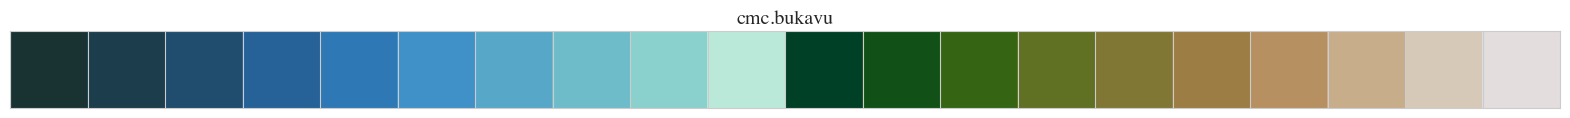

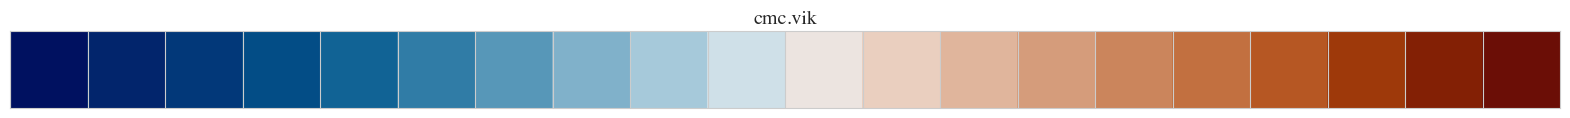

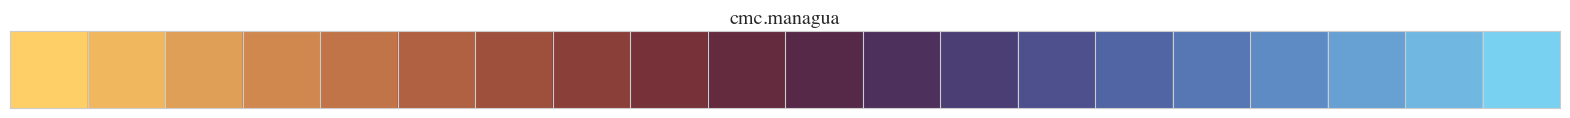

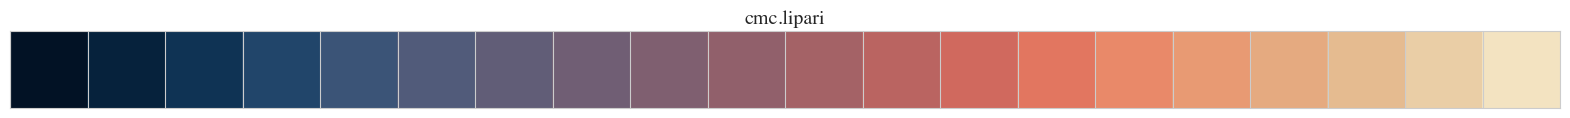

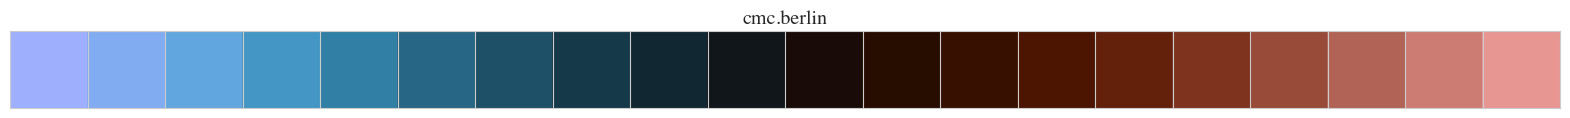

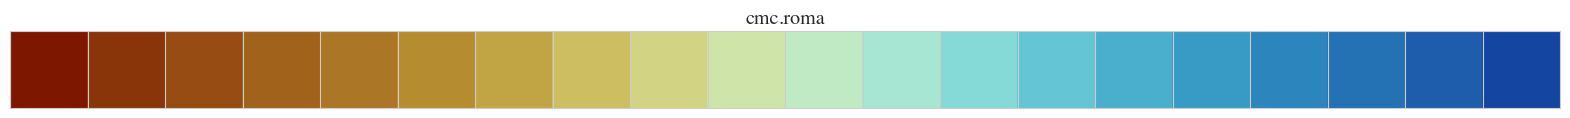

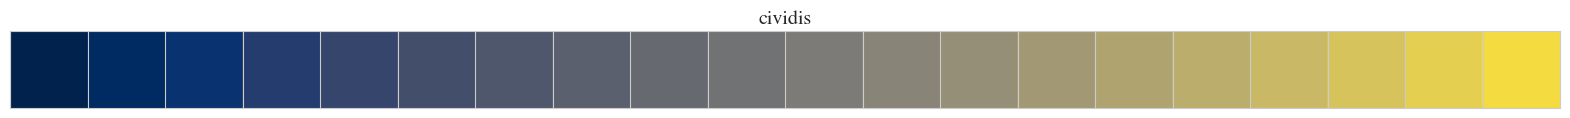

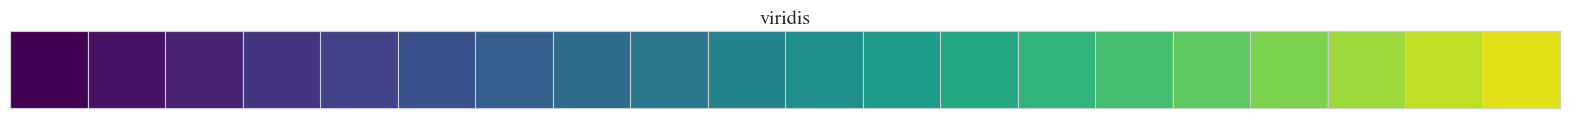

In [28]:
def create_palette(colormap_name, indices):
    try:
        colormap = plt.get_cmap(colormap_name)
        palette = colormap(indices)
        return palette
    except ValueError:
        print(f"Colormap '{colormap_name}' is not found.")
        return None

def display_palette(palette, title):
    if palette is not None:
        sns.palplot(palette)
        plt.title(title)
    else:
        print(f"Palette for '{title}' could not be displayed.")

num_colors = 200
color_indices = np.linspace(0, 1, num_colors)
selected_indices = list(range(0, 200, 10))

# Dictionary to store palettes
palettes = {}

# Create palettes for each colormap
for colormap_name in ['cmc.bukavu','cmc.vik','cmc.managua','cmc.lipari', 'cmc.berlin','cmc.roma', 'cividis', 'viridis']:
    palettes[colormap_name] = create_palette(colormap_name, color_indices[selected_indices])

# Optional: Display the palettes
for name, palette in palettes.items():
    display_palette(palette, name)

plt.show()

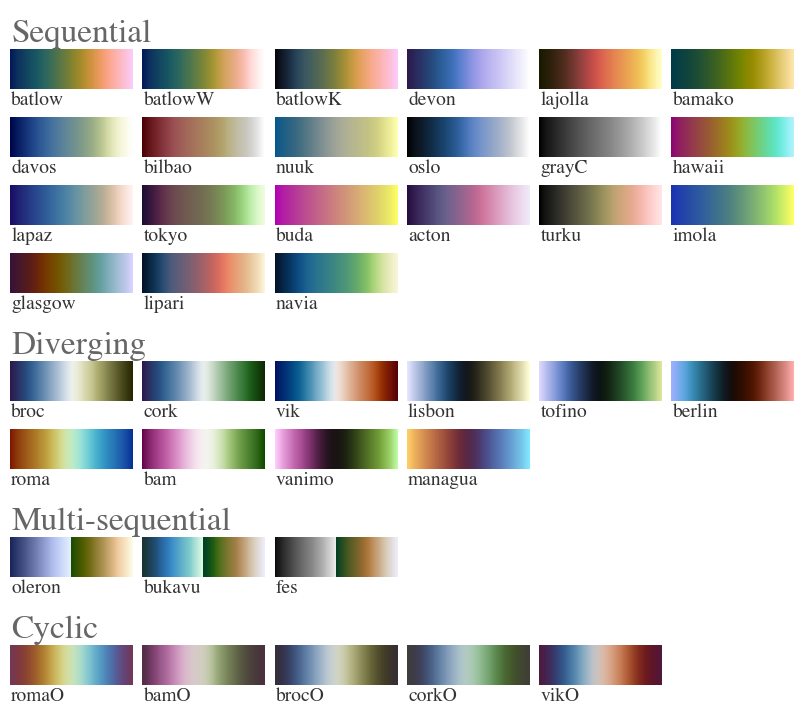

In [29]:
from cmcrameri import show_cmaps
show_cmaps()

In [30]:
hex_codes = palettes['cmc.roma']
color_mapping = {
    'Public Building': hex_codes[1],
    'Residential Building': hex_codes[-2],
    'Active Agent': hex_codes[4],
    'Passive Agent': hex_codes[-5],
    'Default_color': '#000000',
    'Building Task': '#000000',
    'Agent Task': '#000000'
}
# Subset to get the first two key-value pairs
Colors_Build = {k: color_mapping[k] for k in list(color_mapping)[:2]}
Colors_Agent = {k: color_mapping[k] for k in list(color_mapping)[2:]}

In [31]:
hex_codes

array([[4.92325e-01, 9.07870e-02, 7.60000e-05, 1.00000e+00],
       [5.43266e-01, 2.05524e-01, 3.59250e-02, 1.00000e+00],
       [5.91737e-01, 3.00697e-01, 7.45640e-02, 1.00000e+00],
       [6.33994e-01, 3.84670e-01, 1.10736e-01, 1.00000e+00],
       [6.73440e-01, 4.65303e-01, 1.47848e-01, 1.00000e+00],
       [7.14426e-01, 5.50692e-01, 1.95605e-01, 1.00000e+00],
       [7.58523e-01, 6.45147e-01, 2.69325e-01, 1.00000e+00],
       [8.00699e-01, 7.46187e-01, 3.83072e-01, 1.00000e+00],
       [8.23613e-01, 8.32270e-01, 5.17753e-01, 1.00000e+00],
       [8.11371e-01, 8.96160e-01, 6.60600e-01, 1.00000e+00],
       [7.52665e-01, 9.18838e-01, 7.65957e-01, 1.00000e+00],
       [6.52735e-01, 9.02379e-01, 8.24863e-01, 1.00000e+00],
       [5.25217e-01, 8.51658e-01, 8.43811e-01, 1.00000e+00],
       [3.94062e-01, 7.75727e-01, 8.33595e-01, 1.00000e+00],
       [2.87067e-01, 6.89401e-01, 8.06696e-01, 1.00000e+00],
       [2.20062e-01, 6.10472e-01, 7.76315e-01, 1.00000e+00],
       [1.74797e-01, 5.2

In [32]:
def calculate_dwelling_summary(data):
    """
    Calculate the dwelling summary given the data.
    """
    # Group and aggregate data
    agg_funcs = ['size', 'mean', 'median', 'std']
    grouped_data = data.groupby(["Agent_Category", "Building_Category"])[["Dwelling_Time_Agent_Gaze", "Dwelling_Time_Building_Gaze"]].agg(agg_funcs)

    # Refactor multi-index columns
    grouped_data.columns = ['_'.join(col) for col in grouped_data.columns]
    
    # Calculate standard errors
    grouped_data["Standard_error_building"] = grouped_data.Dwelling_Time_Building_Gaze_std/np.sqrt(grouped_data.Dwelling_Time_Agent_Gaze_size)
    grouped_data["Standard_error_agent"] = grouped_data.Dwelling_Time_Agent_Gaze_std/np.sqrt(grouped_data.Dwelling_Time_Agent_Gaze_size)
    
    # Rename size column for clarity
    grouped_data.rename({"Dwelling_Time_Agent_Gaze_size": "Size"}, axis=1, inplace=True)
    
    # Reset index and return the final DataFrame
    return grouped_data.reset_index()

# Using the function for both experiments
Dwelling_Summary_Exp1 = calculate_dwelling_summary(BehavioralData_Fixations_Wide_Exp1)
Dwelling_Summary_Exp2 = calculate_dwelling_summary(BehavioralData_Fixations_Wide_Exp2)
Complete_Experiments_Summary = calculate_dwelling_summary(Complete_Experiments)

# Display Dwelling_Summary_Exp2
Dwelling_Summary_Exp2 

,Agent_Category,Building_Category,Size,Dwelling_Time_Agent_Gaze_mean,Dwelling_Time_Agent_Gaze_median,Dwelling_Time_Agent_Gaze_std,Dwelling_Time_Building_Gaze_size,Dwelling_Time_Building_Gaze_mean,Dwelling_Time_Building_Gaze_median,Dwelling_Time_Building_Gaze_std,Standard_error_building,Standard_error_agent
0,Active,Public,1146,4.129808,2.798426,4.197928,1146,10.323296,8.520016,9.452156,0.279215,0.124006
1,Active,Residential,1064,4.921243,3.625199,4.492010,1064,13.152480,11.174405,7.600387,0.233005,0.137711
2,Passive,Public,1201,3.293925,2.424010,3.038793,1201,12.643479,10.301814,9.058129,0.261377,0.087686
3,Passive,Residential,1288,3.317374,1.944850,3.606353,1288,13.932575,11.865184,8.583270,0.239163,0.100487


### Dwelling

In [33]:
#Grouping for 4 separete colors 

grouped = BehavioralData_Fixations_Wide_Exp2.groupby(["Agent_Category", "Building_Category"])[["Dwelling_Time_Building_Gaze","Dwelling_Time_Agent_Gaze"]].mean().reset_index()
grouped["Building_Agent"] = grouped["Building_Category"] + " location \n" + grouped["Agent_Category" ] + " Agent"  

# Create a new column for the total dwelling time and sort the DataFrame by it
grouped['Total_Dwelling_Time'] = grouped['Dwelling_Time_Building_Gaze'] + grouped['Dwelling_Time_Agent_Gaze']
grouped['m'] = pd.Categorical(grouped['Building_Agent'], ["Public location \nActive Agent", "Public location \nPassive Agent", "Residential location \nActive Agent", "Residential location \nPassive Agent"])
grouped = grouped.sort_values(by="m")

# Determine colors based on conditions
bottom_colors = [hex_codes[1] if building == 'Public' else hex_codes[-2] for building in grouped['Building_Category']]  # Darker shades
top_colors = [hex_codes[4] if agent == 'Active' else hex_codes[-5] for agent in grouped['Agent_Category']]  # Original shades

# Define the position for the bars
bar_positions = range(len(grouped))

In [34]:
display(Dwelling_data['Exp1_Active'][Dwelling_data['Exp1_Active'].Congruent ==  "Congruent"][['Dwelling_Time_Agent_Gaze_mean', 'Dwelling_Time_Agent_Gaze_std']])
display(Dwelling_data['Exp2_Active'][Dwelling_data['Exp2_Active'].Building_Category == 'Public'][['Dwelling_Time_Agent_Gaze_mean', 'Dwelling_Time_Agent_Gaze_std']])

,Dwelling_Time_Agent_Gaze_mean,Dwelling_Time_Agent_Gaze_std
0,2.604499,2.44251


,Dwelling_Time_Agent_Gaze_mean,Dwelling_Time_Agent_Gaze_std
0,4.129808,4.197928


In [35]:
Dwelling_data['Exp1_Active'][Dwelling_data['Exp1_Active'].Congruent ==  "Congruent"]

,Congruent,Agent_Category,Building_Category,Size,Dwelling_Time_Agent_Gaze_mean,Dwelling_Time_Agent_Gaze_median,Dwelling_Time_Agent_Gaze_std,Dwelling_Time_Building_Gaze_size,Dwelling_Time_Building_Gaze_mean,Dwelling_Time_Building_Gaze_median,Dwelling_Time_Building_Gaze_std,Standard_error_building,Standard_error_agent
0,Congruent,Active,Public,3512,2.604499,1.985241,2.44251,3512,12.916917,11.55354,7.65057,0.129097,0.041215


In [36]:
display(Dwelling_data['Exp1_Active'][Dwelling_data['Exp1_Active'].Congruent ==  "Congruent"][['Dwelling_Time_Building_Gaze_mean', 'Dwelling_Time_Building_Gaze_std']])
display(Dwelling_data['Exp2_Active'][Dwelling_data['Exp2_Active'].Building_Category == 'Public'][['Dwelling_Time_Building_Gaze_mean', 'Dwelling_Time_Building_Gaze_std']])

,Dwelling_Time_Building_Gaze_mean,Dwelling_Time_Building_Gaze_std
0,12.916917,7.65057


,Dwelling_Time_Building_Gaze_mean,Dwelling_Time_Building_Gaze_std
0,10.323296,9.452156


In [37]:
display(Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Active"][['Dwelling_Time_Agent_Gaze_mean', 'Dwelling_Time_Agent_Gaze_std', 'Agent_Category','Dwelling_Time_Building_Gaze_mean', 'Dwelling_Time_Building_Gaze_std']])
display(Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Passive"][['Dwelling_Time_Agent_Gaze_mean', 'Dwelling_Time_Agent_Gaze_std', 'Agent_Category','Dwelling_Time_Building_Gaze_mean', 'Dwelling_Time_Building_Gaze_std']])

,Dwelling_Time_Agent_Gaze_mean,Dwelling_Time_Agent_Gaze_std,Agent_Category,Dwelling_Time_Building_Gaze_mean,Dwelling_Time_Building_Gaze_std
0,3.388704,3.493364,Active,12.414921,8.127467


,Dwelling_Time_Agent_Gaze_mean,Dwelling_Time_Agent_Gaze_std,Agent_Category,Dwelling_Time_Building_Gaze_mean,Dwelling_Time_Building_Gaze_std
1,2.728111,2.905124,Passive,13.279181,9.272494


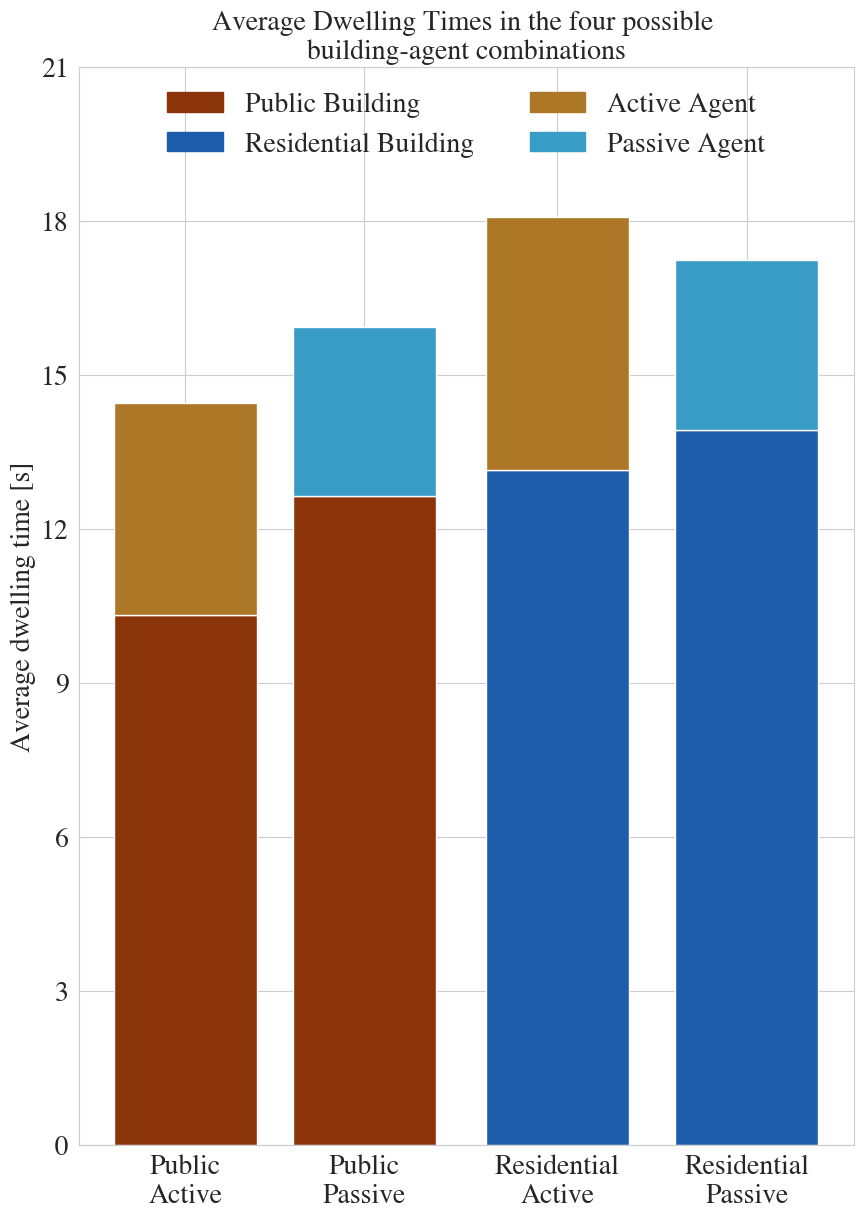

In [38]:
# Renamed what will be the labes for plot ax0
grouped['Building_Agent'] = ["Public\nActive", "Public\nPassive","Residential\nActive", "Residential\nPassive"]

# Define the position for the bars
bar_positions = range(len(grouped))
offsets = itertools.cycle([-0.04, -0.04, 0.04, 0.1])
# Calculate new positions
new_bar_positions = [pos + offset for pos, offset in zip(bar_positions, offsets)]

# Create a new figure with adjusted size (you can change the size if needed)
fig = plt.figure(figsize=(10, 14))

# Define the single grid structure
gs = gridspec.GridSpec(1, 1) # One subplot

ax0 = fig.add_subplot(gs[0, 0]) # Add the only plot

# Plot the data with the determined colors
ax0.bar(new_bar_positions, grouped['Dwelling_Time_Building_Gaze'], color=bottom_colors)
ax0.bar(new_bar_positions, grouped['Dwelling_Time_Agent_Gaze'], bottom=grouped['Dwelling_Time_Building_Gaze'], color=top_colors)

# Set the x-ticks and their labels
ax0.set_ylim((0, 21))
ax0.set_xticks(new_bar_positions)
ax0.set_xticklabels(grouped['Building_Agent'], rotation=0, fontweight='bold')
loc = plt.MaxNLocator(integer=True)
ax0.yaxis.set_major_locator(loc)

# Manually set tick labels to bold
for label in ax0.get_yticklabels():
    label.set_fontsize(20)
    label.set_fontweight('bold')

for label in ax0.get_xticklabels():
    label.set_fontsize(20)
    label.set_fontweight('bold')

# Set y-axis label and title to bold
ax0.set_ylabel('Average dwelling time [s]', fontweight='bold', fontsize=20)
ax0.set_title('Average Dwelling Times in the four possible \nbuilding-agent combinations', fontsize=20, fontweight='bold')

# Create custom legend
legend_elements = [
    mpatches.Patch(color=hex_codes[1], label='Public Building'),
    mpatches.Patch(color=hex_codes[-2], label='Residential Building'),
    mpatches.Patch(color=hex_codes[4], label='Active Agent'),
    mpatches.Patch(color=hex_codes[-5], label='Passive Agent')
]
ax0.legend(ncol=2, loc="upper center", handles=legend_elements, fontsize=20, frameon=False)

# Save the figure with tight layout
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Dwelling_times_single_plot_bold.jpg", bbox_inches="tight", pad_inches=0.1,  dpi=300, format='jpg')
plt.show()


In [39]:

display(Complete_Experiments_Building[Complete_Experiments_Building.Building_Category == 'Public'][['Dwelling_Time_Agent_Gaze_mean', 'Dwelling_Time_Agent_Gaze_std', 'Building_Category','Dwelling_Time_Building_Gaze_mean', 'Dwelling_Time_Building_Gaze_std']])
display(Complete_Experiments_Building[Complete_Experiments_Building.Building_Category == 'Residential'][['Dwelling_Time_Agent_Gaze_mean', 'Dwelling_Time_Agent_Gaze_std', 'Building_Category','Dwelling_Time_Building_Gaze_mean', 'Dwelling_Time_Building_Gaze_std']])

,Dwelling_Time_Agent_Gaze_mean,Dwelling_Time_Agent_Gaze_std,Building_Category,Dwelling_Time_Building_Gaze_mean,Dwelling_Time_Building_Gaze_std
0,3.068639,3.074359,Public,12.319341,8.424942


,Dwelling_Time_Agent_Gaze_mean,Dwelling_Time_Agent_Gaze_std,Building_Category,Dwelling_Time_Building_Gaze_mean,Dwelling_Time_Building_Gaze_std
1,3.035946,3.367111,Residential,13.389697,9.011938


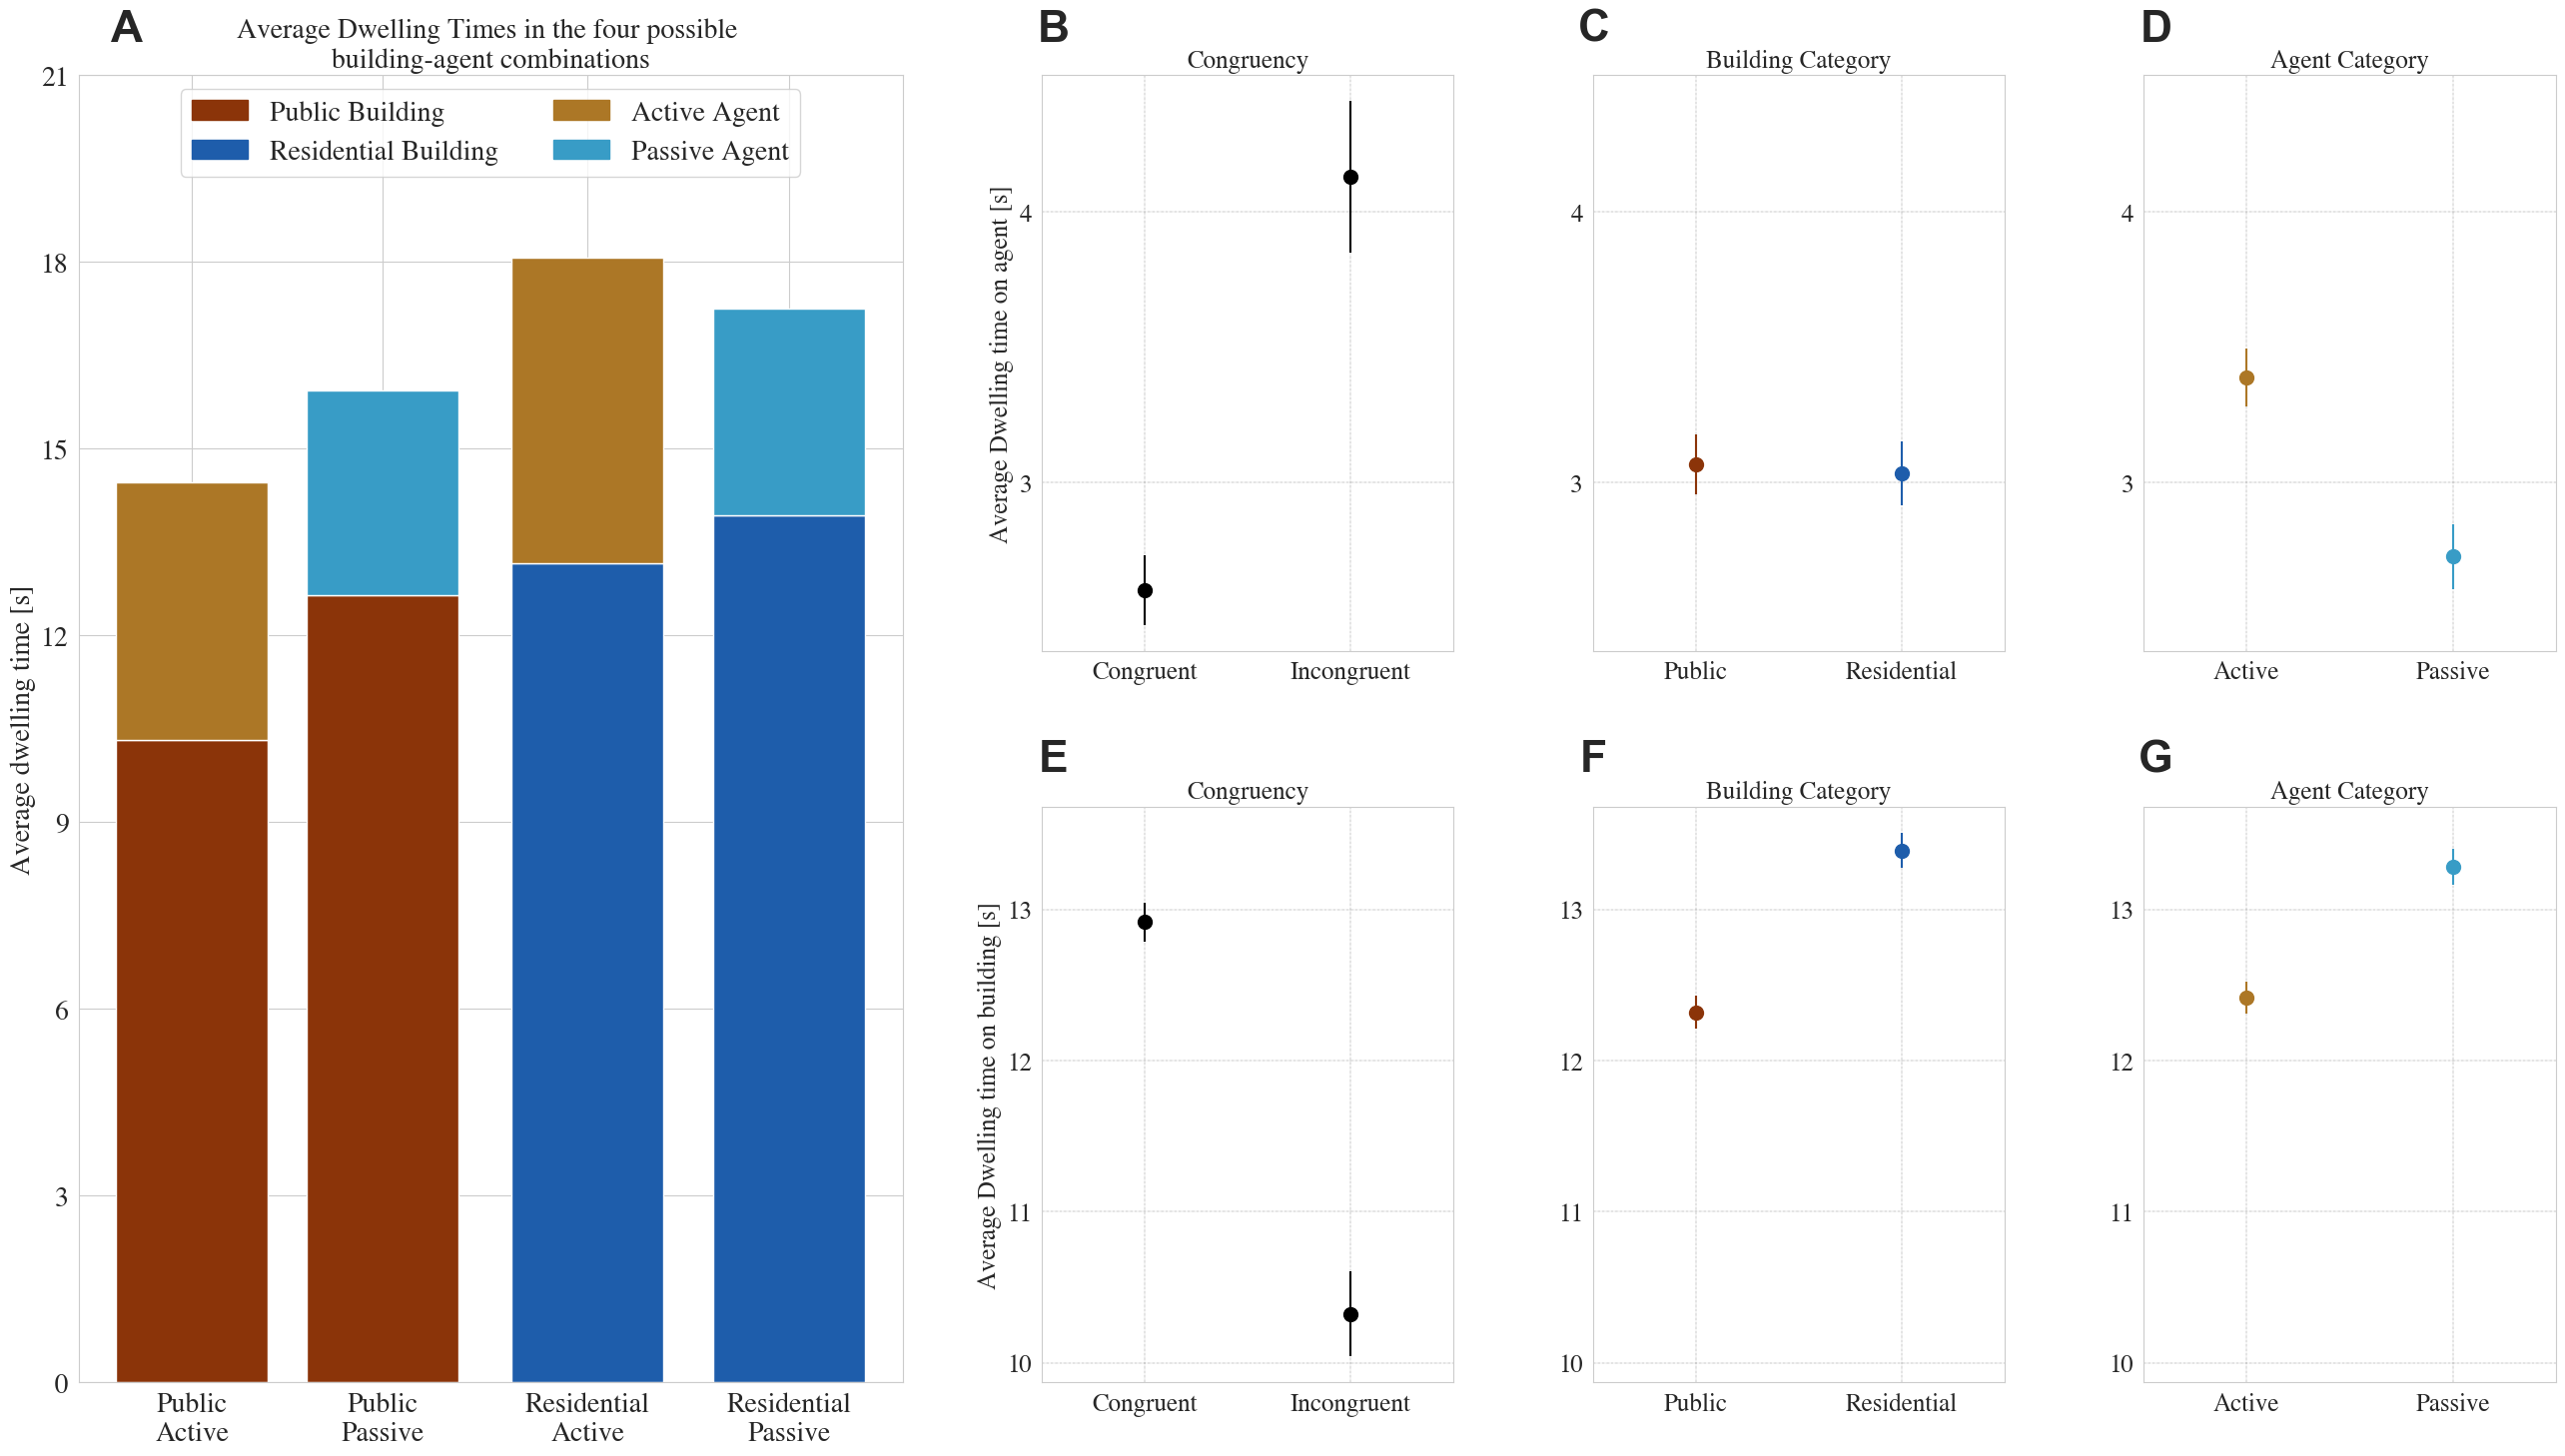

In [40]:
# Renamed what will be the labes for plot ax0
grouped['Building_Agent'] = ["Public\nActive", "Public\nPassive","Residential\nActive", "Residential\nPassive"]

# Define the position for the bars
bar_positions = range(len(grouped))
offsets = itertools.cycle([-0.04, -0.04, 0.04, 0.1])
# Calculate new positions
new_bar_positions = [pos + offset for pos, offset in zip(bar_positions, offsets)]

# Create a new figure
fig = plt.figure(figsize=(32, 17))
gs = gridspec.GridSpec(2, 4,  width_ratios=[2, 1, 1, 1]) # Define the grid structure
gs.update(wspace=0.27, hspace=0.27)

ax0 = fig.add_subplot(gs[0:2,0:1]) # Add the first plot

# Plot the data with the determined colors
ax0.bar(new_bar_positions, grouped['Dwelling_Time_Building_Gaze'], color=bottom_colors)
ax0.bar(new_bar_positions, grouped['Dwelling_Time_Agent_Gaze'], bottom=grouped['Dwelling_Time_Building_Gaze'], color=top_colors)

# Set the x-ticks and their labels
ax0.set_ylim((0, 21))
ax0.set_xticks(new_bar_positions)
ax0.set_xticklabels(grouped['Building_Agent'], rotation=0)
loc = plt.MaxNLocator(integer=True)
ax0.yaxis.set_major_locator(loc)
ax0.tick_params(axis='y', labelsize=20)
ax0.tick_params(axis='x', labelsize=20)
ax0.yaxis.get_label().set_fontsize(20)

# Add labels and title
#ax0.set_xlabel('Experimental buildings')
ax0.set_ylabel('Average dwelling time [s]')
ax0.set_title('Average Dwelling Times in the four possible \nbuilding-agent combinations',  fontsize=20)


# Create custom legend
legend_elements = [mpatches.Patch(color=hex_codes[1], label='Public Building'),
                   mpatches.Patch(color=hex_codes[-2], label='Residential Building'),
                   mpatches.Patch(color=hex_codes[4], label='Active Agent'),
                   mpatches.Patch(color=hex_codes[-5], label='Passive Agent')]
ax0.legend(ncol=2, loc= "upper center", handles=legend_elements, fontsize=20)



def configure_errorbar_plot(ax, data, title, x_col, y_col):
    for df, label in data:
        ax.errorbar(x=df[x_col], y=df[y_col],
                    yerr=df["Standard_error_building"], fmt='o', color=color_mapping[label], label=label, markersize=10, capthick=20)
    ax.set_title(title, fontsize=18)
    loc = plt.MaxNLocator(integer=True)
    ax.yaxis.set_major_locator(loc)
    ax.set_xlim((-0.5, 1.5))
    ax.grid(True, color="grey", linewidth="0.3", linestyle="-.")
    ax.tick_params(axis='both', labelsize=18)
    ax.yaxis.get_label().set_fontsize(18)
    

# Add and configure subplots

ax1 = fig.add_subplot(gs[0, 1])
configure_errorbar_plot(ax1, [(Dwelling_data['Exp1_Active'][Dwelling_data['Exp1_Active'].Congruent ==  "Congruent"], 'Default_color'), (Dwelling_data['Exp2_Active'][Dwelling_data['Exp2_Active'].Building_Category == 'Public'], 'Default_color')], 'Congruency', "Congruent", "Dwelling_Time_Agent_Gaze_mean")

ax2 = fig.add_subplot(gs[0, 2], sharey= ax1)
configure_errorbar_plot(ax2, [(Complete_Experiments_Building[Complete_Experiments_Building.Building_Category == 'Public'],'Public Building'), (Complete_Experiments_Building[Complete_Experiments_Building.Building_Category == 'Residential'],'Residential Building')], 'Building Category', "Building_Category", "Dwelling_Time_Agent_Gaze_mean")

ax3 = fig.add_subplot(gs[0, 3], sharey= ax1)
configure_errorbar_plot(ax3, [(Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Active"], "Active Agent"), (Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Passive"], "Passive Agent")], 'Agent Category', "Agent_Category", "Dwelling_Time_Agent_Gaze_mean")

ax4 = fig.add_subplot(gs[1, 1])
configure_errorbar_plot(ax4, [(Dwelling_data['Exp1_Active'][Dwelling_data['Exp1_Active'].Congruent ==  "Congruent"], 'Default_color'), (Dwelling_data['Exp2_Active'][Dwelling_data['Exp2_Active'].Building_Category == 'Public'], 'Default_color')], 'Congruency', "Congruent", "Dwelling_Time_Building_Gaze_mean")

ax5 = fig.add_subplot(gs[1, 2],sharey= ax4 )
configure_errorbar_plot(ax5, [(Complete_Experiments_Building[Complete_Experiments_Building.Building_Category == 'Public'],'Public Building'), (Complete_Experiments_Building[Complete_Experiments_Building.Building_Category == 'Residential'],'Residential Building') ], 'Building Category', "Building_Category", "Dwelling_Time_Building_Gaze_mean")

ax5 = fig.add_subplot(gs[1, 3],sharey= ax4 )
configure_errorbar_plot(ax5, [(Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Active"], "Active Agent"), (Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Passive"], "Passive Agent")], 'Agent Category', "Agent_Category", "Dwelling_Time_Building_Gaze_mean")

axes_settings = {
    ax1: ("Average Dwelling time on agent [s]"),
    ax4: ("Average Dwelling time on building [s]")
}

for ax, (ylabel) in axes_settings.items():
    ax.set_ylabel(ylabel)


annotations = {
    'A': (0.14,0.9),
    'B': (0.43, 0.9),
    'C': (0.599, 0.9),
    'D': (0.775, 0.9),
    'E': (0.43, 0.47),
    'F': (0.599, 0.47),
    'G': (0.775, 0.47),
    # Add more annotations as needed
}

# Loop through annotations and add them to the figure
for text, location in annotations.items():
    fig.text(location[0], location[1], text, fontsize=32, fontweight='bold', fontfamily='sans-serif', ha='center')
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Dwelling_times.png",  bbox_inches="tight",
            pad_inches=0.3)
plt.show()


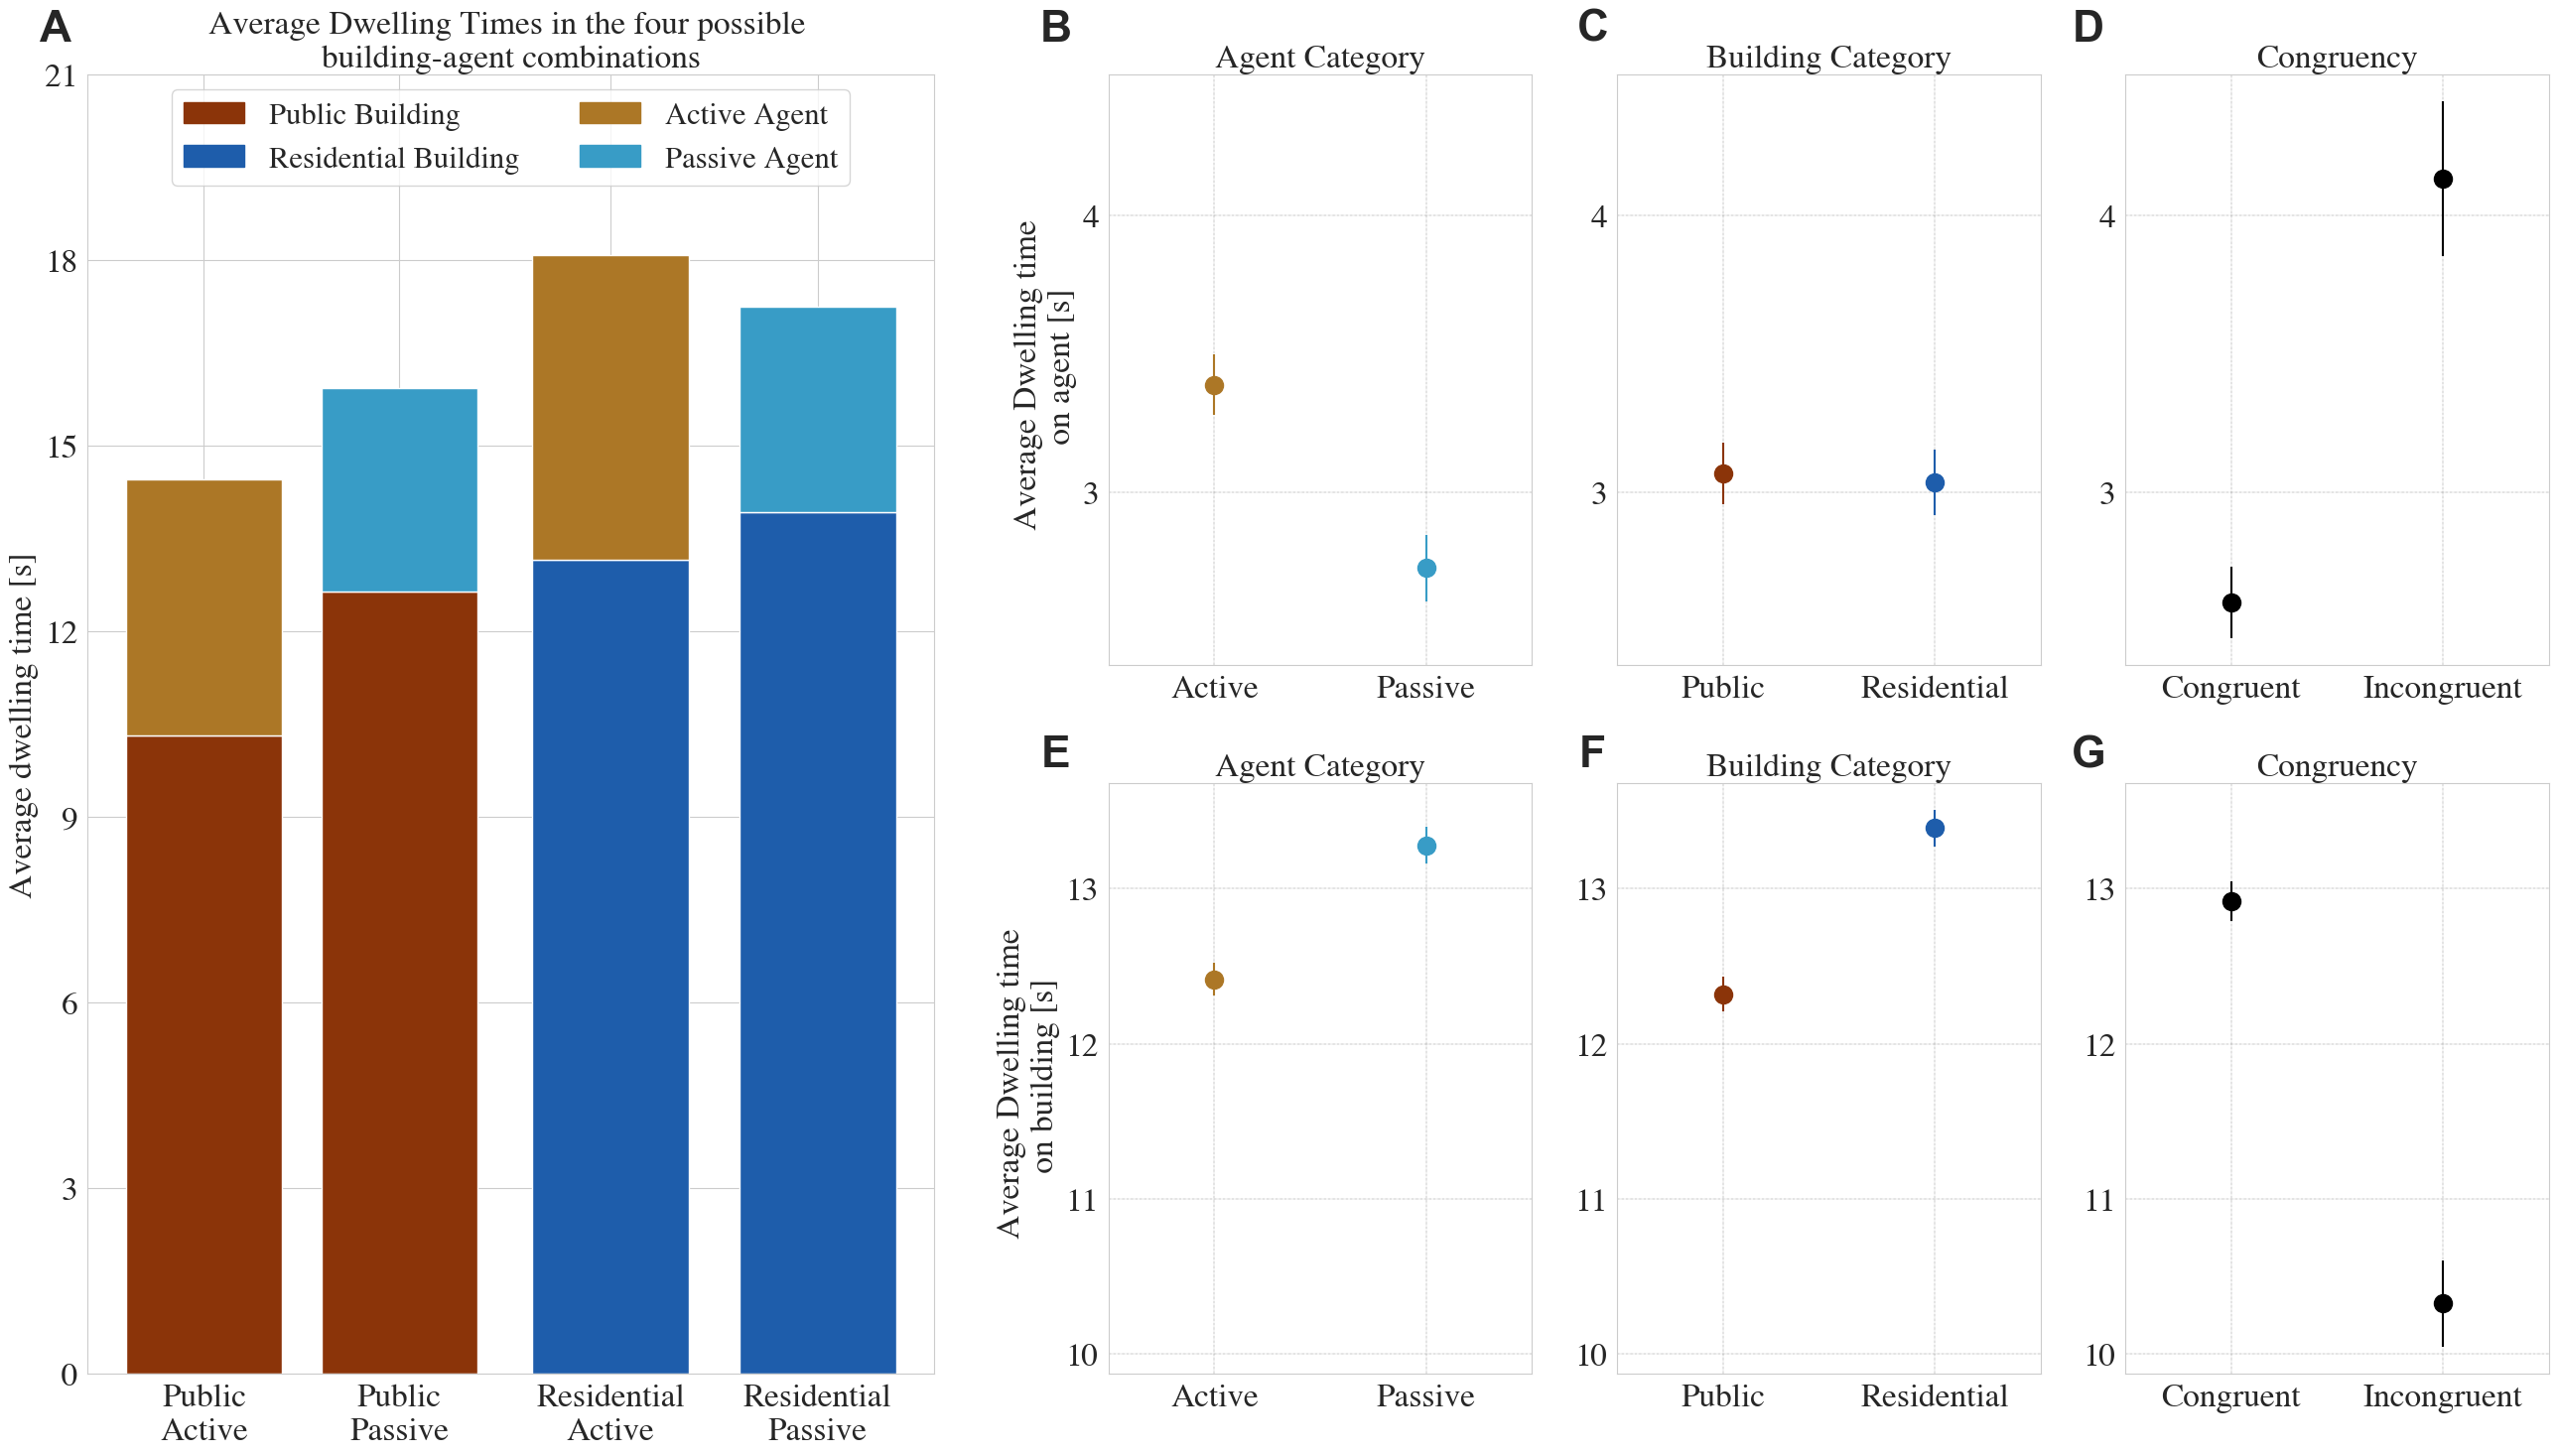

In [41]:
# Renamed what will be the labes for plot ax0
grouped['Building_Agent'] = ["Public\nActive", "Public\nPassive","Residential\nActive", "Residential\nPassive"]

# Define the position for the bars
bar_positions = range(len(grouped))
offsets = itertools.cycle([-0.04, -0.04, 0.04, 0.1])
# Calculate new positions
new_bar_positions = [pos + offset for pos, offset in zip(bar_positions, offsets)]

# Create a new figure
fig = plt.figure(figsize=(32, 17))
gs = gridspec.GridSpec(2, 5, width_ratios=[2, 0.01, 1, 1, 1])  # Add an extra column for spacing
gs.update(wspace=0.2, hspace=0.2)

ax0 = fig.add_subplot(gs[0:2,0:1]) # Add the first plot

# Plot the data with the determined colors
ax0.bar(new_bar_positions, grouped['Dwelling_Time_Building_Gaze'], color=bottom_colors)
ax0.bar(new_bar_positions, grouped['Dwelling_Time_Agent_Gaze'], bottom=grouped['Dwelling_Time_Building_Gaze'], color=top_colors)

# Set the x-ticks and their labels
ax0.set_ylim((0, 21))
ax0.set_xticks(new_bar_positions)
ax0.set_xticklabels(grouped['Building_Agent'], rotation=0)
loc = plt.MaxNLocator(integer=True)
ax0.yaxis.set_major_locator(loc)
ax0.tick_params(axis='y', labelsize=24)
ax0.tick_params(axis='x', labelsize=24)
ax0.yaxis.get_label().set_fontsize(24)

# Add labels and title
#ax0.set_xlabel('Experimental buildings')
ax0.set_ylabel('Average dwelling time [s]')
ax0.set_title('Average Dwelling Times in the four possible \nbuilding-agent combinations',  fontsize=24)


# Create custom legend
legend_elements = [mpatches.Patch(color=hex_codes[1], label='Public Building'),
                   mpatches.Patch(color=hex_codes[-2], label='Residential Building'),
                   mpatches.Patch(color=hex_codes[4], label='Active Agent'),
                   mpatches.Patch(color=hex_codes[-5], label='Passive Agent')]
ax0.legend(ncol=2, loc= "upper center", handles=legend_elements, fontsize=22)



def configure_errorbar_plot(ax, data, title, x_col, y_col):
    for df, label in data:
        ax.errorbar(x=df[x_col], y=df[y_col],
                    yerr=df["Standard_error_building"], fmt='o', color=color_mapping[label], label=label, markersize=13, capthick=20)
    ax.set_title(title, fontsize=24)
    loc = plt.MaxNLocator(integer=True)
    ax.yaxis.set_major_locator(loc)
    ax.set_xlim((-0.5, 1.5))
    ax.grid(True, color="grey", linewidth="0.3", linestyle="-.")
    ax.tick_params(axis='both', labelsize=24)
    ax.yaxis.get_label().set_fontsize(24)
    

# Add and configure subplots

ax1 = fig.add_subplot(gs[0, 4])
configure_errorbar_plot(ax1, [(Dwelling_data['Exp1_Active'][Dwelling_data['Exp1_Active'].Congruent ==  "Congruent"], 'Default_color'), (Dwelling_data['Exp2_Active'][Dwelling_data['Exp2_Active'].Building_Category == 'Public'], 'Default_color')], 'Congruency', "Congruent", "Dwelling_Time_Agent_Gaze_mean")

ax2 = fig.add_subplot(gs[0, 3], sharey= ax1)
configure_errorbar_plot(ax2, [(Complete_Experiments_Building[Complete_Experiments_Building.Building_Category == 'Public'],'Public Building'), (Complete_Experiments_Building[Complete_Experiments_Building.Building_Category == 'Residential'],'Residential Building')], 'Building Category', "Building_Category", "Dwelling_Time_Agent_Gaze_mean")

ax3 = fig.add_subplot(gs[0, 2], sharey= ax1)
configure_errorbar_plot(ax3, [(Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Active"], "Active Agent"), (Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Passive"], "Passive Agent")], 'Agent Category', "Agent_Category", "Dwelling_Time_Agent_Gaze_mean")

ax4 = fig.add_subplot(gs[1, 4])
configure_errorbar_plot(ax4, [(Dwelling_data['Exp1_Active'][Dwelling_data['Exp1_Active'].Congruent ==  "Congruent"], 'Default_color'), (Dwelling_data['Exp2_Active'][Dwelling_data['Exp2_Active'].Building_Category == 'Public'], 'Default_color')], 'Congruency', "Congruent", "Dwelling_Time_Building_Gaze_mean")

ax5 = fig.add_subplot(gs[1, 3],sharey= ax4 )
configure_errorbar_plot(ax5, [(Complete_Experiments_Building[Complete_Experiments_Building.Building_Category == 'Public'],'Public Building'), (Complete_Experiments_Building[Complete_Experiments_Building.Building_Category == 'Residential'],'Residential Building') ], 'Building Category', "Building_Category", "Dwelling_Time_Building_Gaze_mean")

ax5 = fig.add_subplot(gs[1, 2],sharey= ax4 )
configure_errorbar_plot(ax5, [(Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Active"], "Active Agent"), (Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Passive"], "Passive Agent")], 'Agent Category', "Agent_Category", "Dwelling_Time_Building_Gaze_mean")

axes_settings = {
    ax3: ("Average Dwelling time \n on agent [s]"),
    ax5: ("Average Dwelling time \n on building [s]")
}

for ax, (ylabel) in axes_settings.items():
    ax.set_ylabel(ylabel)


annotations = {
    'A': (0.115,0.9),
    'B': (0.43, 0.9),
    'C': (0.599, 0.9),
    'D': (0.755, 0.9),
    'E': (0.43, 0.47),
    'F': (0.599, 0.47),
    'G': (0.755, 0.47),
    # Add more annotations as needed
}

# Loop through annotations and add them to the figure
for text, location in annotations.items():
    fig.text(location[0], location[1], text, fontsize=32, fontweight='bold', fontfamily='sans-serif', ha='center')
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Dwelling_times.png",  bbox_inches="tight",
            pad_inches=0.3)
plt.show()


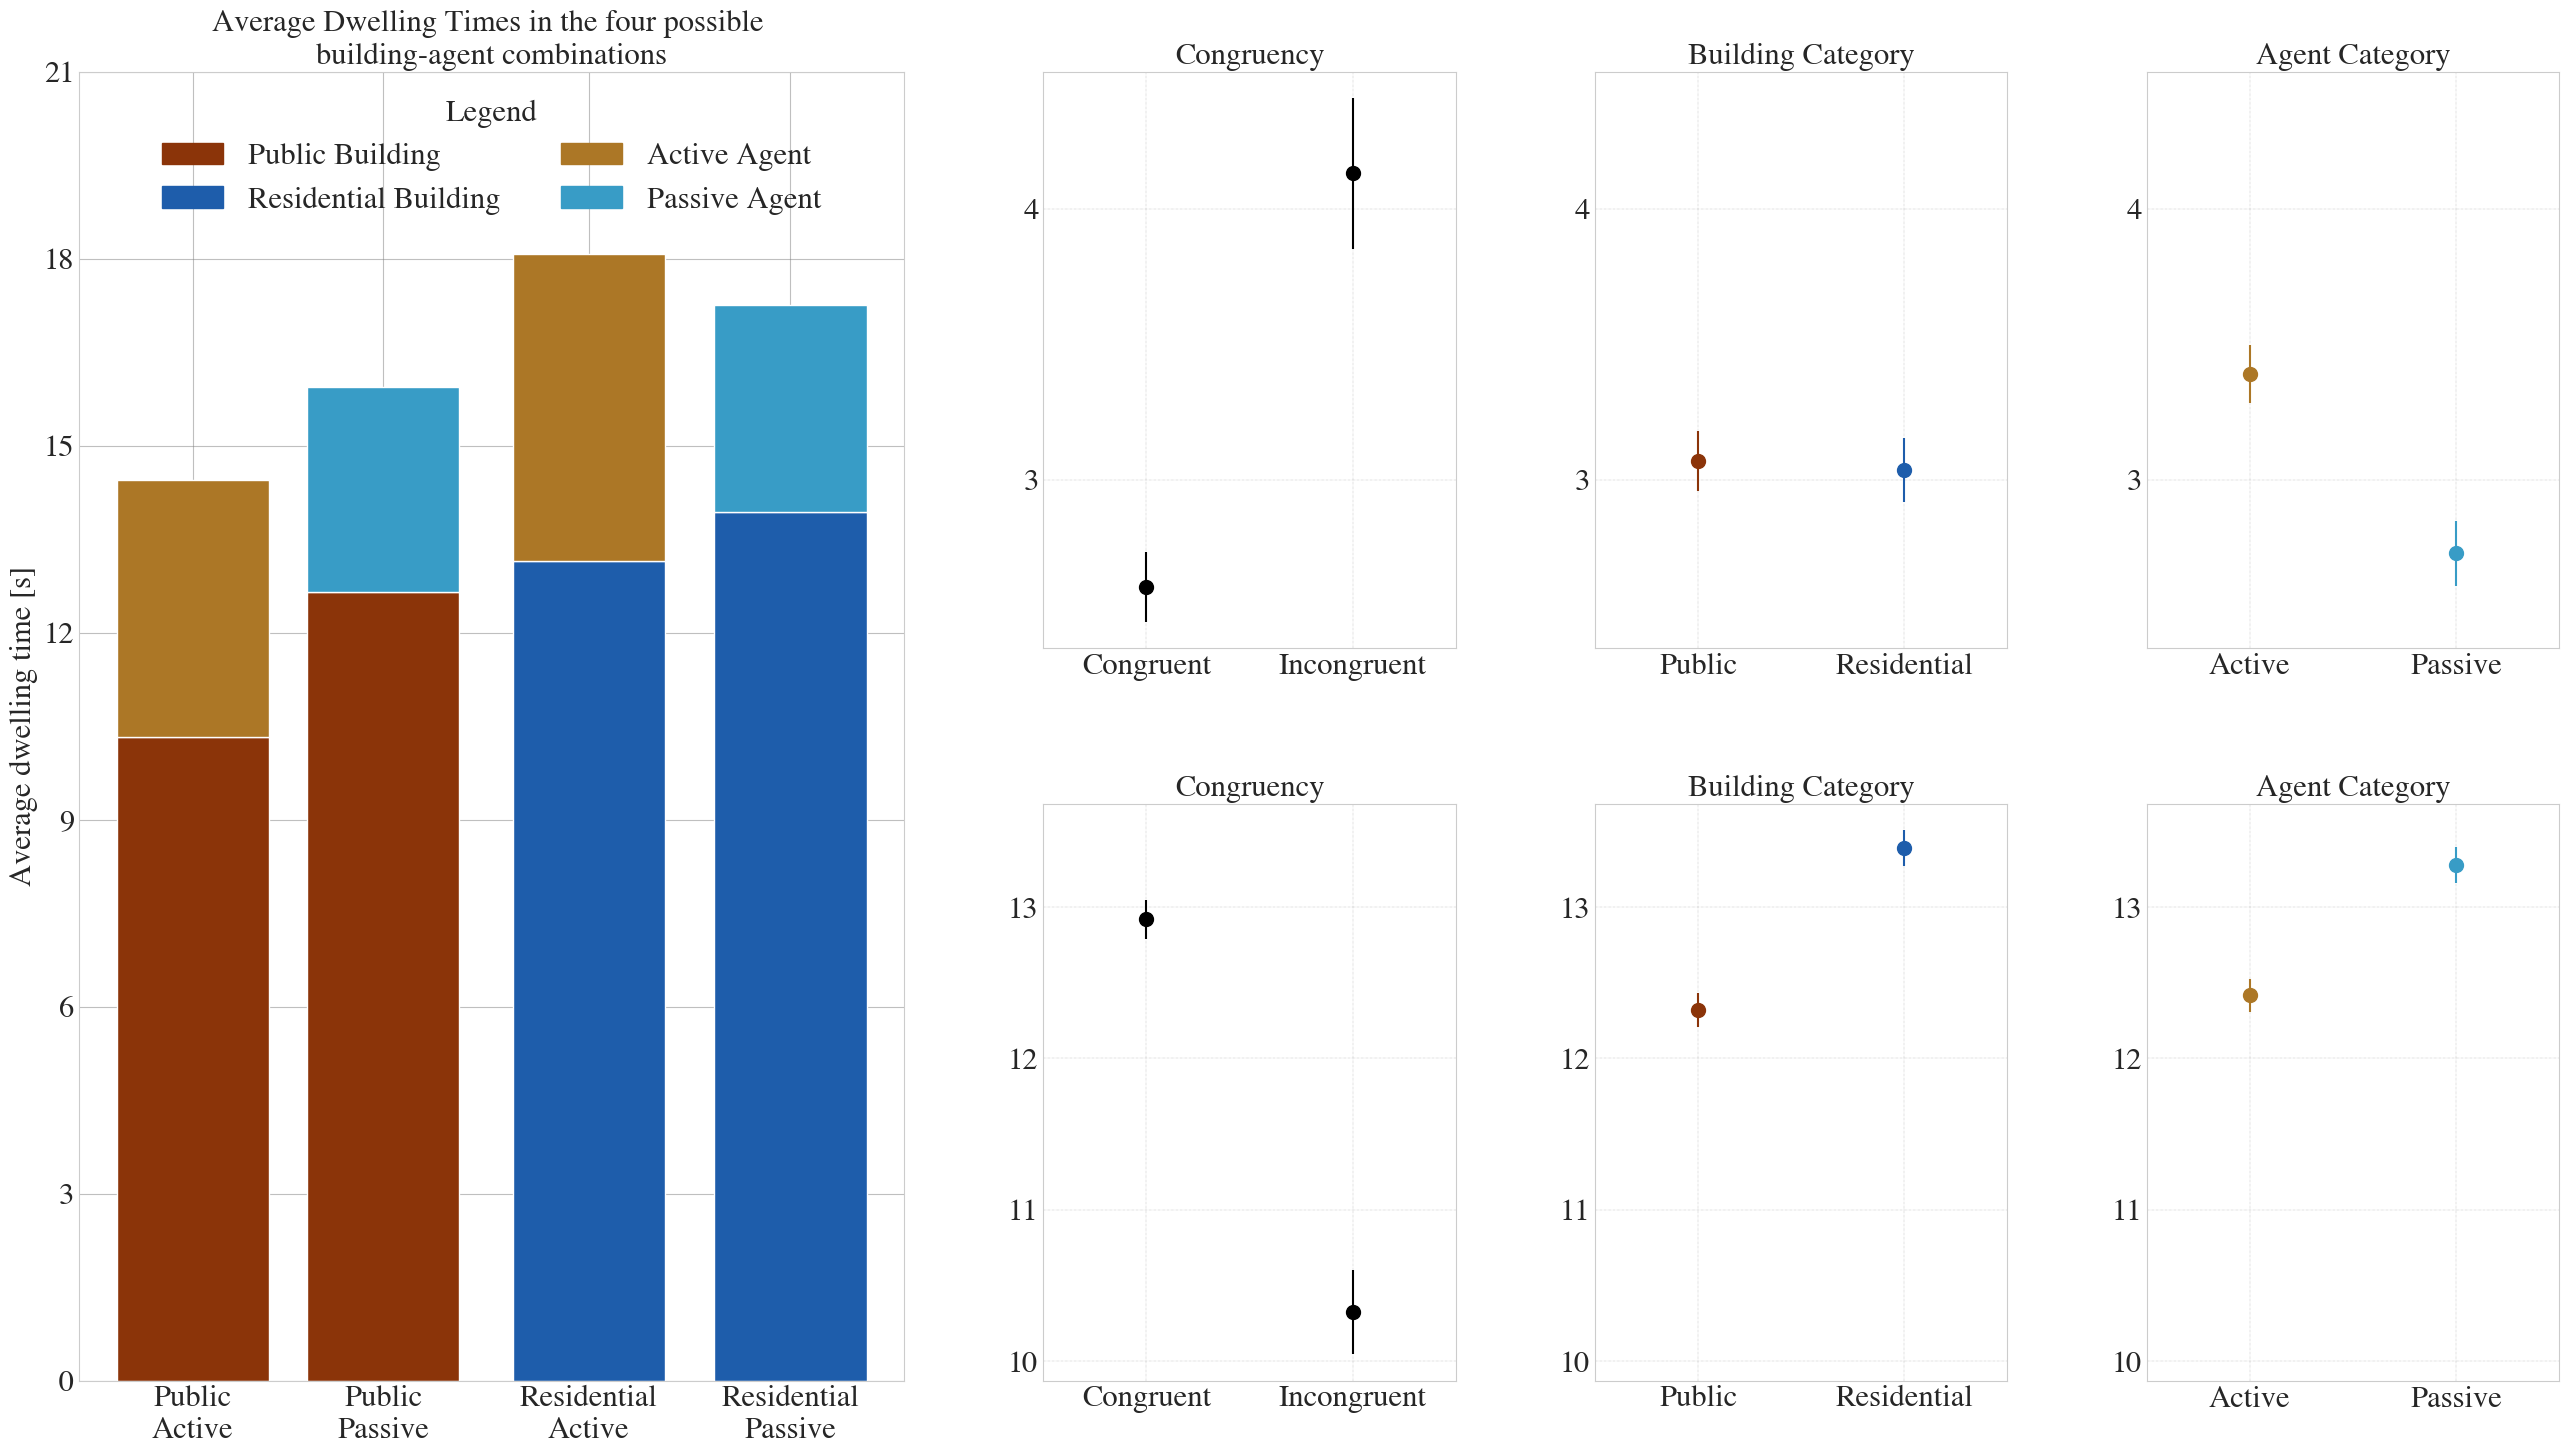

In [42]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

# Assuming grouped, Dwelling_data, Complete_Experiments_Building, Complete_Experiments_Agent, bottom_colors, top_colors, color_mapping, hex_codes are predefined

# Renamed what will be the labels for plot ax0
grouped['Building_Agent'] = ["Public\nActive", "Public\nPassive", "Residential\nActive", "Residential\nPassive"]

# Define the position for the bars
bar_positions = range(len(grouped))
offsets = itertools.cycle([-0.04, -0.04, 0.04, 0.1])
# Calculate new positions
new_bar_positions = [pos + offset for pos, offset in zip(bar_positions, offsets)]

# Create a new figure for the combined plot
fig = plt.figure(figsize=(32, 17))
gs = gridspec.GridSpec(2, 4, width_ratios=[2, 1, 1, 1])
gs.update(wspace=0.27, hspace=0.27)

# Plot ax0 (bar plot)
ax0 = fig.add_subplot(gs[0:2, 0:1])
ax0.bar(new_bar_positions, grouped['Dwelling_Time_Building_Gaze'], color=bottom_colors)
ax0.bar(new_bar_positions, grouped['Dwelling_Time_Agent_Gaze'], bottom=grouped['Dwelling_Time_Building_Gaze'], color=top_colors)
ax0.set_ylim((0, 21))
ax0.set_xticks(new_bar_positions)
ax0.set_xticklabels(grouped['Building_Agent'], rotation=0, fontsize=22, fontweight='bold')
ax0.yaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure integer ticks
ax0.tick_params(axis='y', labelsize=22, width=2, length=6, direction='in', grid_color='grey', grid_alpha=0.5)
ax0.tick_params(axis='x', labelsize=22, width=2, length=6, direction='in', grid_color='grey', grid_alpha=0.5)
ax0.set_ylabel('Average dwelling time [s]', fontsize=22, fontweight='bold')
ax0.set_title('Average Dwelling Times in the four possible \nbuilding-agent combinations', fontsize=22, fontweight='bold')

# Create custom legend for ax0
legend_elements = [mpatches.Patch(color=hex_codes[1], label='Public Building'),
                   mpatches.Patch(color=hex_codes[-2], label='Residential Building'),
                   mpatches.Patch(color=hex_codes[4], label='Active Agent'),
                   mpatches.Patch(color=hex_codes[-5], label='Passive Agent')]
ax0.legend(ncol=2, loc="upper center", handles=legend_elements, fontsize=22, frameon=False, title_fontsize=22, title="Legend")
plt.setp(ax0.get_legend().get_texts(), fontsize=22, fontweight='bold')

# Function to create errorbar plots
def configure_errorbar_plot(ax, data, title, x_col, y_col, show_labels=False):
    for df, label in data:
        ax.errorbar(x=df[x_col], y=df[y_col],
                    yerr=df["Standard_error_building"], fmt='o', color=color_mapping[label], label=label, markersize=10, capthick=20)
    ax.set_title(title, fontsize=22, fontweight='bold')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure integer ticks
    ax.set_xlim((-0.5, 1.5))
    ax.grid(True, color="grey", linewidth="0.3", linestyle="-.")
    ax.tick_params(axis='both', labelsize=22, width=2, length=6, direction='in', grid_color='grey', grid_alpha=0.5)
    if show_labels:
        ax.set_ylabel(ax.get_ylabel(), fontsize=22, fontweight='bold')
    else:
        ax.set_xlabel('')
        ax.set_ylabel('')

# Create the errorbar plots in the main combined figure
ax1 = fig.add_subplot(gs[0, 1])
configure_errorbar_plot(ax1, [(Dwelling_data['Exp1_Active'][Dwelling_data['Exp1_Active'].Congruent == "Congruent"], 'Default_color'),
                              (Dwelling_data['Exp2_Active'][Dwelling_data['Exp2_Active'].Building_Category == 'Public'], 'Default_color')],
                        'Congruency', "Congruent", "Dwelling_Time_Agent_Gaze_mean", show_labels=True)

ax2 = fig.add_subplot(gs[0, 2], sharey=ax1)
configure_errorbar_plot(ax2, [(Complete_Experiments_Building[Complete_Experiments_Building.Building_Category == 'Public'], 'Public Building'),
                              (Complete_Experiments_Building[Complete_Experiments_Building.Building_Category == 'Residential'], 'Residential Building')],
                        'Building Category', "Building_Category", "Dwelling_Time_Agent_Gaze_mean")

ax3 = fig.add_subplot(gs[0, 3], sharey=ax1)
configure_errorbar_plot(ax3, [(Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Active"], "Active Agent"),
                              (Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Passive"], "Passive Agent")],
                        'Agent Category', "Agent_Category", "Dwelling_Time_Agent_Gaze_mean")

ax4 = fig.add_subplot(gs[1, 1])
configure_errorbar_plot(ax4, [(Dwelling_data['Exp1_Active'][Dwelling_data['Exp1_Active'].Congruent == "Congruent"], 'Default_color'),
                              (Dwelling_data['Exp2_Active'][Dwelling_data['Exp2_Active'].Building_Category == 'Public'], 'Default_color')],
                        'Congruency', "Congruent", "Dwelling_Time_Building_Gaze_mean", show_labels=True)

ax5 = fig.add_subplot(gs[1, 2], sharey=ax4)
configure_errorbar_plot(ax5, [(Complete_Experiments_Building[Complete_Experiments_Building.Building_Category == 'Public'], 'Public Building'),
                              (Complete_Experiments_Building[Complete_Experiments_Building.Building_Category == 'Residential'], 'Residential Building')],
                        'Building Category', "Building_Category", "Dwelling_Time_Building_Gaze_mean")

ax6 = fig.add_subplot(gs[1, 3], sharey=ax4)
configure_errorbar_plot(ax6, [(Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Active"], "Active Agent"),
                              (Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Passive"], "Passive Agent")],
                        'Agent Category', "Agent_Category", "Dwelling_Time_Building_Gaze_mean")

# Function to recreate and save each subplot individually, ensuring shared y-axis
def recreate_and_save_subplot(shared_ax, create_subplot_func, filename, width=6, height=8):
    fig_single, ax_single = plt.subplots(figsize=(width, height))
    
    create_subplot_func(ax_single)  # Recreate the subplot in a new figure
    
    ax_single.set_ylim(shared_ax.get_ylim())  # Ensure shared y-axis
    ax_single.yaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure integer ticks
    ax_single.tick_params(axis='both', labelsize=18, direction='in', grid_color='grey', grid_alpha=0.5)
    plt.tight_layout() 
    plt.savefig(f"/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/{filename}", bbox_inches="tight", pad_inches=0.1,  dpi=300, format='jpg')
    plt.close(fig_single)

# Save individual subplots by recreating them
recreate_and_save_subplot(ax1, lambda ax: configure_errorbar_plot(ax, [(Dwelling_data['Exp1_Active'][Dwelling_data['Exp1_Active'].Congruent == "Congruent"], 'Default_color'),
                                                                       (Dwelling_data['Exp2_Active'][Dwelling_data['Exp2_Active'].Building_Category == 'Public'], 'Default_color')],
                                                             'Congruency', "Congruent", "Dwelling_Time_Agent_Gaze_mean", show_labels=True), "Dwelling_times_ax1.jpg", width=4.5, height=6)

recreate_and_save_subplot(ax1, lambda ax: configure_errorbar_plot(ax, [(Complete_Experiments_Building[Complete_Experiments_Building.Building_Category == 'Public'], 'Public Building'),
                                                                       (Complete_Experiments_Building[Complete_Experiments_Building.Building_Category == 'Residential'], 'Residential Building')],
                                                             'Building Category', "Building_Category", "Dwelling_Time_Agent_Gaze_mean"), "Dwelling_times_ax2.jpg", width=4.5, height=6)

recreate_and_save_subplot(ax1, lambda ax: configure_errorbar_plot(ax, [(Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Active"], "Active Agent"),
                                                                       (Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Passive"], "Passive Agent")],
                                                             'Agent Category', "Agent_Category", "Dwelling_Time_Agent_Gaze_mean"), "Dwelling_times_ax3.jpg", width=4.5, height=6)

recreate_and_save_subplot(ax4, lambda ax: configure_errorbar_plot(ax, [(Dwelling_data['Exp1_Active'][Dwelling_data['Exp1_Active'].Congruent == "Congruent"], 'Default_color'),
                                                                       (Dwelling_data['Exp2_Active'][Dwelling_data['Exp2_Active'].Building_Category == 'Public'], 'Default_color')],
                                                             'Congruency', "Congruent", "Dwelling_Time_Building_Gaze_mean", show_labels=True), "Dwelling_times_ax4.jpg", width=4.5, height=6)

recreate_and_save_subplot(ax4, lambda ax: configure_errorbar_plot(ax, [(Complete_Experiments_Building[Complete_Experiments_Building.Building_Category == 'Public'], 'Public Building'),
                                                                       (Complete_Experiments_Building[Complete_Experiments_Building.Building_Category == 'Residential'], 'Residential Building')],
                                                             'Building Category', "Building_Category", "Dwelling_Time_Building_Gaze_mean"), "Dwelling_times_ax5.jpg", width=4.5, height=6)

recreate_and_save_subplot(ax4, lambda ax: configure_errorbar_plot(ax, [(Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Active"], "Active Agent"),
                                                                       (Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Passive"], "Passive Agent")],
                                                             'Agent Category', "Agent_Category", "Dwelling_Time_Building_Gaze_mean"), "Dwelling_times_ax6.jpg", width=4.5, height=6)

# Save the overall combined figure
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Dwelling_times_combined.png", bbox_inches="tight", pad_inches=0.3)
plt.show()


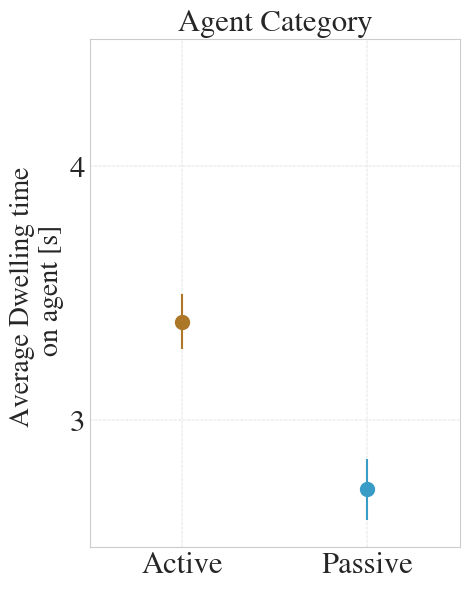

In [43]:
# Create a new figure for ax3
fig_ax3 = plt.figure(figsize=(4.8, 6))

# Add the ax3 plot
ax3 = fig_ax3.add_subplot(1, 1, 1)
configure_errorbar_plot(ax3, 
                        [(Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Active"], "Active Agent"), 
                         (Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Passive"], "Passive Agent")], 
                        'Agent Category', 
                        "Agent_Category", 
                        "Dwelling_Time_Agent_Gaze_mean")

# Apply the y-axis label for ax3
ax3.set_ylabel("Average Dwelling time \n on agent [s]", fontweight='bold', fontsize=20)

# Set y-axis limits and ticks
ax3.set_ylim(2.5, 4.5)
ax3.set_yticks([3, 4])
ax3.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Save the figure for ax3
plt.tight_layout()
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Dwelling_times_agent_plot_ax3.jpg", bbox_inches="tight", pad_inches=0.1,  dpi=300, format='jpg')
plt.show()


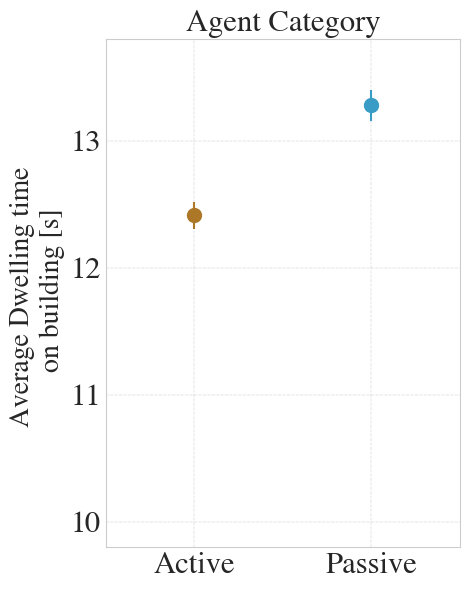

In [44]:
# Create a new figure for ax5
fig_ax5 = plt.figure(figsize=(4.8, 6))

# Add the ax5 plot
ax5 = fig_ax5.add_subplot(1, 1, 1)
configure_errorbar_plot(ax5, 
                        [(Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Active"], "Active Agent"), 
                         (Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Passive"], "Passive Agent")], 
                        'Agent Category', 
                        "Agent_Category", 
                        "Dwelling_Time_Building_Gaze_mean")

# Apply the y-axis label for ax5
ax5.set_ylabel("Average Dwelling time \n on building [s]", fontweight='bold', fontsize=20)

# Set y-axis limits and ticks
ax5.set_ylim(9.8, 13.8)
ax5.set_yticks([10, 11, 12, 13])
ax5.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Save the figure for ax5
plt.tight_layout()
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Dwelling_times_agent_plot_ax5.jpg", bbox_inches="tight", pad_inches=0.1,  dpi=300, format='jpg')
plt.show()


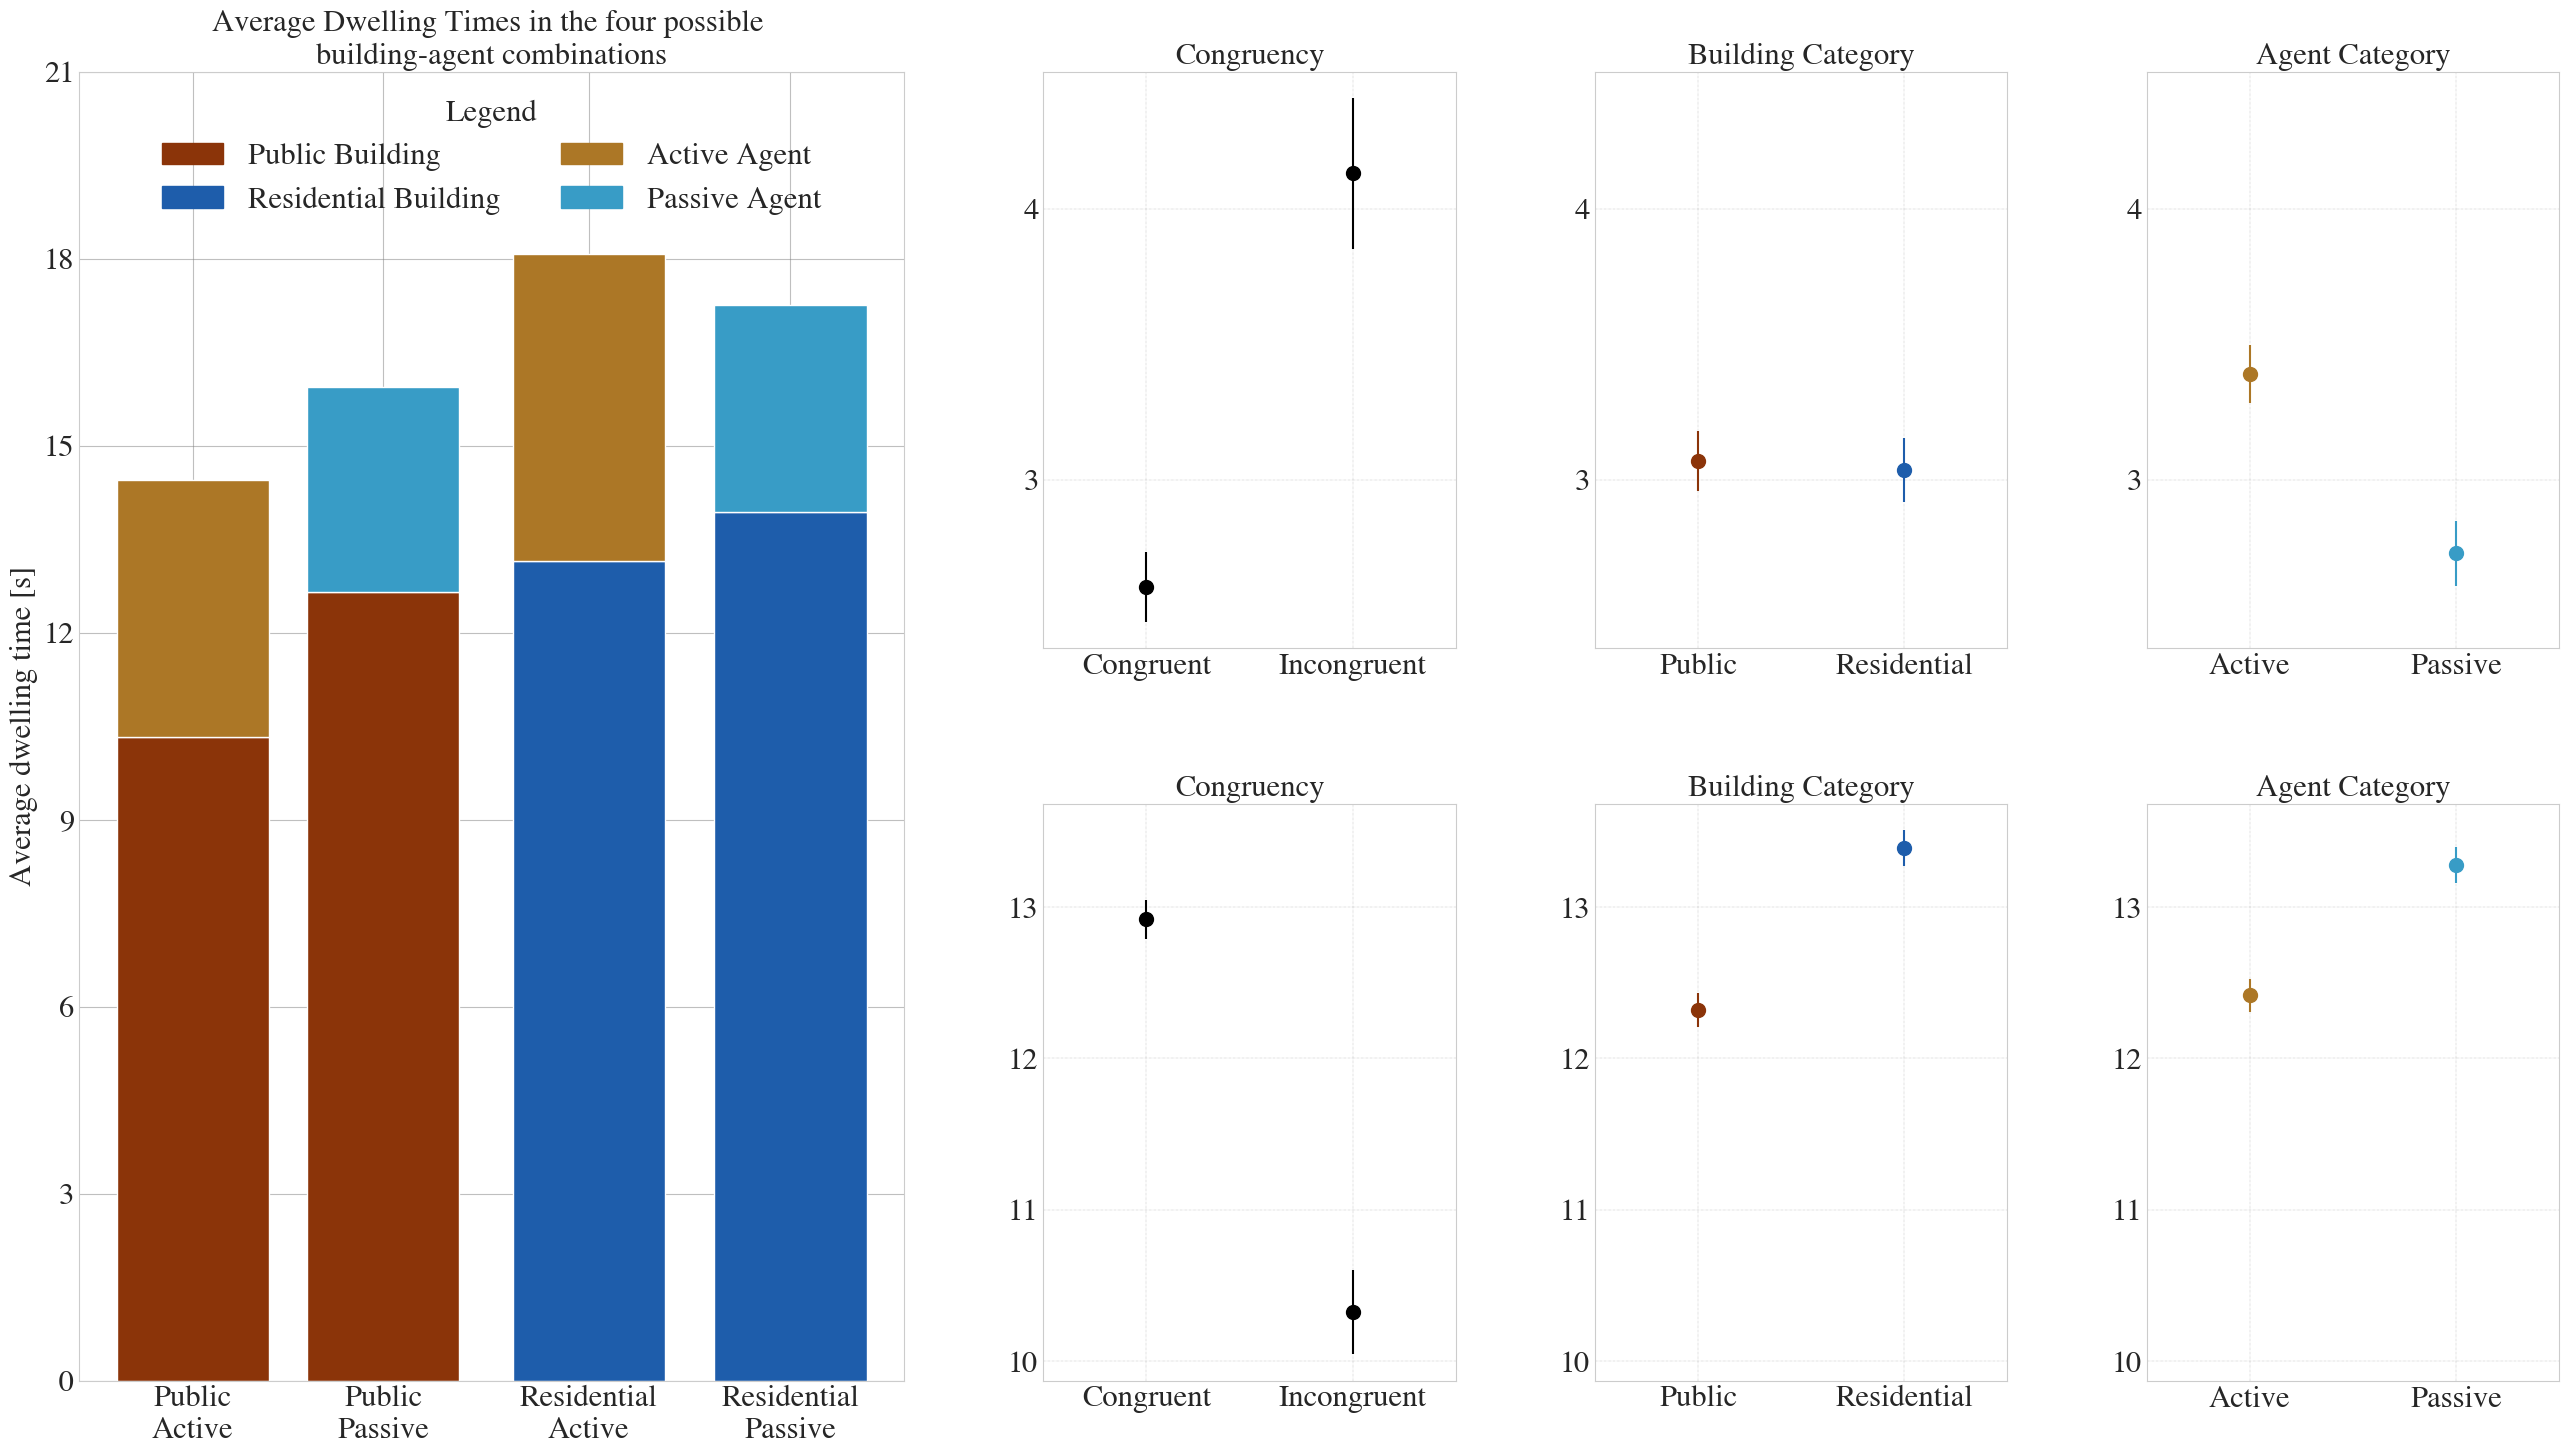

In [45]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator

# Assuming grouped, Dwelling_data, Complete_Experiments_Building, Complete_Experiments_Agent, bottom_colors, top_colors, color_mapping, hex_codes are predefined

# Renamed what will be the labels for plot ax0
grouped['Building_Agent'] = ["Public\nActive", "Public\nPassive", "Residential\nActive", "Residential\nPassive"]

# Define the position for the bars
bar_positions = range(len(grouped))
offsets = itertools.cycle([-0.04, -0.04, 0.04, 0.1])
# Calculate new positions
new_bar_positions = [pos + offset for pos, offset in zip(bar_positions, offsets)]

# Create a new figure for the combined plot
fig = plt.figure(figsize=(32, 17))
gs = gridspec.GridSpec(2, 4, width_ratios=[2, 1, 1, 1])
gs.update(wspace=0.27, hspace=0.27)

# Plot ax0 (bar plot)
ax0 = fig.add_subplot(gs[0:2, 0:1])
ax0.bar(new_bar_positions, grouped['Dwelling_Time_Building_Gaze'], color=bottom_colors)
ax0.bar(new_bar_positions, grouped['Dwelling_Time_Agent_Gaze'], bottom=grouped['Dwelling_Time_Building_Gaze'], color=top_colors)
ax0.set_ylim((0, 21))
ax0.set_xticks(new_bar_positions)
ax0.set_xticklabels(grouped['Building_Agent'], rotation=0, fontsize=22, fontweight='bold')
ax0.yaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure integer ticks
ax0.tick_params(axis='y', labelsize=22, labelrotation=0, width=2, length=6, direction='in', grid_color='grey', grid_alpha=0.5)
ax0.tick_params(axis='x', labelsize=22, labelrotation=0, width=2, length=6, direction='in', grid_color='grey', grid_alpha=0.5)
ax0.set_ylabel('Average dwelling time [s]', fontsize=22, fontweight='bold')
ax0.set_title('Average Dwelling Times in the four possible \nbuilding-agent combinations', fontsize=22, fontweight='bold')

# Create custom legend for ax0
legend_elements = [mpatches.Patch(color=hex_codes[1], label='Public Building'),
                   mpatches.Patch(color=hex_codes[-2], label='Residential Building'),
                   mpatches.Patch(color=hex_codes[4], label='Active Agent'),
                   mpatches.Patch(color=hex_codes[-5], label='Passive Agent')]
ax0.legend(ncol=2, loc="upper center", handles=legend_elements, fontsize=22, frameon=False, title_fontsize=22, title="Legend")
plt.setp(ax0.get_legend().get_texts(), fontsize=22, fontweight='bold')

# Function to create errorbar plots
def configure_errorbar_plot(ax, data, title, x_col, y_col, show_labels=False):
    for df, label in data:
        ax.errorbar(x=df[x_col], y=df[y_col],
                    yerr=df["Standard_error_building"], fmt='o', color=color_mapping[label], label=label, markersize=10, capthick=20)
    ax.set_title(title, fontsize=22, fontweight='bold')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure integer ticks
    ax.set_xlim((-0.5, 1.5))
    ax.grid(True, color="grey", linewidth="0.3", linestyle="-.")
    ax.tick_params(axis='both', labelsize=22, width=2, length=6, direction='in', grid_color='grey', grid_alpha=0.5)
    if show_labels:
        ax.set_xlabel(ax.get_xlabel(), fontsize=22, fontweight='bold')
        ax.set_ylabel(ax.get_ylabel(), fontsize=22, fontweight='bold')
    else:
        ax.set_xlabel('')
        ax.set_ylabel('')

# Create the errorbar plots with separate y-axis sharing for the top and bottom rows
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2], sharey=ax1)  # Share y-axis with ax1
ax3 = fig.add_subplot(gs[0, 3], sharey=ax1)  # Share y-axis with ax1

ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2], sharey=ax4)  # Share y-axis with ax4
ax6 = fig.add_subplot(gs[1, 3], sharey=ax4)  # Share y-axis with ax4

configure_errorbar_plot(ax1, [(Dwelling_data['Exp1_Active'][Dwelling_data['Exp1_Active'].Congruent == "Congruent"], 'Default_color'),
                              (Dwelling_data['Exp2_Active'][Dwelling_data['Exp2_Active'].Building_Category == 'Public'], 'Default_color')],
                        'Congruency', "Congruent", "Dwelling_Time_Agent_Gaze_mean", show_labels=True)

configure_errorbar_plot(ax2, [(Complete_Experiments_Building[Complete_Experiments_Building.Building_Category == 'Public'], 'Public Building'),
                              (Complete_Experiments_Building[Complete_Experiments_Building.Building_Category == 'Residential'], 'Residential Building')],
                        'Building Category', "Building_Category", "Dwelling_Time_Agent_Gaze_mean")

configure_errorbar_plot(ax3, [(Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Active"], "Active Agent"),
                              (Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Passive"], "Passive Agent")],
                        'Agent Category', "Agent_Category", "Dwelling_Time_Agent_Gaze_mean")

configure_errorbar_plot(ax4, [(Dwelling_data['Exp1_Active'][Dwelling_data['Exp1_Active'].Congruent == "Congruent"], 'Default_color'),
                              (Dwelling_data['Exp2_Active'][Dwelling_data['Exp2_Active'].Building_Category == 'Public'], 'Default_color')],
                        'Congruency', "Congruent", "Dwelling_Time_Building_Gaze_mean", show_labels=True)

configure_errorbar_plot(ax5, [(Complete_Experiments_Building[Complete_Experiments_Building.Building_Category == 'Public'], 'Public Building'),
                              (Complete_Experiments_Building[Complete_Experiments_Building.Building_Category == 'Residential'], 'Residential Building')],
                        'Building Category', "Building_Category", "Dwelling_Time_Building_Gaze_mean")

configure_errorbar_plot(ax6, [(Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Active"], "Active Agent"),
                              (Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Passive"], "Passive Agent")],
                        'Agent Category', "Agent_Category", "Dwelling_Time_Building_Gaze_mean")

# Function to recreate and save each subplot individually, ensuring shared y-axis within each row
def recreate_and_save_subplot(shared_ax, create_subplot_func, filename, width=6, height=8):
    fig_single, ax_single = plt.subplots(figsize=(width, height))
    
    create_subplot_func(ax_single)  # Recreate the subplot in a new figure
    
    ax_single.set_ylim(shared_ax.get_ylim())  # Ensure shared y-axis within the row
    ax_single.yaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure integer ticks
    ax_single.tick_params(axis='both', labelsize=24, width=2, length=6, direction='in', grid_color='grey', grid_alpha=0.5)
    
    ax_single.set_title(ax_single.get_title(), fontsize=24, fontweight='bold')
    ax_single.set_xlabel(ax_single.get_xlabel(), fontsize=24, fontweight='bold')
    ax_single.set_ylabel(ax_single.get_ylabel(), fontsize=24, fontweight='bold')

    plt.tight_layout()
    plt.savefig(f"/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/{filename}", bbox_inches="tight", pad_inches=0.3)
    plt.close(fig_single)

# Save individual subplots by recreating them
recreate_and_save_subplot(ax1, lambda ax: configure_errorbar_plot(ax, [(Dwelling_data['Exp1_Active'][Dwelling_data['Exp1_Active'].Congruent == "Congruent"], 'Default_color'),
                                                                       (Dwelling_data['Exp2_Active'][Dwelling_data['Exp2_Active'].Building_Category == 'Public'], 'Default_color')],
                                                             'Congruency', "Congruent", "Dwelling_Time_Agent_Gaze_mean", show_labels=True), "Dwelling_times_ax1.png", width=4.6, height=6)

recreate_and_save_subplot(ax2, lambda ax: configure_errorbar_plot(ax, [(Complete_Experiments_Building[Complete_Experiments_Building.Building_Category == 'Public'], 'Public Building'),
                                                                       (Complete_Experiments_Building[Complete_Experiments_Building.Building_Category == 'Residential'], 'Residential Building')],
                                                             'Building Category', "Building_Category", "Dwelling_Time_Agent_Gaze_mean"), "Dwelling_times_ax2.png", width=4.6, height=6)

recreate_and_save_subplot(ax3, lambda ax: configure_errorbar_plot(ax, [(Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Active"], "Active Agent"),
                                                                       (Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Passive"], "Passive Agent")],
                                                             'Agent Category', "Agent_Category", "Dwelling_Time_Agent_Gaze_mean"), "Dwelling_times_ax3.png", width=4.6, height=6)

recreate_and_save_subplot(ax4, lambda ax: configure_errorbar_plot(ax, [(Dwelling_data['Exp1_Active'][Dwelling_data['Exp1_Active'].Congruent == "Congruent"], 'Default_color'),
                                                                       (Dwelling_data['Exp2_Active'][Dwelling_data['Exp2_Active'].Building_Category == 'Public'], 'Default_color')],
                                                             'Congruency', "Congruent", "Dwelling_Time_Building_Gaze_mean", show_labels=True), "Dwelling_times_ax4.png", width=4.8, height=6)

recreate_and_save_subplot(ax5, lambda ax: configure_errorbar_plot(ax, [(Complete_Experiments_Building[Complete_Experiments_Building.Building_Category == 'Public'], 'Public Building'),
                                                                       (Complete_Experiments_Building[Complete_Experiments_Building.Building_Category == 'Residential'], 'Residential Building')],
                                                             'Building Category', "Building_Category", "Dwelling_Time_Building_Gaze_mean"), "Dwelling_times_ax5.png", width=4.8, height=6)

recreate_and_save_subplot(ax6, lambda ax: configure_errorbar_plot(ax, [(Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Active"], "Active Agent"),
                                                                       (Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Passive"], "Passive Agent")],
                                                             'Agent Category', "Agent_Category", "Dwelling_Time_Building_Gaze_mean"), "Dwelling_times_ax6.png", width=4.8, height=6)

# Save the overall combined figure
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Dwelling_times_combined.png", bbox_inches="tight", pad_inches=0.3)
plt.show()


In [46]:
Dwelling_data['Exp1_Active']

,Congruent,Agent_Category,Building_Category,Size,Dwelling_Time_Agent_Gaze_mean,Dwelling_Time_Agent_Gaze_median,Dwelling_Time_Agent_Gaze_std,Dwelling_Time_Building_Gaze_size,Dwelling_Time_Building_Gaze_mean,Dwelling_Time_Building_Gaze_median,Dwelling_Time_Building_Gaze_std,Standard_error_building,Standard_error_agent
0,Congruent,Active,Public,3512,2.604499,1.985241,2.44251,3512,12.916917,11.55354,7.65057,0.129097,0.041215


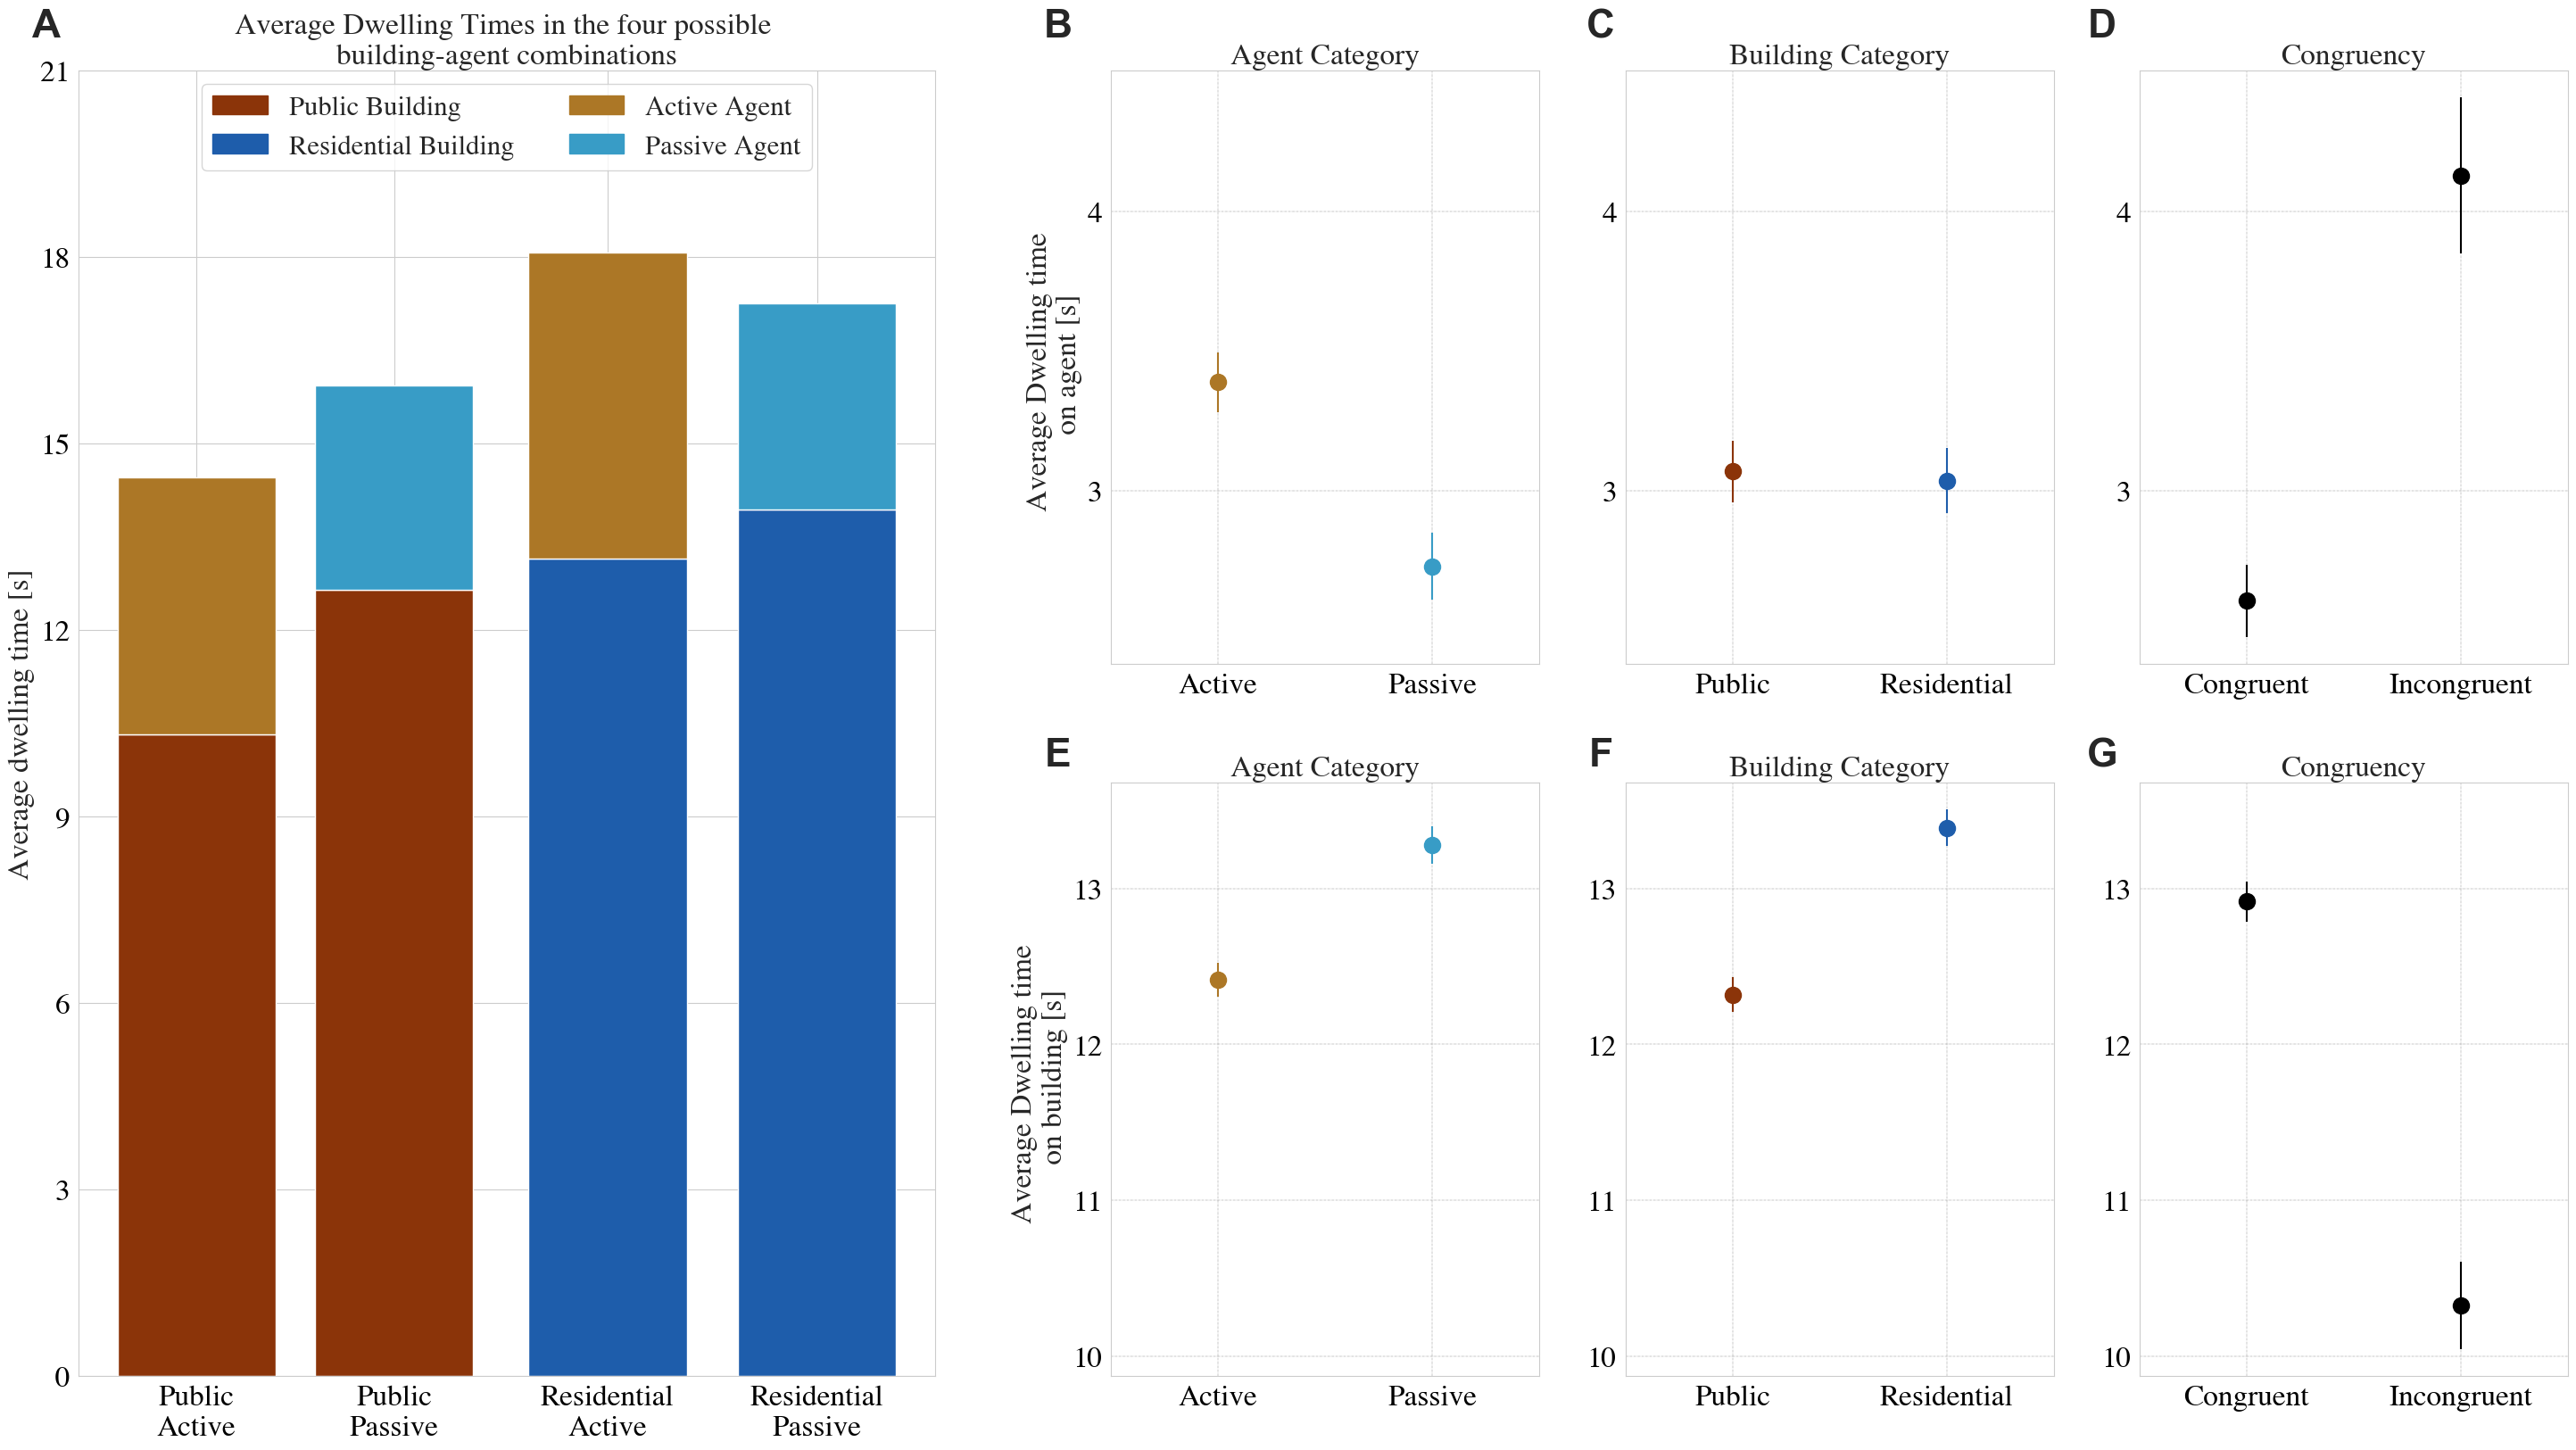

In [47]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
import matplotlib.patches as mpatches

# Assuming 'grouped', 'Dwelling_data', 'Complete_Experiments_Building', 'Complete_Experiments_Agent', 'bottom_colors', 'top_colors', and 'hex_codes' are already defined

# Define the position for the bars
bar_positions = range(len(grouped))
offsets = itertools.cycle([-0.04, -0.04, 0.04, 0.1])
# Calculate new positions
new_bar_positions = [pos + offset for pos, offset in zip(bar_positions, offsets)]

# Create a new figure
fig = plt.figure(figsize=(36, 19))
gs = gridspec.GridSpec(2, 5, width_ratios=[2, 0.01, 1, 1, 1])  # Add an extra column for spacing
gs.update(wspace=0.2, hspace=0.2)

ax0 = fig.add_subplot(gs[0:2, 0:1])  # Add the first plot

# Plot the data with the determined colors
ax0.bar(new_bar_positions, grouped['Dwelling_Time_Building_Gaze'], color=bottom_colors)
ax0.bar(new_bar_positions, grouped['Dwelling_Time_Agent_Gaze'], bottom=grouped['Dwelling_Time_Building_Gaze'], color=top_colors)

# Set the x-ticks and their labels
ax0.set_ylim((0, 21))
ax0.set_xticks(new_bar_positions)
ax0.set_xticklabels(grouped['Building_Agent'], rotation=0, fontweight='bold')
loc = plt.MaxNLocator(integer=True)
ax0.yaxis.set_major_locator(loc)
ax0.tick_params(axis='y', labelsize=24, labelrotation=0, labelcolor='black')
ax0.tick_params(axis='x', labelsize=24, labelrotation=0, labelcolor='black')
ax0.yaxis.get_label().set_fontsize(24)
ax0.yaxis.get_label().set_fontweight('bold')

# Add labels and title
ax0.set_ylabel('Average dwelling time [s]', fontsize=24, fontweight='bold')
ax0.set_title('Average Dwelling Times in the four possible \nbuilding-agent combinations', fontsize=24, fontweight='bold')

# Create custom legend
legend_elements = [
    mpatches.Patch(color=hex_codes[1], label='Public Building'),
    mpatches.Patch(color=hex_codes[-2], label='Residential Building'),
    mpatches.Patch(color=hex_codes[4], label='Active Agent'),
    mpatches.Patch(color=hex_codes[-5], label='Passive Agent')
]
ax0.legend(ncol=2, loc="upper center", handles=legend_elements, fontsize=22)

def configure_errorbar_plot(ax, data, title, x_col, y_col):
    for df, label in data:
        ax.errorbar(x=df[x_col], y=df[y_col],
                    yerr=df["Standard_error_building"], fmt='o', color=color_mapping[label], label=label, markersize=13, capthick=20)
    ax.set_title(title, fontsize=24, fontweight='bold')
    loc = plt.MaxNLocator(integer=True)
    ax.yaxis.set_major_locator(loc)
    ax.set_xlim((-0.5, 1.5))
    ax.grid(True, color="grey", linewidth="0.3", linestyle="-.")
    ax.tick_params(axis='both', labelsize=24, labelrotation=0, labelcolor='black')
    ax.yaxis.get_label().set_fontsize(24)
    ax.yaxis.get_label().set_fontweight('bold')
    ax.xaxis.get_label().set_fontsize(24)
    ax.xaxis.get_label().set_fontweight('bold')

# Add and configure subplots
ax1 = fig.add_subplot(gs[0, 4])
configure_errorbar_plot(ax1, [(Dwelling_data['Exp1_Active'][Dwelling_data['Exp1_Active'].Congruent == "Congruent"], 'Default_color'), (Dwelling_data['Exp2_Active'][Dwelling_data['Exp2_Active'].Building_Category == 'Public'], 'Default_color')], 'Congruency', "Congruent", "Dwelling_Time_Agent_Gaze_mean")

ax2 = fig.add_subplot(gs[0, 3], sharey=ax1)
configure_errorbar_plot(ax2, [(Complete_Experiments_Building[Complete_Experiments_Building.Building_Category == 'Public'], 'Public Building'), (Complete_Experiments_Building[Complete_Experiments_Building.Building_Category == 'Residential'], 'Residential Building')], 'Building Category', "Building_Category", "Dwelling_Time_Agent_Gaze_mean")

ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)
configure_errorbar_plot(ax3, [(Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Active"], "Active Agent"), (Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Passive"], "Passive Agent")], 'Agent Category', "Agent_Category", "Dwelling_Time_Agent_Gaze_mean")

ax4 = fig.add_subplot(gs[1, 4])
configure_errorbar_plot(ax4, [(Dwelling_data['Exp1_Active'][Dwelling_data['Exp1_Active'].Congruent == "Congruent"], 'Default_color'), (Dwelling_data['Exp2_Active'][Dwelling_data['Exp2_Active'].Building_Category == 'Public'], 'Default_color')], 'Congruency', "Congruent", "Dwelling_Time_Building_Gaze_mean")

ax5 = fig.add_subplot(gs[1, 3], sharey=ax4)
configure_errorbar_plot(ax5, [(Complete_Experiments_Building[Complete_Experiments_Building.Building_Category == 'Public'], 'Public Building'), (Complete_Experiments_Building[Complete_Experiments_Building.Building_Category == 'Residential'], 'Residential Building')], 'Building Category', "Building_Category", "Dwelling_Time_Building_Gaze_mean")

ax5 = fig.add_subplot(gs[1, 2], sharey=ax4)
configure_errorbar_plot(ax5, [(Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Active"], "Active Agent"), (Complete_Experiments_Agent[Complete_Experiments_Agent.Agent_Category == "Passive"], "Passive Agent")], 'Agent Category', "Agent_Category", "Dwelling_Time_Building_Gaze_mean")

axes_settings = {
    ax3: ("Average Dwelling time \n on agent [s]"),
    ax5: ("Average Dwelling time \n on building [s]")
}

for ax, ylabel in axes_settings.items():
    ax.set_ylabel(ylabel, fontweight='bold')


    
    
annotations = {
    'A': (0.115, 0.9),
    'B': (0.43, 0.9),
    'C': (0.599, 0.9),
    'D': (0.755, 0.9),
    'E': (0.43, 0.47),
    'F': (0.599, 0.47),
    'G': (0.755, 0.47),
    # Add more annotations as needed
}

# Loop through annotations and add them to the figure
for text, location in annotations.items():
    fig.text(location[0], location[1], text, fontsize=32, fontweight='bold', fontfamily='sans-serif', ha='center')

plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Dwelling_times.png", bbox_inches="tight", pad_inches=0.3)
plt.show()


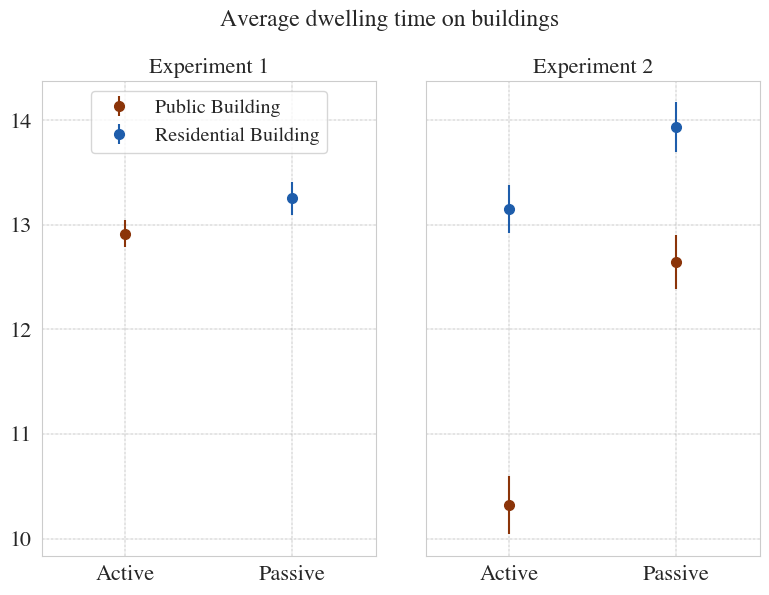

In [48]:
def plot_errorbar(ax, data, y_col, yerr_col, color, label):
    ax.errorbar(x=data["Agent_Category"], 
                y=data[y_col], 
                yerr=data[yerr_col], 
                fmt='o', color=color, 
                label=label, 
                markersize=7, capthick=20)

# Dictionary to streamline data selection
exp_data = {
    "Experiment 1": {"Public Building": Dwelling_data['Exp1_Public'], "Residential Building": Dwelling_data['Exp1_Residential']},
    "Experiment 2": {"Public Building": Dwelling_data['Exp2_Public'], "Residential Building": Dwelling_data['Exp2_Residential']}
}

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8, 6))
fig.suptitle('Average dwelling time on buildings \n', fontsize=17)
fig.tight_layout()

# Loop through the experiments and data, plotting as we go
for ax, (exp, datasets) in zip(axes, exp_data.items()):
    for label, data in datasets.items():
        plot_errorbar(ax, data, "Dwelling_Time_Building_Gaze_mean", "Standard_error_building", Colors_Build[label], label)
    
    ax.set_xlim((-0.5, 1.5))
    ax.set_xticks([0, 1])
    #ax.set_xticklabels(["Active agent", "Passive Agent"])
    ax.grid(True, color="grey", linewidth="0.3", linestyle="-.")
    ax.tick_params(axis='both', labelsize=16)
    ax.yaxis.get_label().set_fontsize(16)
    ax.set_title(exp, fontsize=16)
axes[0].legend(loc="upper center",)

plt.show()


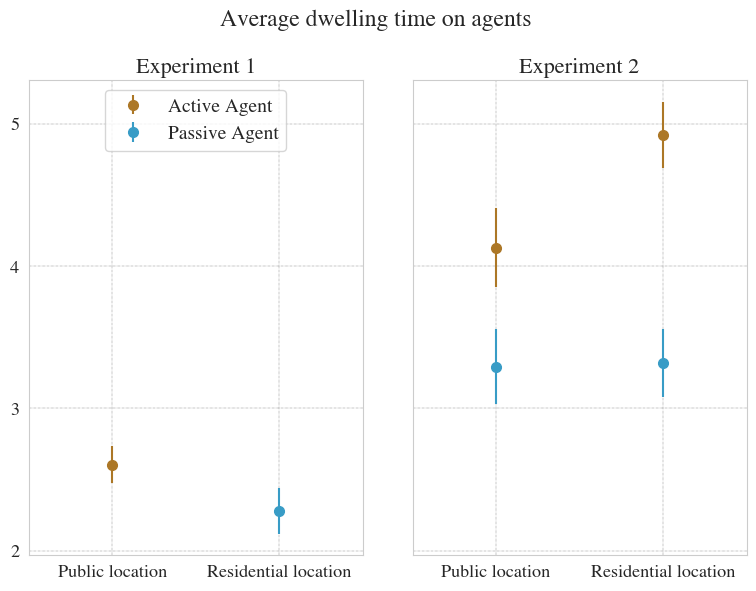

In [49]:
def plot_errorbar_agent(ax, data, y_col, yerr_col, color, label, linestyle=' '):
    ax.errorbar(x=data["Building_Category"], 
                y=data[y_col], 
                yerr=data[yerr_col], 
                fmt='o'+linestyle, color=color, 
                label=label, 
                markersize=7, capthick=20)

# Dictionary to streamline data selection
exp_data_agent = {
    "Experiment 1": {"Active Agent": Dwelling_data['Exp1_Active'], "Passive Agent": Dwelling_data['Exp1_Passive']},
    "Experiment 2": {"Active Agent": Dwelling_data['Exp2_Active'], "Passive Agent": Dwelling_data['Exp2_Passive']}
}


fig, axes = plt.subplots(1, 2, sharey=True, figsize=(8, 6))
fig.suptitle('Average dwelling time on agents \n', fontsize=17)
fig.tight_layout()

# Loop through the experiments and data, plotting as we go
for ax, (exp, datasets) in zip(axes, exp_data_agent.items()):
    for label, data in datasets.items():
        plot_errorbar_agent(ax, data, "Dwelling_Time_Agent_Gaze_mean", "Standard_error_building", Colors_Agent[label], label)
    
    ax.set_xlim((-0.5, 1.5))
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Public location", "Residential location"])
    ax.grid(True, color="grey", linewidth="0.3", linestyle="-.")
    ax.tick_params(axis='both', labelsize=13)
    ax.yaxis.get_label().set_fontsize(16)
    ax.set_title(exp, fontsize=16)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Move tight_layout to the end

axes[0].legend(loc="upper center", fontsize=14)

plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Dwelling_Agent.png",  bbox_inches="tight", pad_inches=0.3, transparent=True)



In [50]:
grouped.columns

Index(['Agent_Category', 'Building_Category', 'Dwelling_Time_Building_Gaze',
       'Dwelling_Time_Agent_Gaze', 'Building_Agent', 'Total_Dwelling_Time',
       'm'],
      dtype='object')

In [51]:
range(len(grouped))

range(0, 4)

In [52]:
Complete_Experiments_Building["Building_Category"]

0         Public
1    Residential
Name: Building_Category, dtype: object

In [53]:
Complete_Experiments_Building.head()

,Building_Category,Size,Dwelling_Time_Agent_Gaze_mean,Dwelling_Time_Agent_Gaze_median,Dwelling_Time_Agent_Gaze_std,Dwelling_Time_Building_Gaze_size,Dwelling_Time_Building_Gaze_mean,Dwelling_Time_Building_Gaze_median,Dwelling_Time_Building_Gaze_std,Standard_error_building,Standard_error_agent
0,Public,5859,3.068639,2.142727,3.074359,5859,12.319341,10.917938,8.424942,0.110067,0.040165
1,Residential,5875,3.035946,1.813873,3.367111,5875,13.389697,11.064775,9.011938,0.117575,0.043929


In [54]:
Complete_Experiments.groupby('Building_Category')[ "Dwelling_Time_Agent_Gaze"].mean()

Building_Category
Public         3.068639
Residential    3.035946
Name: Dwelling_Time_Agent_Gaze, dtype: float64

In [55]:
Complete_Experiments

,SubjectID,AbsolutError,SignedAngle-+180,IQR,RT,DistanceToParticipant,PointingTaskStartingLocations,TrialNumber,StartPointID,ID_for_StartingPosition,...,meaningfulBuilding,ImageName,Dwelling_Time_Building_Gaze,Fixation_Count_Building_Gaze,Dwelling_Time_Agent_Gaze,Fixation_Count_Agent_Gaze,Agent_Category,Building_Category,Congruent,Task
0,365,15.396716,15.396716,63.921884,25.825715,197.768723,21,1,1,1,...,Not meaningful,46_Sa,37.230251,186.0,3.428844,12.0,Passive,Residential,Incongruent,NaN
1,365,6.037733,-6.037733,63.921884,4.799789,213.475525,16,78,7,6,...,Not meaningful,46_SaNo,37.230251,186.0,3.428844,12.0,Passive,Residential,Incongruent,NaN
2,365,6.345290,6.345290,63.921884,4.638590,111.623512,13,88,8,4,...,Not meaningful,46_Sa,37.230251,186.0,3.428844,12.0,Passive,Residential,Incongruent,NaN
3,365,3.627752,3.627752,63.921884,2.361455,111.623512,13,95,8,11,...,Not meaningful,46_SaNo,37.230251,186.0,3.428844,12.0,Passive,Residential,Incongruent,NaN
4,365,19.115237,-19.115237,63.921884,5.975304,232.765823,8,131,11,11,...,Not meaningful,46_SaNo,37.230251,186.0,3.428844,12.0,Passive,Residential,Incongruent,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6037,9627,25.107282,25.107282,84.440034,10.522678,211.858734,17,76,10,4,...,NaN,35_CmANo_42,29.718960,157.0,1.161636,5.0,Passive,Public,Incongruent,Building
6038,9627,130.118920,-130.118920,84.440034,10.463158,393.332458,0,91,12,3,...,NaN,35_CmANo_42,29.718960,157.0,1.161636,5.0,Passive,Public,Incongruent,Building
6039,9627,10.057038,-10.057038,84.440034,10.115462,377.514496,6,168,21,8,...,NaN,35_CmA_42,29.718960,157.0,1.161636,5.0,Passive,Public,Incongruent,Building
6040,9627,35.396546,-35.396546,84.440034,20.014665,225.302216,17,75,10,3,...,NaN,05_CmAAct_05,2.599047,14.0,1.582242,8.0,Active,Public,Incongruent,Building


<Figure size 1500x500 with 0 Axes>

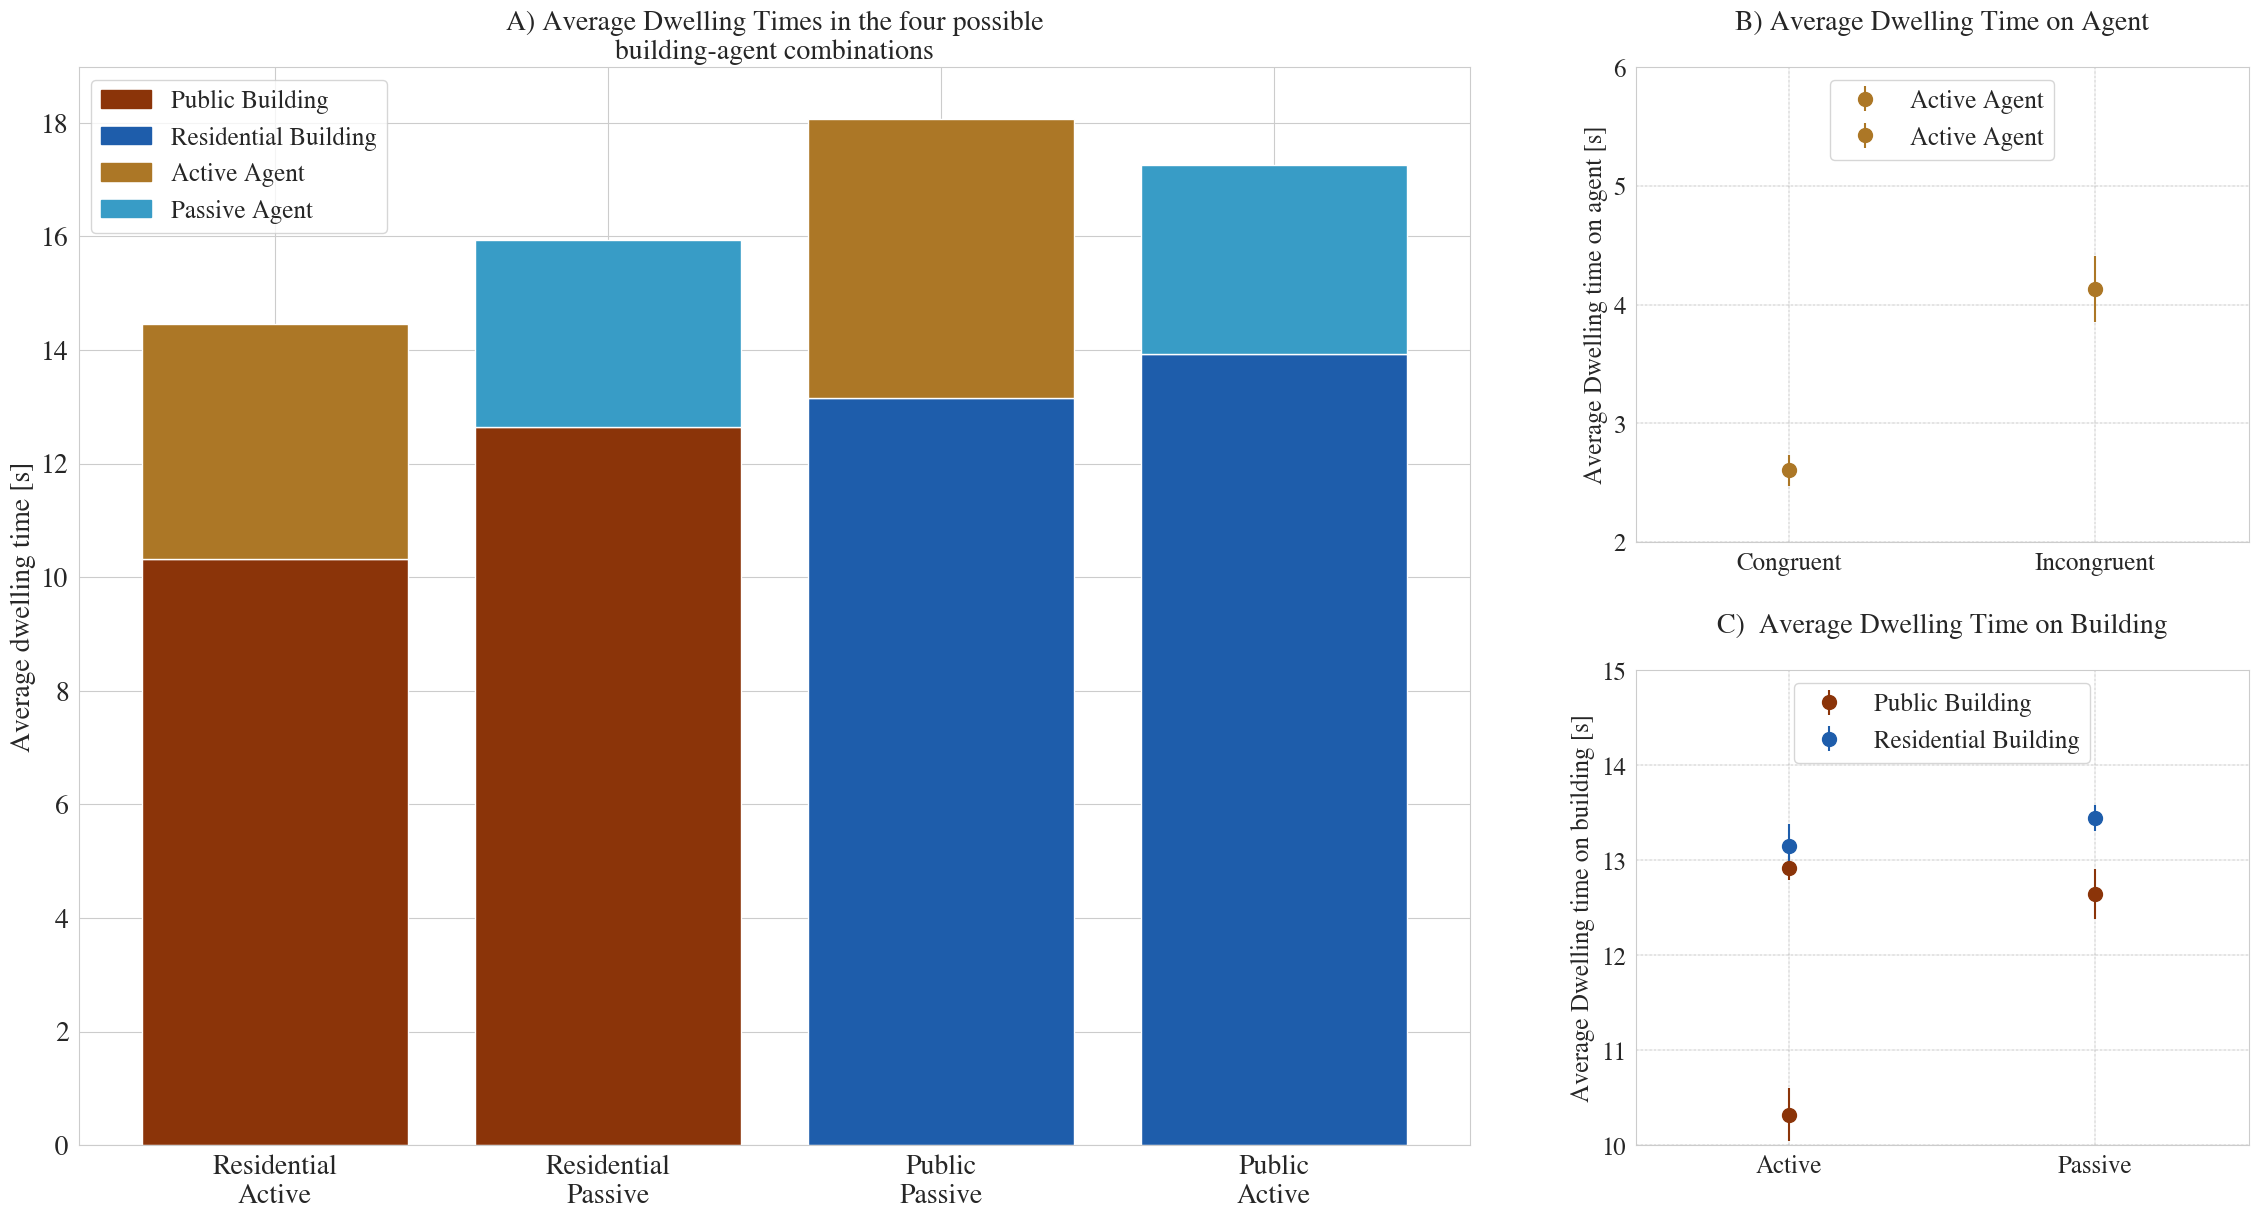

In [56]:
# Renamed what will be the labes for plot ax0
grouped['Building_Agent'] = ["Residential\nActive", "Residential\nPassive", "Public\nPassive", "Public\nActive"]

plt.tight_layout()
# Make all locators integers

# Define the position for the bars
bar_positions = range(len(grouped))

# Create a new figure
fig = plt.figure(figsize=(28, 14))
gs = gridspec.GridSpec(2, 3) # Define the grid structure
gs.update(wspace=0.27, hspace=0.27)

ax0 = fig.add_subplot(gs[0:2,0:2]) # Add the first plot

# Plot the data with the determined colors
ax0.bar(bar_positions, grouped['Dwelling_Time_Building_Gaze'], color=bottom_colors)
ax0.bar(bar_positions, grouped['Dwelling_Time_Agent_Gaze'], bottom=grouped['Dwelling_Time_Building_Gaze'], color=top_colors)

# Set the x-ticks and their labels
ax0.set_xticks(bar_positions)
ax0.set_xticklabels(grouped['Building_Agent'], rotation=0)
ax0.yaxis.set_major_locator(loc)
ax0.tick_params(axis='both', labelsize=20)
ax0.yaxis.get_label().set_fontsize(20)

# Add labels and title
#ax0.set_xlabel('Experimental buildings')
ax0.set_ylabel('Average dwelling time [s]')
ax0.set_title(' A) Average Dwelling Times in the four possible \nbuilding-agent combinations',  fontsize=20)

ax0.legend(handles=legend_elements, fontsize=18)



def configure_errorbar_plot(ax, data, title, x_col, y_col):
    for df, label in data:
        ax.errorbar(x=df[x_col], y=df[y_col],
                    yerr=df["Standard_error_building"], fmt='o', color=color_mapping[label], label=label, markersize=10, capthick=20)
    ax.set_title(title, fontsize=20)
    loc = plt.MaxNLocator(integer=True)
    ax.yaxis.set_major_locator(loc)
    ax.set_xlim((-0.5, 1.5))
    ax.grid(True, color="grey", linewidth="0.3", linestyle="-.")
    ax.tick_params(axis='both', labelsize=18)
    ax.yaxis.get_label().set_fontsize(18)
    ax.legend(loc="upper center")
    

# Add and configure subplots
ax1 = fig.add_subplot(gs[0, 2])
configure_errorbar_plot(ax1, [(Dwelling_data['Complete_Active'][Dwelling_data['Complete_Active'].Congruent == 1], 'Active Agent'), (Dwelling_data['Complete_Active'][Dwelling_data['Complete_Active'].Building_Category == "Public"], 'Active Agent')], 'B) Average Dwelling Time on Agent\n', "Congruent", "Dwelling_Time_Agent_Gaze_mean")
ax1.set_ylim((2,6))


ax2 = fig.add_subplot(gs[1, 2])
configure_errorbar_plot(ax2, [(Dwelling_data['Complete_Public'], 'Public Building'), (Dwelling_data['Complete_Residential'], 'Residential Building')], 'C)  Average Dwelling Time on Building\n', "Agent_Category", "Dwelling_Time_Building_Gaze_mean")
ax2.set_ylim((10,15))

axes_settings = {
    ax1: ("Average Dwelling time on agent [s]", "upper center"),
    ax2: ("Average Dwelling time on building [s]", "upper center")
}

for ax, (ylabel, legend_loc) in axes_settings.items():
    ax.set_ylabel(ylabel)
    ax.legend(loc=legend_loc, fontsize=18)

#plt.tight_layout()
plt.show()

In [57]:
Dwelling_data['Complete_Active'][Dwelling_data['Complete_Active'].Building_Category == "Public"]

,Congruent,Agent_Category,Building_Category,Size,Dwelling_Time_Agent_Gaze_mean,Dwelling_Time_Agent_Gaze_median,Dwelling_Time_Agent_Gaze_std,Dwelling_Time_Building_Gaze_size,Dwelling_Time_Building_Gaze_mean,Dwelling_Time_Building_Gaze_median,Dwelling_Time_Building_Gaze_std,Standard_error_building,Standard_error_agent
0,Congruent,Active,Public,3512,2.604499,1.985241,2.442510,3512,12.916917,11.553540,7.650570,0.129097,0.041215
1,Incongruent,Active,Public,1146,4.129808,2.798426,4.197928,1146,10.323296,8.520016,9.452156,0.279215,0.124006


In [58]:
Dwelling_data['Complete_Passive'][Dwelling_data['Complete_Passive'].Congruent == 0]

,Congruent,Agent_Category,Building_Category,Size,Dwelling_Time_Agent_Gaze_mean,Dwelling_Time_Agent_Gaze_median,Dwelling_Time_Agent_Gaze_std,Dwelling_Time_Building_Gaze_size,Dwelling_Time_Building_Gaze_mean,Dwelling_Time_Building_Gaze_median,Dwelling_Time_Building_Gaze_std,Standard_error_building,Standard_error_agent


In [59]:
display(Performance_Summary_Exp1)
display(Performance_Summary_Exp2)

,Agent_Category,Building_Category,Size,AbsolutError_mean,AbsolutError_median,AbsolutError_std,RT_size,RT_mean,RT_median,RT_std,Standard_error_performance
0,Active,Public,3512,48.193366,32.247369,45.996767,3512,8.053200,6.328460,5.648515,0.776158
1,Passive,Residential,3523,50.792242,38.306246,44.900851,3523,7.933089,6.191068,5.856689,0.756481


,Agent_Category,Building_Category,Size,AbsolutError_mean,AbsolutError_median,AbsolutError_std,RT_size,RT_mean,RT_median,RT_std,Standard_error_performance
0,Active,Public,1146,43.751607,29.373570,42.174452,1146,9.893194,8.080105,6.485053,1.245825
1,Active,Residential,1064,44.435104,34.678865,39.698918,1064,10.030491,8.630656,6.500696,1.217048
2,Passive,Public,1201,46.405384,31.578508,44.519734,1201,10.022075,8.180434,6.626463,1.284639
3,Passive,Residential,1288,52.428066,37.543785,45.786232,1288,9.635208,7.913469,6.629174,1.275783


### Performance

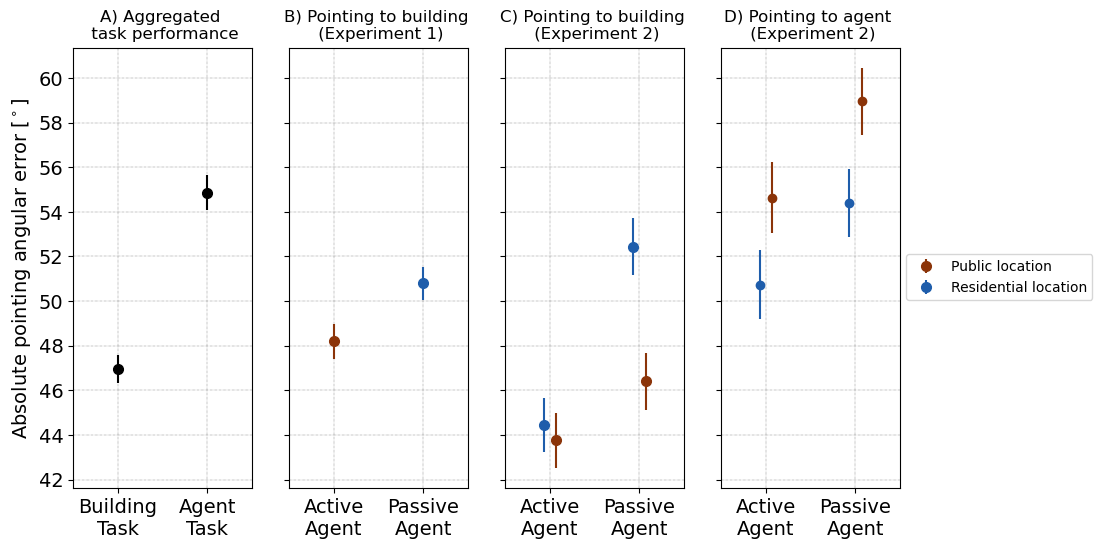

In [60]:
plt.style.use('default')
fig, axes = plt.subplots(1, 4, sharey=True,  figsize=(9, 5))
#fig.suptitle('Pointing task performance \n', fontsize=18)
fig.tight_layout()

#Building Vs Agent

axes[0].errorbar(x= SecondExp.iloc[1,0], y= SecondExp.iloc[1,3],yerr= SecondExp.iloc[1,6], color='#000000', markersize=7, capthick=20, fmt='o')
axes[0].errorbar(x= SecondExp.iloc[0,0], y= SecondExp.iloc[0,3],yerr= SecondExp.iloc[0,6], color='#000000', markersize=7, capthick=20, fmt='o')
axes[0].set_title('A) Aggregated \n task performance')
axes[0].set_ylabel("Absolute pointing angular error [$^\circ$]")


#Experiment 1
axes[1].errorbar( x=Performance['Exp1_Public']["Agent_Category"],y=Performance['Exp1_Public']["AbsolutError_mean"].values,
             yerr=Performance['Exp1_Public'].Standard_error_performance, fmt='o',  color= hex_codes[1], label= "Public location", markersize=7, capthick=20)
axes[1].errorbar( x=Performance['Exp1_Residential']["Agent_Category"],y=Performance['Exp1_Residential']["AbsolutError_mean"].values,
             yerr=(Performance['Exp1_Residential'].Standard_error_performance), fmt='o--',  color= hex_codes[-2], label= "Residential location", markersize=7, capthick=20)
axes[1].set_title('B) Pointing to building \n (Experiment 1)')


# Experiment 2 
x_positioner_p = np.arange(len(Performance['Exp2_Public']["Building_Category"]))
x_positioner_r = np.arange(len(Performance['Exp2_Residential']["Agent_Category"]))
offset = 0.07
          
axes[2].errorbar(x=x_positioner_p + offset,y=Performance['Exp2_Public']["AbsolutError_mean"].values, 
             yerr=Performance['Exp2_Public'].Standard_error_performance, fmt='o', color=  hex_codes[1], label= "Public location", markersize=7, capthick=20)
axes[2].errorbar(x=x_positioner_r - offset,y=Performance['Exp2_Residential']["AbsolutError_mean"].values, 
             yerr=Performance['Exp2_Residential'].Standard_error_performance, fmt='o', color=  hex_codes[-2],  label= "Residential location", markersize=7, capthick=20)
axes[2].set_title('C) Pointing to building \n (Experiment 2)')

# Pointing to agent

axes[3].errorbar(x=x_positioner_p + offset,y=Performance['Agent_Public']["AbsolutError_mean"].values, 
             yerr=Performance['Agent_Public'].Standard_error_performance, fmt='o', color=  hex_codes[1], label= "Public location")
axes[3].errorbar(x=x_positioner_r - offset,y=Performance['Agent_Residential']["AbsolutError_mean"].values, 
             yerr=Performance['Agent_Residential'].Standard_error_performance, fmt='o', color=  hex_codes[-2],  label= "Residential location")
axes[3].set_title('D) Pointing to agent \n (Experiment 2)')
axes[3].set_xlim((-0.5, 1.5))
for n, subplot in np.ndenumerate(axes):
    subplot.set_xlim((-0.5, 1.5))
    subplot.xaxis.set_major_locator(matplotlib.ticker.FixedLocator([0,1]))
    subplot.grid(True, color = "grey", linewidth = "0.3", linestyle = "-.")
    subplot.tick_params(axis='both', labelsize=14)
    subplot.set_xticklabels(labels=["Active\nAgent", "Passive\nAgent"], multialignment= "center")
    subplot.yaxis.get_label().set_fontsize(14)
    subplot.yaxis.set_major_locator(MaxNLocator(integer=True))
axes[0].set_xticklabels(labels=["Building\nTask", "Agent\nTask"], multialignment= "center")
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.97, 0.5))



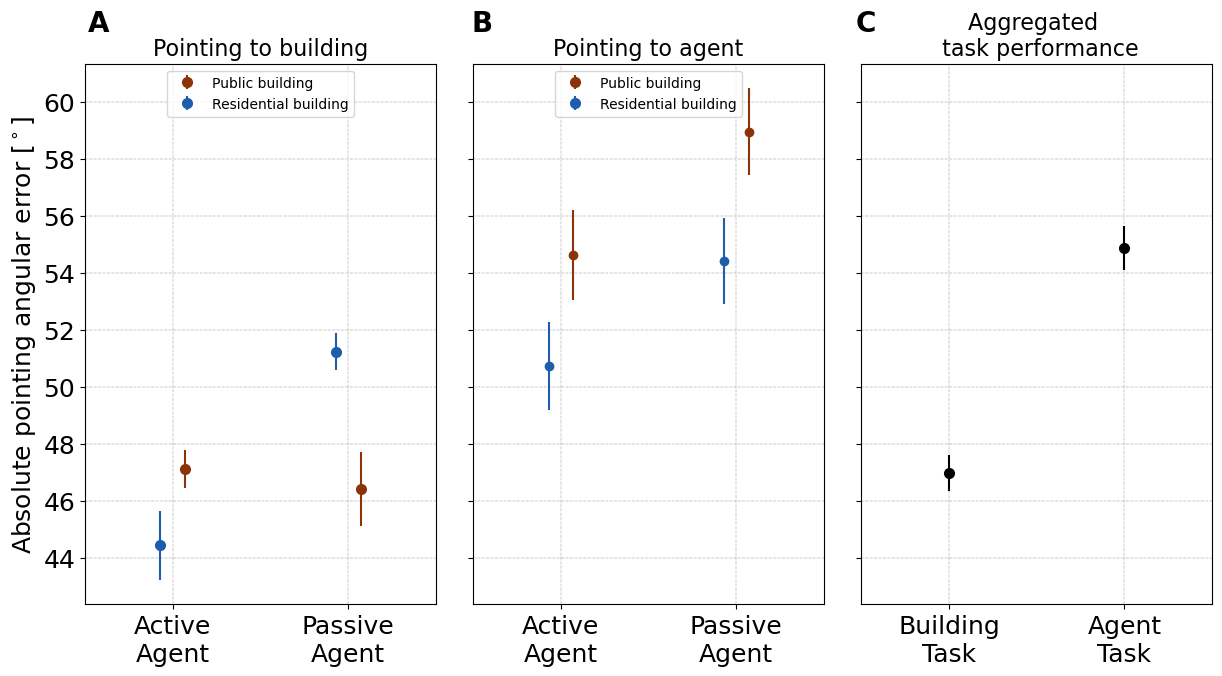

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

plt.style.use('default')
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12, 6))
fig.tight_layout()

# Complete Data
x_positioner_p = np.arange(len(Performance['Exp2_Public']["Building_Category"]))
x_positioner_r = np.arange(len(Performance['Exp2_Residential']["Agent_Category"]))
offset = 0.07

axes[0].errorbar(x=x_positioner_p + offset, y=Performance['Complete_Public']["AbsolutError_mean"].values, 
                 yerr=Performance['Complete_Public'].Standard_error_performance, fmt='o', color=hex_codes[1], label="Public location", markersize=7, capthick=20)
axes[0].errorbar(x=x_positioner_r - offset, y=Performance['Complete_Residential']["AbsolutError_mean"].values, 
                 yerr=Performance['Complete_Residential'].Standard_error_performance, fmt='o', color=hex_codes[-2], label="Residential location", markersize=7, capthick=20)
axes[0].set_title('Pointing to building',  fontsize=16)
# Move legend to the first plot
handles, labels = axes[0].get_legend_handles_labels()

labels =['Public building', 'Residential building']

axes[0].legend(handles, labels, loc='upper center')
axes[0].set_ylabel("Absolute pointing angular error [$^\circ$]",  fontsize=20)

# Pointing to agent
axes[1].errorbar(x=x_positioner_p + offset, y=Performance['Agent_Public']["AbsolutError_mean"].values, 
                 yerr=Performance['Agent_Public'].Standard_error_performance, fmt='o', color=hex_codes[1])
axes[1].errorbar(x=x_positioner_r - offset, y=Performance['Agent_Residential']["AbsolutError_mean"].values, 
                 yerr=Performance['Agent_Residential'].Standard_error_performance, fmt='o', color=hex_codes[-2])
axes[1].set_title('Pointing to agent',  fontsize=16)
axes[1].set_xlim((-0.5, 1.5))
axes[1].legend(handles, labels, loc='upper center')

# Building Vs Agent (now moved to the last)
axes[2].errorbar(x=SecondExp.iloc[1,0], y=SecondExp.iloc[1,3], yerr=SecondExp.iloc[1,6], color='#000000', markersize=7, capthick=20, fmt='o')
axes[2].errorbar(x=SecondExp.iloc[0,0], y=SecondExp.iloc[0,3], yerr=SecondExp.iloc[0,6], color='#000000', markersize=7, capthick=20, fmt='o')
axes[2].set_title('Aggregated \n task performance',  fontsize=16)


for n, subplot in np.ndenumerate(axes):
    subplot.set_xlim((-0.5, 1.5))
    subplot.xaxis.set_major_locator(matplotlib.ticker.FixedLocator([0, 1]))
    subplot.grid(True, color="grey", linewidth="0.3", linestyle="-.")
    subplot.tick_params(axis='both', labelsize=18)
    subplot.set_xticklabels(labels=["Active\nAgent", "Passive\nAgent"], multialignment="center")
    subplot.yaxis.get_label().set_fontsize(18)
    subplot.yaxis.set_major_locator(MaxNLocator(integer=True))
axes[2].set_xticklabels(labels=["Building\nTask", "Agent\nTask"], multialignment="center")

annotations = {
    'A': (0.05, 1.02),
    'B': (0.37, 1.02),
    'C': (0.69, 1.02),
}

for text, location in annotations.items():
    fig.text(location[0], location[1], text, fontsize=20, fontweight='bold', fontfamily='sans-serif', ha='center')
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Absolut_Error_OneStandard_3plots.png", bbox_inches="tight", pad_inches=0.3)


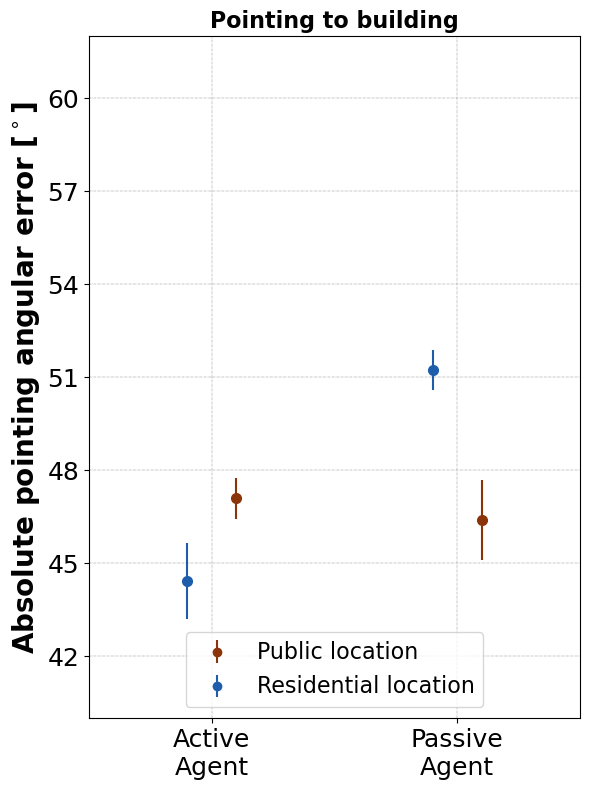

In [82]:

import matplotlib.ticker as ticker

# Create a new figure for the first plot (Pointing to building)
fig1, ax1 = plt.subplots(figsize=(6, 8))

# Plot data for 'Pointing to building'
ax1.errorbar(x=x_positioner_p + offset, y=Performance['Complete_Public']["AbsolutError_mean"].values, 
             yerr=Performance['Complete_Public'].Standard_error_performance, fmt='o', color=hex_codes[1], label="Public location", markersize=7, capthick=20)
ax1.errorbar(x=x_positioner_r - offset, y=Performance['Complete_Residential']["AbsolutError_mean"].values, 
             yerr=Performance['Complete_Residential'].Standard_error_performance, fmt='o', color=hex_codes[-2], label="Residential location", markersize=7, capthick=20)
ax1.set_title('Pointing to building', fontsize=16, fontweight='bold')
ax1.set_ylabel("Absolute pointing angular error [$^\circ$]", fontsize=20, fontweight='bold')
ax1.legend(handles, labels, loc='lower center', fontsize=16)
# Set y-axis limits to 40-65 for consistency
ax1.set_ylim(40, 62)

# Shared y-axis format
ax1.set_xlim((-0.5, 1.5))
ax1.xaxis.set_major_locator(ticker.FixedLocator([0, 1]))
ax1.grid(True, color="grey", linewidth="0.3", linestyle="-.")
ax1.tick_params(axis='both', labelsize=18)
ax1.set_xticklabels(labels=["Active\nAgent", "Passive\nAgent"], multialignment="center", fontsize=18)
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))

# Save the figure for Plot 1
plt.tight_layout()
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Absolut_Error_Pointing_Building.jpg", bbox_inches="tight", pad_inches=0.1,  dpi=300, format='jpg')
plt.show()


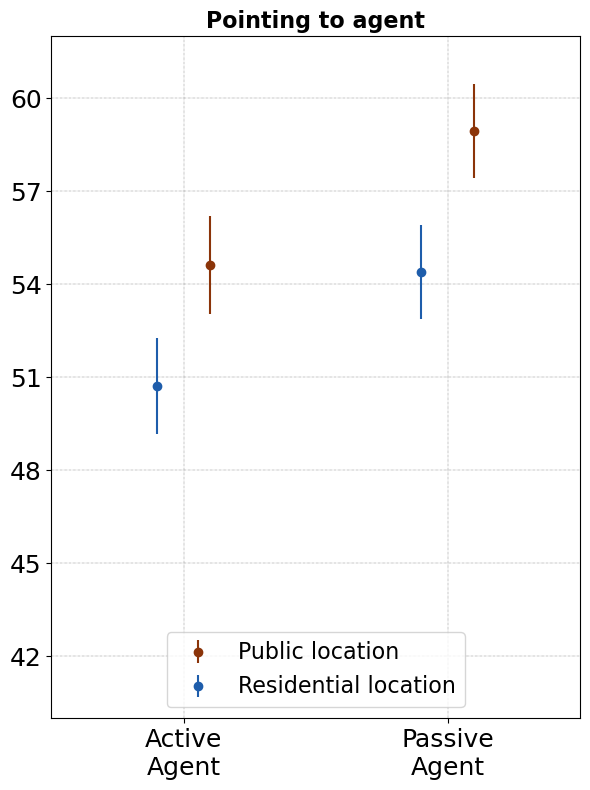

In [84]:
# Create a new figure for the second plot (Pointing to agent)
fig2, ax2 = plt.subplots(figsize=(6, 8))

# Plot data for 'Pointing to agent'
ax2.errorbar(x=x_positioner_p + offset, y=Performance['Agent_Public']["AbsolutError_mean"].values, 
             yerr=Performance['Agent_Public'].Standard_error_performance, fmt='o', color=hex_codes[1])
ax2.errorbar(x=x_positioner_r - offset, y=Performance['Agent_Residential']["AbsolutError_mean"].values, 
             yerr=Performance['Agent_Residential'].Standard_error_performance, fmt='o', color=hex_codes[-2])
ax2.set_title('Pointing to agent', fontsize=16, fontweight='bold')
ax2.legend(handles, labels, fontsize=16, loc='lower center')

# Set y-axis limits to 40-65 for consistency
ax2.set_ylim(40, 62)

# Shared y-axis format
ax2.set_xlim((-0.5, 1.5))
ax2.xaxis.set_major_locator(ticker.FixedLocator([0, 1]))
ax2.grid(True, color="grey", linewidth="0.3", linestyle="-.")
ax2.tick_params(axis='both', labelsize=18)
ax2.set_xticklabels(labels=["Active\nAgent", "Passive\nAgent"], multialignment="center", fontsize=18)
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

# Save the figure for Plot 2
plt.tight_layout()
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Absolut_Error_Pointing_Agent.jpg", bbox_inches="tight", pad_inches=0.1,  dpi=300, format='jpg')
plt.show()


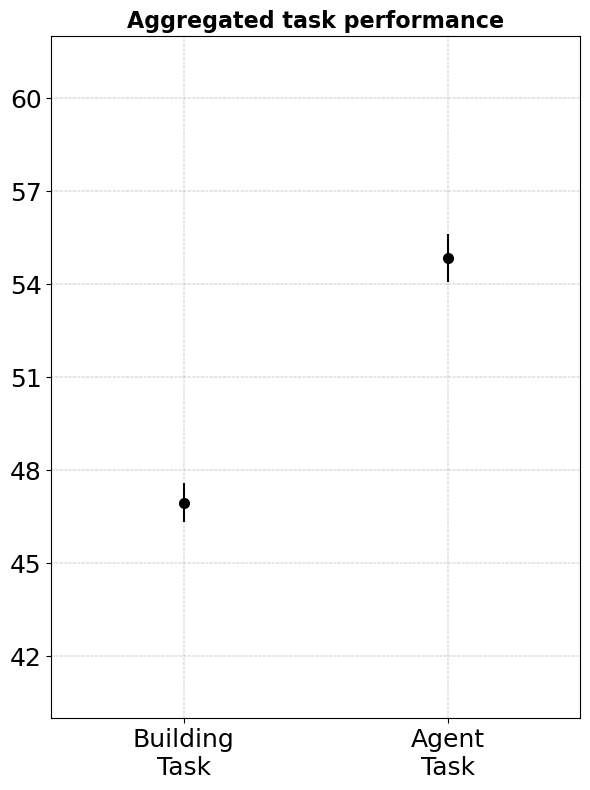

In [85]:
# Create a new figure for the third plot (Aggregated task performance)
fig3, ax3 = plt.subplots(figsize=(6, 8))

# Plot data for 'Aggregated task performance'
ax3.errorbar(x=SecondExp.iloc[1, 0], y=SecondExp.iloc[1, 3], yerr=SecondExp.iloc[1, 6], color='#000000', markersize=7, capthick=20, fmt='o')
ax3.errorbar(x=SecondExp.iloc[0, 0], y=SecondExp.iloc[0, 3], yerr=SecondExp.iloc[0, 6], color='#000000', markersize=7, capthick=20, fmt='o')
ax3.set_title('Aggregated task performance', fontsize=16, fontweight='bold')

# Set y-axis limits to 40-65 for consistency
ax3.set_ylim(40, 62)

# Shared y-axis format
ax3.set_xlim((-0.5, 1.5))
ax3.xaxis.set_major_locator(ticker.FixedLocator([0, 1]))
ax3.grid(True, color="grey", linewidth="0.3", linestyle="-.")
ax3.tick_params(axis='both', labelsize=18)
ax3.set_xticklabels(labels=["Building\nTask", "Agent\nTask"], multialignment="center", fontsize=18)
ax3.yaxis.set_major_locator(MaxNLocator(integer=True))

# Save the figure for Plot 3
plt.tight_layout()
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Absolut_Error_Aggregated_Performance.jpg", bbox_inches="tight", pad_inches=0.1,  dpi=300, format='jpg')
plt.show()


In [65]:
labels

['Public building', 'Residential building']

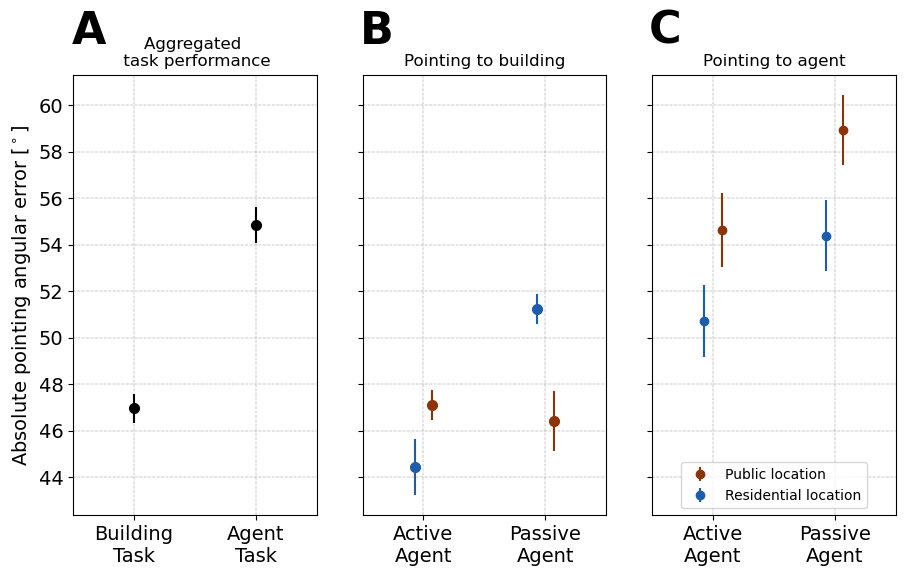

In [66]:
plt.style.use('default')
fig, axes = plt.subplots(1, 3, sharey=True,  figsize=(9, 5))
#fig.suptitle('Pointing task performance \n', fontsize=18)
fig.tight_layout()

#Building Vs Agent

axes[0].errorbar(x= SecondExp.iloc[1,0], y= SecondExp.iloc[1,3],yerr= SecondExp.iloc[1,6], color='#000000', markersize=7, capthick=20, fmt='o')
axes[0].errorbar(x= SecondExp.iloc[0,0], y= SecondExp.iloc[0,3],yerr= SecondExp.iloc[0,6], color='#000000', markersize=7, capthick=20, fmt='o')
axes[0].set_title('Aggregated \n task performance')
axes[0].set_ylabel("Absolute pointing angular error [$^\circ$]")


# Complete Data
x_positioner_p = np.arange(len(Performance['Exp2_Public']["Building_Category"]))
x_positioner_r = np.arange(len(Performance['Exp2_Residential']["Agent_Category"]))
offset = 0.07
          
axes[1].errorbar(x=x_positioner_p + offset,y=Performance['Complete_Public']["AbsolutError_mean"].values, 
             yerr=Performance['Complete_Public'].Standard_error_performance, fmt='o', color=  hex_codes[1], label= "Public location", markersize=7, capthick=20)
axes[1].errorbar(x=x_positioner_r - offset,y=Performance['Complete_Residential']["AbsolutError_mean"].values, 
             yerr=Performance['Complete_Residential'].Standard_error_performance, fmt='o', color=  hex_codes[-2],  label= "Residential location", markersize=7, capthick=20)
axes[1].set_title('Pointing to building')

# Pointing to agent

axes[2].errorbar(x=x_positioner_p + offset,y=Performance['Agent_Public']["AbsolutError_mean"].values, 
             yerr=Performance['Agent_Public'].Standard_error_performance, fmt='o', color=  hex_codes[1], label= "Public location")
axes[2].errorbar(x=x_positioner_r - offset,y=Performance['Agent_Residential']["AbsolutError_mean"].values, 
             yerr=Performance['Agent_Residential'].Standard_error_performance, fmt='o', color=  hex_codes[-2],  label= "Residential location")
axes[2].set_title('Pointing to agent')
axes[2].set_xlim((-0.5, 1.5))
for n, subplot in np.ndenumerate(axes):
    subplot.set_xlim((-0.5, 1.5))
    subplot.xaxis.set_major_locator(matplotlib.ticker.FixedLocator([0,1]))
    subplot.grid(True, color = "grey", linewidth = "0.3", linestyle = "-.")
    subplot.tick_params(axis='both', labelsize=14)
    subplot.set_xticklabels(labels=["Active\nAgent", "Passive\nAgent"], multialignment= "center")
    subplot.yaxis.get_label().set_fontsize(14)
    subplot.yaxis.set_major_locator(MaxNLocator(integer=True))
axes[0].set_xticklabels(labels=["Building\nTask", "Agent\nTask"], multialignment= "center")
handles, labels = axes[2].get_legend_handles_labels()
axes[2].legend(handles, labels, loc='lower center')

annotations = {
    'A': (0.07,1.02),
    'B': (0.39, 1.02),
    'C': (0.71, 1.02),
    
    # Add more annotations as needed
}

# Loop through annotations and add them to the figure
for text, location in annotations.items():
    fig.text(location[0], location[1], text, fontsize=32, fontweight='bold', fontfamily='sans-serif', ha='center')
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Absolut_Error_OneStandard_3plots.png",  bbox_inches="tight",
            pad_inches=0.3)#transparent=True

In [67]:
hex_codes[-2]


array([0.117003, 0.365049, 0.671962, 1.      ])

In [68]:
categories = {
    'Building': 'Task',
    'Agent': 'Task',
}

Datasets = {
    'Complete_Exp2': SecondExp,
}

Complete_Exp2 = {}

for exp_name, df in Datasets.items():
    for cat_name, col_name in categories.items():
        key = f"{exp_name}_{cat_name}"
        Complete_Exp2[key] = df[df[col_name] == cat_name]
        

In [69]:
for index, row in Performance['Exp2_Public'].iterrows():
    print(row)

Agent_Category                   Active
Building_Category                Public
Size                               1146
AbsolutError_mean             43.751607
AbsolutError_median            29.37357
AbsolutError_std              42.174452
RT_size                            1146
RT_mean                        9.893194
RT_median                      8.080105
RT_std                         6.485053
Standard_error_performance     1.245825
Name: 0, dtype: object
Agent_Category                  Passive
Building_Category                Public
Size                               1201
AbsolutError_mean             46.405384
AbsolutError_median           31.578508
AbsolutError_std              44.519734
RT_size                            1201
RT_mean                       10.022075
RT_median                      8.180434
RT_std                         6.626463
Standard_error_performance     1.284639
Name: 2, dtype: object


In [70]:
Performance['Exp1_Public']

,Agent_Category,Building_Category,Size,AbsolutError_mean,AbsolutError_median,AbsolutError_std,RT_size,RT_mean,RT_median,RT_std,Standard_error_performance
0,Active,Public,3512,48.193366,32.247369,45.996767,3512,8.0532,6.32846,5.648515,0.776158


In [71]:
for element in np.arange(len(Performance['Agent_Public']["Agent_Category"])): 
    print(element)

0
1


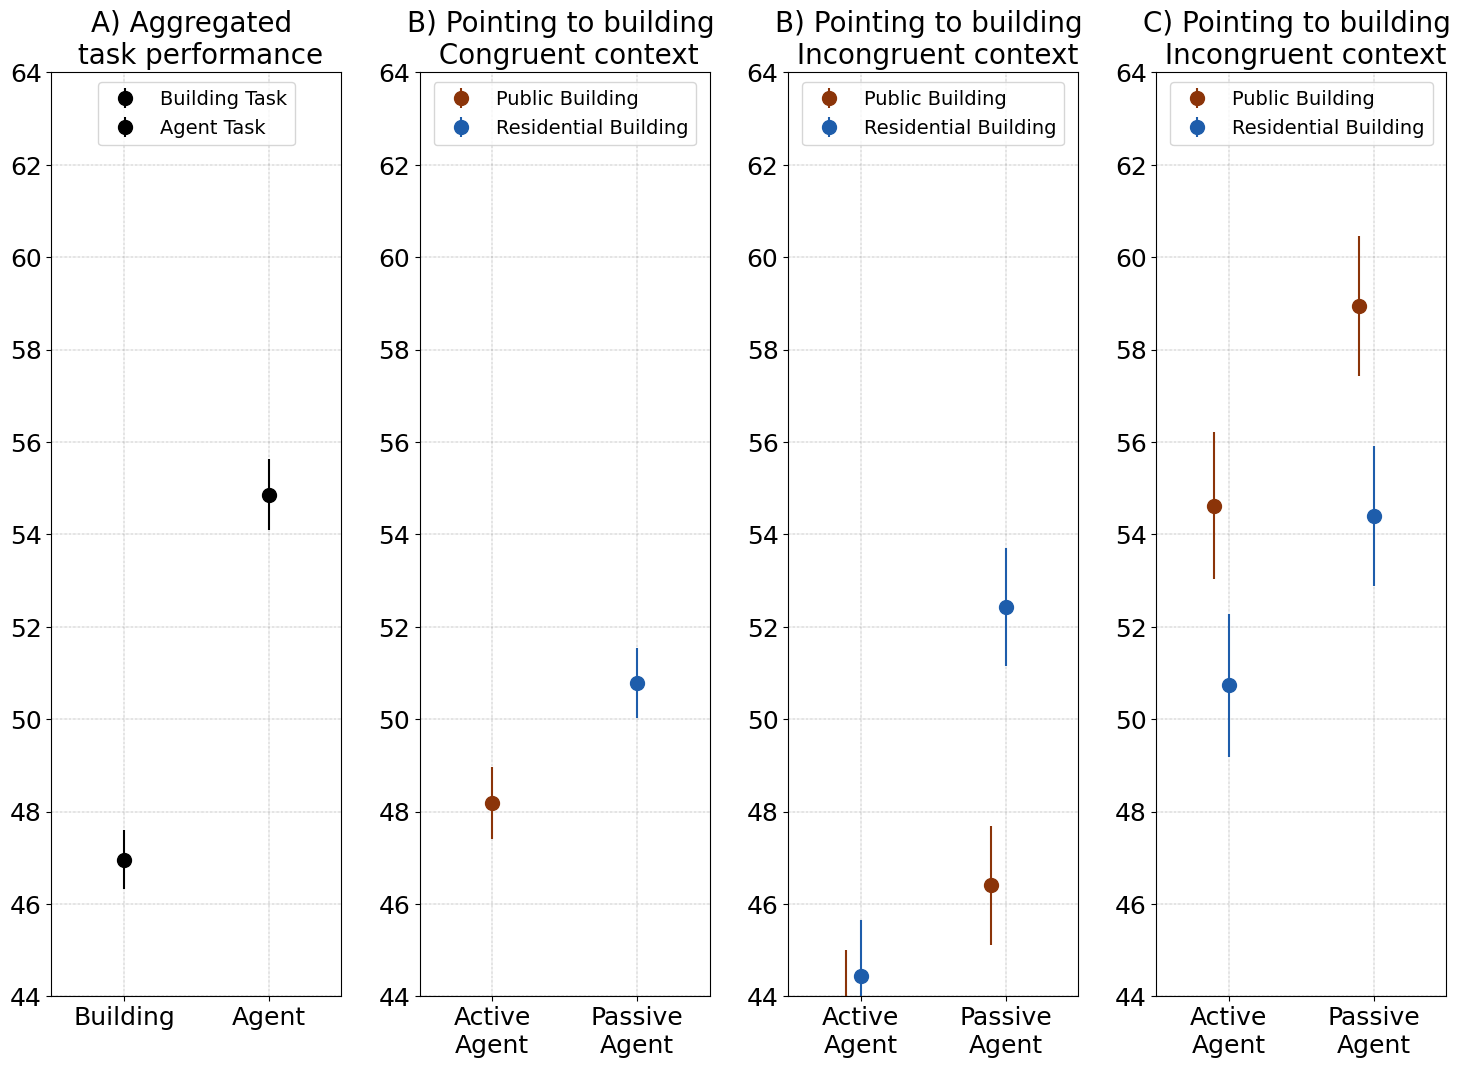

In [72]:
offset = 0.1  # Define the offset

def configure_errorbar_plotP(ax, data, title, x_col, y_col):
    # Create a mapping from categories to numerical values
    unique_categories = np.unique(np.concatenate([df[x_col] for df, _ in data]))
    category_to_number = {category: i for i, category in enumerate(unique_categories)}
    
    for i, (df, label) in enumerate(data):
        df.reset_index(inplace=True, drop=True)
        if len(df[x_col]) == 2:
            # Map categories to numbers and apply the offset
            numerical_x = df[x_col].map(category_to_number) + (i - len(data) / 2) * offset
            # Now plot each point with the adjusted x value
            ax.errorbar(x=numerical_x, y=df[y_col], yerr=df["Standard_error_performance"], fmt='o',
                        color=color_mapping.get(label, 'default_color'), label=label, 
                        markersize=10, capthick=2)
        else: 
            ax.errorbar(x=df[x_col], y=df[y_col], yerr=df["Standard_error_performance"], fmt='o',
                        color=color_mapping.get(label, 'default_color'), label=label, 
                        markersize=10, capthick=2)
        # Set up the rest of the plot
    ax.set_title(title, fontsize=20)
    loc = plt.MaxNLocator(integer=True)
    ax.yaxis.set_major_locator(loc)
    ax.set_xlim((-0.5, 1.5))
    ax.set_ylim((44, 64))
    ax.grid(True, color="grey", linewidth="0.3", linestyle="-.")
    ax.tick_params(axis='both', which='both', labelsize=18)
    ax.yaxis.get_label().set_fontsize(18)
    ax.legend(loc='upper center', fontsize=14)

    
# Create a new figure
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(1, 4) # Define the grid structure
gs.update(wspace=0.27, hspace=0.27)

ax0 = fig.add_subplot(gs[0, 0])
configure_errorbar_plotP(ax0, [(Complete_Exp2['Complete_Exp2_Building'], 'Building Task'), (Complete_Exp2['Complete_Exp2_Agent'], 'Agent Task')], 'A) Aggregated \n task performance', "Task", "mean")

ax1 = fig.add_subplot(gs[0, 1], sharey=ax0)
configure_errorbar_plotP(ax1, [(Performance['Exp1_Public'], 'Public Building'), (Performance['Exp1_Residential'], 'Residential Building')], 'B) Pointing to building \n Congruent context', "Agent_Category", "AbsolutError_mean")

ax2 = fig.add_subplot(gs[0, 2], sharey=ax0)
x_positioner_p = np.arange(len(Performance['Exp2_Public']["Agent_Category"]))
configure_errorbar_plotP(ax2, [(Performance['Exp2_Public'], 'Public Building'), (Performance['Exp2_Residential'], 'Residential Building')], 'B) Pointing to building \n Incongruent context', "Agent_Category", "AbsolutError_mean")

ax3 = fig.add_subplot(gs[0, 3], sharey=ax0)
configure_errorbar_plotP(ax3, [(Performance['Agent_Public'], 'Public Building'), (Performance['Agent_Residential'], 'Residential Building')], 'C) Pointing to building \n Incongruent context', "Agent_Category", "AbsolutError_mean")

for n, subplot in np.ndenumerate([ax1, ax2, ax3]):
    subplot.set_xticks([0,1])
    subplot.set_xticklabels( labels=["Active\nAgent", "Passive\nAgent"], multialignment= "center")
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Absolut_Error_OneStandard_3plots.png",  bbox_inches="tight",
            pad_inches=0.3, transparent=True)
plt.show()

In [73]:
Performance['Exp2_Public']

,Agent_Category,Building_Category,Size,AbsolutError_mean,AbsolutError_median,AbsolutError_std,RT_size,RT_mean,RT_median,RT_std,Standard_error_performance
0,Active,Public,1146,43.751607,29.373570,42.174452,1146,9.893194,8.080105,6.485053,1.245825
1,Passive,Public,1201,46.405384,31.578508,44.519734,1201,10.022075,8.180434,6.626463,1.284639


In [74]:
# Load data
Complete_model = pd.read_csv("/Volumes/TwoTeras/Resources/Complete_model.csv")
Complete_model_Agent = pd.read_csv("/Volumes/TwoTeras/Resources/Complete_model_Agent.csv")

In [75]:
Complete_model_Agent

,Unnamed: 0,term,Estimate,Std. Error,df,t value,Pr(>|t|)
0,1,(Intercept),55.836930,3.426626,59.890665,16.295019,0.000000
1,2,Dwelling_Time_Building_Gaze,-0.001095,0.090251,3335.199460,-0.012130,0.990322
2,3,Dwelling_Time_Agent_Gaze,-0.417831,0.241061,1580.448389,-1.733301,0.083237
3,4,ContextEffect,3.973129,1.531235,3329.102418,2.594721,0.009508
4,5,Agent_Action_level,-4.198907,1.539935,3331.502654,-2.726678,0.006431
5,6,ContextEffect:Agent_Action_level,-1.249679,3.030775,3322.610169,-0.412330,0.680124


In [76]:
# Load data
Complete_model = pd.read_csv("/Volumes/TwoTeras/Resources/Complete_model.csv")
Complete_model_Agent = pd.read_csv("/Volumes/TwoTeras/Resources/Complete_model_Agent.csv")

# Add 'term' column
Complete_model['term'] = ["Intercept", "Dwelling time on task Building", "Dwelling time on agent",
                          "Building (Residential vs. Public)", "Agent category (Passive vs. Active)", "Congruency (Incongruent vs. Congruent)",
                           "Interaction LocationxAgent"]
Complete_model_Agent['term'] = ["Intercept", "Dwelling time on task Building", "Dwelling time on agent",
                                "Building (Residential vs. Public)", "Agent category (Passive vs. Active)", 
                                "Interaction LocationxAgent"]

# Rename columns
Complete_model.rename({'term': 'Factor', "Std. Error": "Standard_Error"}, axis=1, inplace=True)
Complete_model_Agent.rename({'term': 'Factor', "Std. Error": "Standard_Error"}, axis=1, inplace=True)

# Remove intercept
Complete_model = Complete_model[Complete_model['Factor'] != 'Intercept']
Complete_model_Agent = Complete_model_Agent[Complete_model_Agent['Factor'] != 'Intercept']

# Add significance annotations
def annotate_significance(df):
    df["Significance"] = np.where(df["Pr(>|t|)"] < 0.001, "***", 
                                  np.where(df["Pr(>|t|)"] < 0.01, "**", 
                                           np.where(df["Pr(>|t|)"] < 0.05, "*", " ")))
    df["Anotate"] = df["Estimate"].round(2).astype(str) + df["Significance"]
    return df

Complete_model = annotate_significance(Complete_model)
Complete_model_Agent = annotate_significance(Complete_model_Agent)

# Align both dataframes by their Factor names
Complete_model.set_index('Factor', inplace=True)
Complete_model_Agent.set_index('Factor', inplace=True)

# Combine dataframes to align factors
aligned_factors = pd.DataFrame(index=Complete_model.index.union(Complete_model_Agent.index))
Complete_model = aligned_factors.join(Complete_model, how='left')
Complete_model_Agent = aligned_factors.join(Complete_model_Agent, how='left')

# Reset index to use 'Factor' as a column
Complete_model.reset_index(inplace=True)
Complete_model_Agent.reset_index(inplace=True)


In [77]:
Complete_model.Factor.unique()

array(['Agent category (Passive vs. Active)',
       'Building (Residential vs. Public)',
       'Congruency (Incongruent vs. Congruent)', 'Dwelling time on agent',
       'Dwelling time on task Building', 'Interaction LocationxAgent'],
      dtype=object)

/var/folders/3p/lxg47mnx0ks_st66vkzkx1640000gn/T/ipykernel_9208/41058318.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


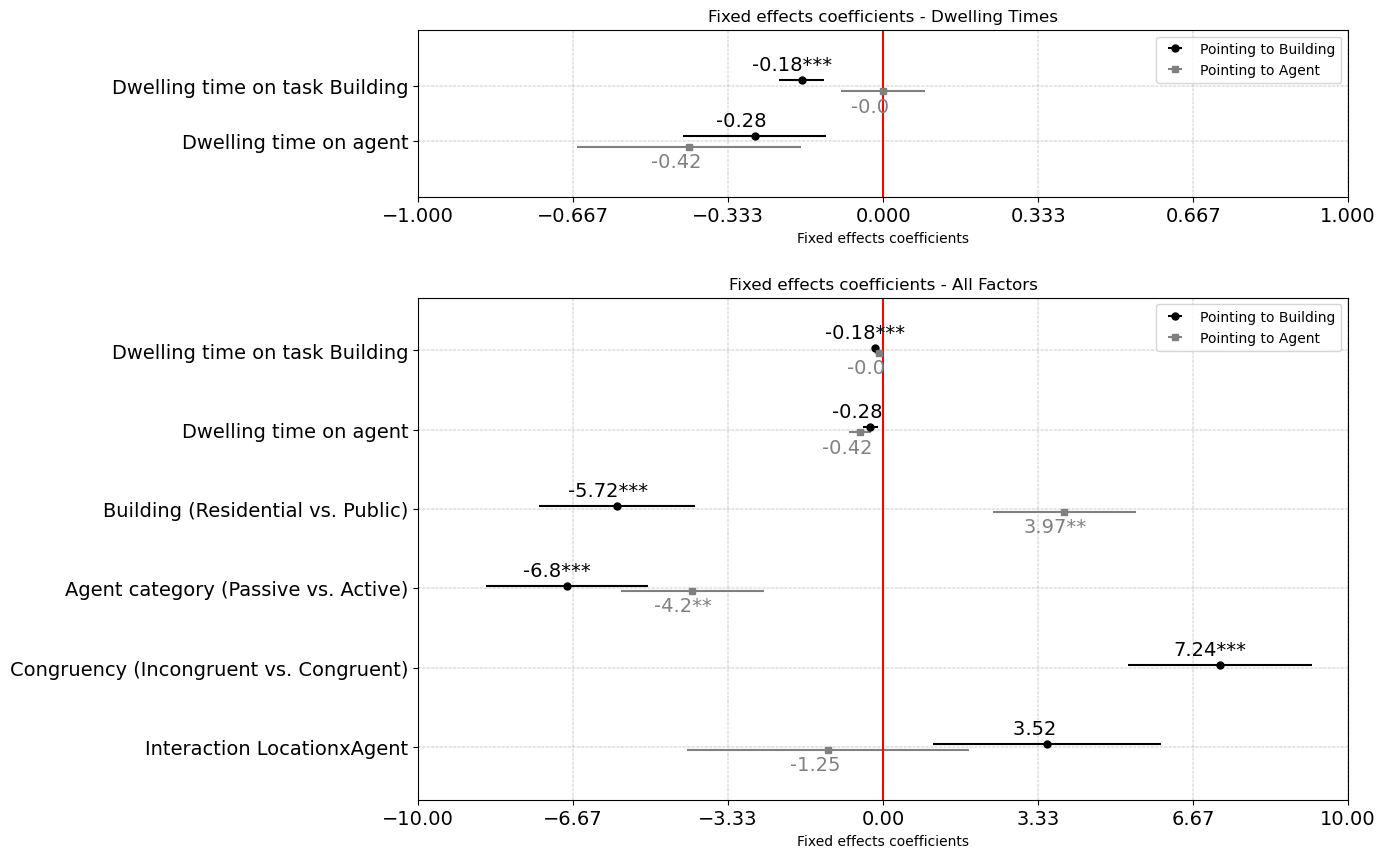

In [86]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

# Specify the order of factors
factor_order = ["Dwelling time on task Building", "Dwelling time on agent",
                          "Building (Residential vs. Public)", "Agent category (Passive vs. Active)", 
                          "Congruency (Incongruent vs. Congruent)", "Interaction LocationxAgent"][::-1]

# Reorder the dataframes based on the specified order
Complete_model = Complete_model.set_index('Factor').loc[factor_order].reset_index()
Complete_model_Agent = Complete_model_Agent.set_index('Factor').loc[factor_order].reset_index()

# Adding jitter to x-values of the agent model
x_jitter = 0.1
x_values_model_1 = Complete_model["Estimate"]
x_values_model_2 = Complete_model_Agent["Estimate"] + np.random.uniform(-x_jitter, x_jitter, size=len(Complete_model_Agent))

# Filter for dwelling times
dwelling_factors = ["Dwelling time on task Building", "Dwelling time on agent"]
Complete_model_dwelling = Complete_model[Complete_model['Factor'].isin(dwelling_factors)]
Complete_model_Agent_dwelling = Complete_model_Agent[Complete_model_Agent['Factor'].isin(dwelling_factors)]

# Create a custom grid layout
fig = plt.figure(figsize=(12, 10))
gs = GridSpec(2, 1, height_ratios=[2, 6], hspace=0.3)  # Increased hspace for more space between plots

# Adding y-axis jitter
y_jitter = 0.1
y_positions = np.arange(len(factor_order)) * 3  # Increase space between y-ticks
y_positions_model_1 = y_positions + y_jitter
y_positions_model_2 = y_positions - y_jitter 

# Center y-ticks and plotted dots for the top plot
dwelling_y_positions = np.array([1, 2])  # Manually adjusted y positions for centering
dwelling_y_positions_model_1 = dwelling_y_positions + y_jitter 
dwelling_y_positions_model_2 = dwelling_y_positions - y_jitter 

# Define x-tick positions
x_ticks_all_factors = np.linspace(-10, 10, 7)
x_ticks_dwelling_times = np.linspace(-1, 1, 7)

# Plotting only dwelling times in the first panel
ax0 = fig.add_subplot(gs[0])
ax0.errorbar(x=Complete_model_dwelling["Estimate"], y=dwelling_y_positions_model_1,
             xerr=Complete_model_dwelling["Standard_Error"], fmt='o', color='black', markersize=5, label='Pointing to Building')
ax0.errorbar(x=Complete_model_Agent_dwelling["Estimate"], y=dwelling_y_positions_model_2,
             xerr=Complete_model_Agent_dwelling["Standard_Error"], fmt='s', color='Gray', markersize=5, label='Pointing to Agent')

# Annotate each point with the "Anotate" values for both models in the first panel
for xi, yi, annotation in zip(Complete_model_dwelling["Estimate"], dwelling_y_positions_model_1, Complete_model_dwelling["Anotate"]):
    ax0.annotate(annotation, (xi, yi), textcoords="offset points", xytext=(-7, 7), ha='center', fontsize=14, color='black')
for xi, yi, annotation in zip(Complete_model_Agent_dwelling["Estimate"], dwelling_y_positions_model_2, Complete_model_Agent_dwelling["Anotate"]):
    ax0.annotate(annotation, (xi, yi), textcoords="offset points", xytext=(-7, -15), ha='center', fontsize=14, color='Gray')

# Adding grid lines and vertical red line at x=0 in the first panel
ax0.grid(True, color="grey", linewidth=0.3, linestyle="-.")
ax0.axvline(x=0, color='r')

# Set y-ticks to be the factor names in the middle of the jittered positions for the first panel
ax0.set_yticks(dwelling_y_positions)
ax0.set_yticklabels(dwelling_factors[::-1])  # Reverse the order of y-tick labels

# Set ylim to add extra space before the first and after the last y-tick
ax0.set_ylim([dwelling_y_positions[0] - 1, dwelling_y_positions[-1] + 1])

# Set labels and title for the first panel
ax0.set_xlabel(r"Fixed effects coefficients")
ax0.set_title(r'Fixed effects coefficients - Dwelling Times')
ax0.set_xlim((-1, 1))  # Adjust the x-axis range for the first panel
ax0.set_xticks(x_ticks_dwelling_times)  # Set x-ticks for dwelling times
ax0.tick_params(axis='both', labelsize=14)
ax0.legend()

# Plotting all factors in the second panel
ax1 = fig.add_subplot(gs[1])
ax1.errorbar(x=x_values_model_1, y=y_positions_model_1,
             xerr=Complete_model["Standard_Error"], fmt='o', color='black', markersize=5, label='Pointing to Building')
ax1.errorbar(x=x_values_model_2, y=y_positions_model_2,
             xerr=Complete_model_Agent["Standard_Error"], fmt='s', color='Gray', markersize=5, label='Pointing to Agent')

# Annotate each point with the "Anotate" values for both models
for xi, yi, annotation in zip(x_values_model_1, y_positions_model_1, Complete_model["Anotate"]):
    ax1.annotate(annotation, (xi, yi), textcoords="offset points", xytext=(-7, 7), ha='center', fontsize=14, color='black')
for xi, yi, annotation in zip(x_values_model_2, y_positions_model_2, Complete_model_Agent["Anotate"]):
    ax1.annotate(annotation, (xi, yi), textcoords="offset points", xytext=(-7, -15), ha='center', fontsize=14, color='Gray')

# Adding grid lines and vertical red line at x=0
ax1.grid(True, color="grey", linewidth=0.3, linestyle="-.")
ax1.axvline(x=0, color='r')

# Set y-ticks to be the factor names in the middle of the jittered positions
ax1.set_yticks(y_positions)
ax1.set_yticklabels(factor_order)

# Set ylim to add extra space before the first and after the last y-tick
ax1.set_ylim([y_positions[0] - 2, y_positions[-1] + 2])

# Set labels and title for the second panel
ax1.set_xlabel(r"Fixed effects coefficients")
ax1.set_title(r'Fixed effects coefficients - All Factors')
ax1.set_xlim((-10, 10))
ax1.set_xticks(x_ticks_all_factors)  # Set x-ticks for all factors
ax1.tick_params(axis='both', labelsize=14)
ax1.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Model_Estimates_with_Dwelling_Times.jpg", bbox_inches="tight",  pad_inches=0.1,  dpi=300, format='jpg')
plt.show()


In [79]:
y_positions 


array([ 0,  3,  6,  9, 12, 15])

In [80]:
np.array([2,4])

array([2, 4])

In [81]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

# Specify the order of factors
factor_order = ["Dwelling time on task Building", "Dwelling time on agent",
                "Location (Residential vs. Public)", "Agent category (Active vs. Passive)", 
                "Congruency", "Interaction LocationxAgent"][::-1]

# Reorder the dataframes based on the specified order
Complete_model = Complete_model.set_index('Factor').loc[factor_order].reset_index()
Complete_model_Agent = Complete_model_Agent.set_index('Factor').loc[factor_order].reset_index()

# Adding jitter to x-values of the agent model
x_jitter = 0.15
x_values_model_1 = Complete_model["Estimate"]
x_values_model_2 = Complete_model_Agent["Estimate"] + np.random.uniform(-x_jitter, x_jitter, size=len(Complete_model_Agent))

# Filter for dwelling times
dwelling_factors = ["Dwelling time on task Building", "Dwelling time on agent"]
Complete_model_dwelling = Complete_model[Complete_model['Factor'].isin(dwelling_factors)]
Complete_model_Agent_dwelling = Complete_model_Agent[Complete_model_Agent['Factor'].isin(dwelling_factors)]

# Create a custom grid layout
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2, width_ratios=[4, 2], height_ratios=[2,4], hspace=0.05, wspace=0.05)

# Adding y-axis jitter
y_jitter = 0.5
y_positions = np.arange(len(factor_order)) * 3  # Increase space between y-ticks
y_positions_model_1 = y_positions + y_jitter
y_positions_model_2 = y_positions - y_jitter 

# Plotting all factors in the first panel
ax0 = fig.add_subplot(gs[:, 0])
ax0.errorbar(x=x_values_model_1, y=y_positions_model_1,
             xerr=Complete_model["Standard_Error"], fmt='o', color='black', markersize=5, label='Pointing to Building')
ax0.errorbar(x=x_values_model_2, y=y_positions_model_2,
             xerr=Complete_model_Agent["Standard_Error"], fmt='s', color='Gray', markersize=5, label='Pointing to Agent')

# Annotate each point with the "Anotate" values for both models
for xi, yi, annotation in zip(x_values_model_1, y_positions_model_1, Complete_model["Anotate"]):
    ax0.annotate(annotation, (xi, yi), textcoords="offset points", xytext=(-7, 7), ha='center', fontsize=14, color='black')
for xi, yi, annotation in zip(x_values_model_2, y_positions_model_2, Complete_model_Agent["Anotate"]):
    ax0.annotate(annotation, (xi, yi), textcoords="offset points", xytext=(-7, 7), ha='center', fontsize=14, color='Gray')

# Adding grid lines and vertical red line at x=0
ax0.grid(True, color="grey", linewidth=0.3, linestyle="-.")
ax0.axvline(x=0, color='r')

# Set y-ticks to be the factor names in the middle of the jittered positions
ax0.set_yticks(y_positions)
ax0.set_yticklabels(factor_order)

# Set labels and title for the first panel
ax0.set_xlabel(r"Fixed effects coefficients")
ax0.set_title(r'Fixed effects coefficients - All Factors')
ax0.set_xlim((-15, 15))
ax0.tick_params(axis='both', labelsize=14)
ax0.legend()

# Plotting only dwelling times in the second panel
ax1 = fig.add_subplot(gs[0, 1])
dwelling_y_positions = y_positions[:2]  # Use the same y positions for consistency
t= 0.2
dwelling_y_positions_model_1 = dwelling_y_positions + 0.2
dwelling_y_positions_model_2 = dwelling_y_positions - 0.2


ax1.errorbar(x=Complete_model_dwelling["Estimate"], y=dwelling_y_positions_model_1,
             xerr=Complete_model_dwelling["Standard_Error"], fmt='o', color='black', markersize=5, label='Pointing to Building')
ax1.errorbar(x=Complete_model_Agent_dwelling["Estimate"], y=dwelling_y_positions_model_2,
             xerr=Complete_model_Agent_dwelling["Standard_Error"], fmt='s', color='Gray', markersize=5, label='Pointing to Agent')

# Annotate each point with the "Anotate" values for both models in the second panel
for xi, yi, annotation in zip(Complete_model_dwelling["Estimate"], dwelling_y_positions_model_1, Complete_model_dwelling["Anotate"]):
    ax1.annotate(annotation, (xi, yi), textcoords="offset points", xytext=(-7, 7), ha='center', fontsize=14, color='black')
for xi, yi, annotation in zip(Complete_model_Agent_dwelling["Estimate"], dwelling_y_positions_model_2, Complete_model_Agent_dwelling["Anotate"]):
    ax1.annotate(annotation, (xi, yi), textcoords="offset points", xytext=(-7, 7), ha='center', fontsize=14, color='Gray')

# Adding grid lines and vertical red line at x=0 in the second panel
ax1.grid(True, color="grey", linewidth=0.3, linestyle="-.")
ax1.axvline(x=0, color='r')

# Set y-ticks to be the factor names in the middle of the jittered positions for the second panel
ax1.set_yticks([0.75,3])
ax1.set_yticklabels([""]*len(dwelling_y_positions))  # Hide y-tick labels on the second plot

# Set labels and title for the second panel
ax1.set_xlabel(r"Fixed effects coefficients")
ax1.set_title(r'Fixed effects coefficients - Dwelling Times')
ax1.set_xlim((-1, 1))  # Adjust the x-axis range for the second panel
ax1.tick_params(axis='both', labelsize=14)
ax1.legend()

# Hide the bottom subplot
fig.add_subplot(gs[1, 1]).axis('off')

# Adjust layout and show plot
plt.tight_layout()
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Model_Estimates_with_Dwelling_Times.png", bbox_inches="tight", pad_inches=0.3)
plt.show()


KeyError: "['Congruency', 'Agent category (Active vs. Passive)', 'Location (Residential vs. Public)'] not in index"

In [ ]:
fig, axes = plt.subplots(1, 1,sharey=True,  figsize=(8, 6))
fig.tight_layout()


Complete_modelf = Complete_model.iloc[1:].copy()
Complete_modelf.sort_values('Unnamed: 0',  ascending=False, inplace=True)
Complete_modelf["Significance"] = np.where(Complete_modelf["Pr(>|t|)"] < 0.001, "***", np.where(Complete_modelf["Pr(>|t|)"] < 0.05, "*", " "))
Complete_modelf["Anotate"] = Complete_modelf["Estimate"].round(2).astype(str) + Complete_modelf["Significance"]

# Create the error bar plot
plt.errorbar(x=Complete_modelf["Estimate"], y=Complete_modelf["Factor"],
                  xerr=Complete_modelf["Standard_Error"], fmt='o', color='black', markersize=7, capthick=20)

# Annotate each point with the "Anotate" values
for xi, yi, annotation in zip(Complete_modelf["Estimate"], Complete_modelf["Factor"], Complete_modelf["Anotate"]):
    plt.annotate(annotation, (xi, yi), textcoords="offset points", xytext=(-7, 7), ha='center', fontsize=14)

# Adding grid lines and vertical red line at x=0
plt.grid(True, color="grey", linewidth=0.3, linestyle="-.")
plt.axvline(x=0, color='r')

# Set labels and title
plt.xlabel(r"Fixed effects coefficients")
plt.title(r'Fixed effects coefficients')
plt.xlim((-15, 15))
axes.tick_params(axis='both', labelsize=14)
axes.margins(0.1)

plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Model_Estimates.png",  bbox_inches="tight",
            pad_inches=0.3)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming Complete_model_1 and Complete_model_2 are your dataframes for the two models
Complete_model_1 = pd.DataFrame({
    'Factor': ['Variable 1', 'Variable 2', 'Variable 3', 'Variable 4'],
    'Estimate': [1.5, -0.8, 2.1, -1.2],
    'Standard_Error': [0.25, 0.2, 0.3, 0.3],
    'Pr(>|t|)': [0.001, 0.05, 0.01, 0.001]
})
Complete_model_2 = pd.DataFrame({
    'Factor': ['Variable 1', 'Variable 2', 'Variable 3', 'Variable 4'],
    'Estimate': [1.0, -0.5, 1.8, -1.0],
    'Standard_Error': [0.2, 0.15, 0.25, 0.25],
    'Pr(>|t|)': [0.01, 0.2, 0.05, 0.02]
})

def prepare_dataframe(df):
    df["Significance"] = np.where(df["Pr(>|t|)"] < 0.001, "***",
                                  np.where(df["Pr(>|t|)"] < 0.05, "*", " "))
    df["Anotate"] = df["Estimate"].round(2).astype(str) + df["Significance"]
    return df.iloc[1:].sort_values('Factor', ascending=False)

Complete_modelf_1 = prepare_dataframe(Complete_model_1)
Complete_modelf_2 = prepare_dataframe(Complete_model_2)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting model 1
ax.errorbar(x=Complete_modelf_1["Estimate"], y=Complete_modelf_1["Factor"],
            xerr=Complete_modelf_1["Standard_Error"], fmt='o', color='blue', markersize=7, label='Model 1')

# Plotting model 2
ax.errorbar(x=Complete_modelf_2["Estimate"], y=Complete_modelf_2["Factor"],
            xerr=Complete_modelf_2["Standard_Error"], fmt='s', color='red', markersize=7, label='Model 2')

# Annotate each point with the "Anotate" values for both models
for df, color in zip([Complete_modelf_1, Complete_modelf_2], ['blue', 'red']):
    for xi, yi, annotation in zip(df["Estimate"], df["Factor"], df["Anotate"]):
        plt.annotate(annotation, (xi, yi), textcoords="offset points", xytext=(-7, 7), ha='center', fontsize=14, color=color)

# Adding grid lines and vertical red line at x=0
plt.grid(True, color="grey", linewidth=0.3, linestyle="-.")
plt.axvline(x=0, color='r')

# Set labels and title
plt.xlabel(r"Fixed effects coefficients")
plt.title(r'Fixed effects coefficients')
plt.xlim((-15, 15))
ax.tick_params(axis='both', labelsize=14)
ax.margins(0.1)

# Add legend
plt.legend()

# Save plot
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Model_Estimates.png", bbox_inches="tight", pad_inches=0.3)

# Show plot
plt.show()
4

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
coefficients_model_1 = np.array([1.5, -0.8, 2.1, -1.2])
conf_intervals_model_1 = np.array([[1.0, 2.0], [-1.2, -0.4], [1.7, 2.5], [-1.6, -0.8]])

coefficients_model_2 = np.array([1.0, -0.5, 1.8, -1.0])
conf_intervals_model_2 = np.array([[0.6, 1.4], [-0.9, -0.1], [1.4, 2.2], [-1.4, -0.6]])

# Variable names
variables = ['Variable 1', 'Variable 2', 'Variable 3', 'Variable 4']

# Number of variables
n_vars = len(variables)

# Positions for the coefficients on the x-axis
x = np.arange(n_vars)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting model 1
ax.errorbar(x - 0.1, coefficients_model_1, 
            yerr=[coefficients_model_1 - conf_intervals_model_1[:, 0], 
                  conf_intervals_model_1[:, 1] - coefficients_model_1],
            fmt='o', color='blue', label='Model 1', capsize=5)

# Plotting model 2
ax.errorbar(x + 0.1, coefficients_model_2, 
            yerr=[coefficients_model_2 - conf_intervals_model_2[:, 0], 
                  conf_intervals_model_2[:, 1] - coefficients_model_2],
            fmt='o', color='red', label='Model 2', capsize=5)

# Customizing the plot
ax.axhline(0, color='grey', linewidth=0.8, linestyle='--')
ax.set_xticks(x)
ax.set_xticklabels(variables)
ax.set_xlabel('Variables')
ax.set_ylabel('Coefficients')
ax.set_title('Comparison of Model Coefficients')
ax.legend()

# Show plot
plt.tight_layout()
plt.show()
import matplotlib.pyplot as plt
import numpy as np

# Example data
coefficients_model_1 = np.array([1.5, -0.8, 2.1, -1.2])
conf_intervals_model_1 = np.array([[1.0, 2.0], [-1.2, -0.4], [1.7, 2.5], [-1.6, -0.8]])

coefficients_model_2 = np.array([1.0, -0.5, 1.8, -1.0])
conf_intervals_model_2 = np.array([[0.6, 1.4], [-0.9, -0.1], [1.4, 2.2], [-1.4, -0.6]])

# Variable names
variables = ['Variable 1', 'Variable 2', 'Variable 3', 'Variable 4']

# Number of variables
n_vars = len(variables)

# Positions for the coefficients on the x-axis
x = np.arange(n_vars)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting model 1
ax.errorbar(x - 0.1, coefficients_model_1, 
            yerr=[coefficients_model_1 - conf_intervals_model_1[:, 0], 
                  conf_intervals_model_1[:, 1] - coefficients_model_1],
            fmt='o', color='blue', label='Model 1', capsize=5)

# Plotting model 2
ax.errorbar(x + 0.1, coefficients_model_2, 
            yerr=[coefficients_model_2 - conf_intervals_model_2[:, 0], 
                  conf_intervals_model_2[:, 1] - coefficients_model_2],
            fmt='o', color='red', label='Model 2', capsize=5)

# Customizing the plot
ax.axhline(0, color='grey', linewidth=0.8, linestyle='--')
ax.set_xticks(x)
ax.set_xticklabels(variables)
ax.set_xlabel('Variables')
ax.set_ylabel('Coefficients')
ax.set_title('Comparison of Model Coefficients')
ax.legend()

# Show plot
plt.tight_layout()
plt.show()
import matplotlib.pyplot as plt
import numpy as np

# Example data
coefficients_model_1 = np.array([1.5, -0.8, 2.1, -1.2])
conf_intervals_model_1 = np.array([[1.0, 2.0], [-1.2, -0.4], [1.7, 2.5], [-1.6, -0.8]])

coefficients_model_2 = np.array([1.0, -0.5, 1.8, -1.0])
conf_intervals_model_2 = np.array([[0.6, 1.4], [-0.9, -0.1], [1.4, 2.2], [-1.4, -0.6]])

# Variable names
variables = ['Variable 1', 'Variable 2', 'Variable 3', 'Variable 4']

# Number of variables
n_vars = len(variables)

# Positions for the coefficients on the x-axis
x = np.arange(n_vars)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting model 1
ax.errorbar(x - 0.1, coefficients_model_1, 
            yerr=[coefficients_model_1 - conf_intervals_model_1[:, 0], 
                  conf_intervals_model_1[:, 1] - coefficients_model_1],
            fmt='o', color='blue', label='Model 1', capsize=5)

# Plotting model 2
ax.errorbar(x + 0.1, coefficients_model_2, 
            yerr=[coefficients_model_2 - conf_intervals_model_2[:, 0], 
                  conf_intervals_model_2[:, 1] - coefficients_model_2],
            fmt='o', color='red', label='Model 2', capsize=5)

# Customizing the plot
ax.axhline(0, color='grey', linewidth=0.8, linestyle='--')
ax.set_xticks(x)
ax.set_xticklabels(variables)
ax.set_xlabel('Variables')
ax.set_ylabel('Coefficients')
ax.set_title('Comparison of Model Coefficients')
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
# Model Data
Complete_model = pd.read_csv( "/Volumes/TwoTeras/Resources/Complete_model.csv")
Complete_model['term'] = ["Intercept", "Dwealling time on task Building",  "Dwealling time on agent", "Experiment","Location  (Residential vs. Public)", "Agent category (Active vs. Passive)",  "Congruency", "Interaction LocationxAgent"]
Complete_model.rename({'term': 'Factor',"Std. Error": "Standard_Error"}, axis=1, inplace=True)
Complete_model["Significance"] = np.where(Complete_model["Pr(>|t|)"] < 0.001, "***", " ")
Complete_model["Anotate"] = Complete_model["Estimate"].round(2).astype(str)  + Complete_model["Significance"]

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_errorbar(ax, x, y, yerr, color, label):
    ax.errorbar(x=x, y=y, yerr=yerr, fmt='o', color=color, label=label, markersize=7, capthick=20)

fig = plt.figure(figsize=(12, 7))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1])  # Adjusted gridspec

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[:, 1])  # This makes ax2 span both rows

# Plot for Building Category
plot_errorbar(ax0, [0, 1], Performance_Building['mean'].values, Performance_Building['Standard_error_performance'].values, '#000000', None)
ax0.set_xticks([0, 1])
ax0.set_xticklabels(['Public', 'Residential'])
ax0.set_title('A) Location category')

# Plot for Agent Category
plot_errorbar(ax1, [0, 1], Performance_Agent['mean'].values, Performance_Agent['Standard_error_performance'].values, '#000000', None)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Active', 'Passive'])
ax1.set_title('B) Agent category')

# Plot for Interaction
colors = {'Public': '#9b2226', 'Residential': '#006ba6'}
for i, row in Performance_Interaction.iterrows():
    plot_errorbar(ax2, row['Agent_Category'], row['mean'], row['Standard_error_performance'], colors[row['Building_Category']], row['Building_Category'])

ax2.set_xticks([0, 1])
ax2.set_xticklabels(['Active', 'Passive'])
ax2.set_title('C) Interaction of agent and location category')
ax2.legend()

# Further Customizations
axes = [ax0, ax1, ax2]
for ax in axes:
    ax.set_xlim((-0.5, 1.5))
    ax.set_ylim((44, 54))
    ax.set_ylabel("Absolute angular error [$^\circ$]")
    ax.grid(True, color="grey", linewidth="0.3", linestyle="-.")
    ax.tick_params(axis='both', labelsize=14)

fig.suptitle('Average Scores from Subjects Pointing to Building Performance', fontsize=16)
plt.tight_layout(rect=[0.02, 0.03, 1, 0.95])
plt.show()
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Two_Experiments_Three_plots.png", bbox_inches="tight", pad_inches=0.3, transparent=True)


In [ ]:
# Data for Experiment 2
fig, ax = plt.subplots(1, 1, sharey=True,  figsize=(8, 6))
exp2_data = {
    "Active Agent": Performance['Exp2_Active'],
    "Passive Agent": Performance['Exp2_Passive']
}

# Plotting using the function
for agent, data in exp2_data.items():
    plot_errorbar_agent(ax, data, "AbsolutError_mean", "Standard_error_performance", Colors_Agent[agent], agent)

ax.set_title('Pointing to agent task performance', fontsize=16)
ax.legend(loc="upper center", fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.set_ylabel("Average absolute angular error in degrees($^\circ$)", fontsize=16)
ax.set_xticklabels(["Public Building", "Residential Building"])
ax.set_xlim((-0.5, 1.5))
ax.grid(True, color="grey", linewidth="0.3", linestyle="-.")

plt.show()
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Absolut_Error_OneStandard_Agent.png", bbox_inches="tight", pad_inches=0.3, transparent=True)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#def plot_errorbar(ax, x, y, yerr, color, label):
    #ax.errorbar(x=x, y=y, yerr=yerr, fmt='o', color=color, label=label, markersize=7, capthick=20)

fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1])  # Adjusted gridspec

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[:, 1])  # This makes ax2 span both rows

# Plot for Building Category
plot_errorbar(ax0, [0, 1], Performance_Building['mean'].values, Performance_Building['Standard_error_performance'].values, '#000000', None)
ax0.set_xticks([0, 1])
ax0.set_xticklabels(['Public', 'Residential'])
ax0.set_title('A) Location category')

# Plot for Agent Category
plot_errorbar(ax1, [0, 1], Performance_Agent['mean'].values, Performance_Agent['Standard_error_performance'].values, '#000000', None)
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['Active', 'Passive'])
ax1.set_title('B) Agent category')


# Plot for Interaction
ax2 = fig.add_subplot(gs[:,1])  # this makes it span two rows
ax2.errorbar(x=0 + 0.05,y=Performance_Interaction.iloc[0][3], 
             yerr=Performance_Interaction.iloc[0][6], fmt='o', color= '#9b2226', label= "Public", markersize=7, capthick=20)
ax2.errorbar(x=Performance_Interaction.iloc[2][1],y=Performance_Interaction.iloc[2][3], 
             yerr=Performance_Interaction.iloc[2][6], fmt='o', color= '#006ba6', label= "Passive", markersize=7, capthick=20)
ax2.errorbar(x=1 + 0.05,y=Performance_Interaction.iloc[1][3], 
             yerr=Performance_Interaction.iloc[1][6], fmt='o', color= '#9b2226', label= "Public", markersize=7, capthick=20)
ax2.errorbar(x=Performance_Interaction.iloc[3][1],y=Performance_Interaction.iloc[3][3], 
             yerr=Performance_Interaction.iloc[3][6], fmt='o', color= '#006ba6', label= "Passive", markersize=7, capthick=20)
ax2.legend(loc="upper center", fontsize=14)
ax2.set_title('C) Interaction of agent and location category')


ax2.set_xticks([0, 1, 2, 3])
ax2.set_xticklabels(['Public-Active', 'Public-Passive', 'Residential-Active', 'Residential-Passive'])
ax2.set_title('C) Interaction of agent and location category')
ax2.legend()

# Further Customizations
axes = [ax0, ax1, ax2]
for ax in axes:
    ax.set_xlim((-0.5, 1.5))
    ax.set_ylim((44, 54))
    ax.set_ylabel("Absolute angular error [$^\circ$]")
    ax.grid(True, color="grey", linewidth="0.3", linestyle="-.")
    ax.tick_params(axis='both', labelsize=14)

fig.suptitle('Average Scores from Subjects Pointing to Building Performance', fontsize=16)
plt.tight_layout(rect=[0.02, 0.03, 1, 0.95])
plt.show()
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Two_Experiments_Three_plots.png", bbox_inches="tight", pad_inches=0.3, transparent=True)


In [ ]:
# Create a new figure
fig = plt.figure(figsize=(10, 6))
# Define the grid structure. 2 rows by 2 columns. 
# The second column (the one on the right) will span 2 rows.
gs = gridspec.GridSpec(1, 3)

# Add the first plot to the top-left
ax0 = fig.add_subplot(gs[0,0])
ax0.errorbar(x=Performance_Building.iloc[0][0],y=Performance_Building.iloc[0][2], 
             yerr=Performance_Building.iloc[0][5], fmt='o', color= '#000000', label= "Public", markersize=7, capthick=20)
ax0.errorbar(x=1,y=Performance_Building.iloc[1][2], 
             yerr=Performance_Building.iloc[1][5], fmt='o', color= '#000000', label= "Residential", markersize=7, capthick=20)
ax0.set_xticklabels(labels=["Public", "Residential"], multialignment= "right")
ax0.set_title('A) Location type')
ax0.set_ylim((44,54))
ax0.set_ylabel("Absolute pointing angular error [$^\circ$]")

# Add the second plot to the bottom-left
ax1 = fig.add_subplot(gs[0,1], sharey=ax0)
ax1.errorbar(x=Performance_Agent.iloc[0][0],y=Performance_Agent.iloc[0][2], 
             yerr=Performance_Agent.iloc[0][5], fmt='o', color= '#000000', label= "Active", markersize=7, capthick=20)
ax1.errorbar(x=Performance_Agent.iloc[1][0],y=Performance_Agent.iloc[1][2], 
             yerr=Performance_Agent.iloc[1][5], fmt='o', color= '#000000', label= "Passive", markersize=7, capthick=20)
ax1.set_title('B) Agent type')

# Add the third plot, which spans two rows on the right
ax2 = fig.add_subplot(gs[0,2], sharey=ax0)  # this makes it span two rows
ax2.errorbar(x=0 + 0.07,y=Performance_Interaction.iloc[0][3], 
             yerr=Performance_Interaction.iloc[0][6], fmt='o', color= '#9b2226', label= "Public", markersize=7, capthick=20)
ax2.errorbar(x=Performance_Interaction.iloc[2][1],y=Performance_Interaction.iloc[2][3], 
             yerr=Performance_Interaction.iloc[2][6], fmt='o', color= '#006ba6', label= "Passive", markersize=7, capthick=20)
ax2.errorbar(x=1 + 0.07,y=Performance_Interaction.iloc[1][3], 
             yerr=Performance_Interaction.iloc[1][6], fmt='o', color= '#9b2226', label= "Public", markersize=7, capthick=20)
ax2.errorbar(x=Performance_Interaction.iloc[3][1],y=Performance_Interaction.iloc[3][3], 
             yerr=Performance_Interaction.iloc[3][6], fmt='o', color= '#006ba6', label= "Passive", markersize=7, capthick=20)


# For ax2's legend, manually select the first and third legend entries
handles, labels = ax2.get_legend_handles_labels()
desired_legend = [handles[1], handles[0], labels[1], labels[0]]
ax2.legend([desired_legend[0], desired_legend[1]], [desired_legend[2], desired_legend[3]], loc="upper center", fontsize=10)
ax2.set_title('C) Interaction of agent \n and location types')

for n, subplot in np.ndenumerate([ax0,ax1,ax2]):
    subplot.set_xlim((-0.5, 1.5))
    subplot.xaxis.set_major_locator(matplotlib.ticker.FixedLocator([0,1]))
    subplot.grid(True, color = "grey", linewidth = "0.3", linestyle = "-.")
    subplot.tick_params(axis='both', labelsize=10)
fig.suptitle('Grand averages of subjects pointing to building performance', fontsize=16)
plt.tight_layout(rect=[0.02, 0.03, 1, 0.95])
plt.show()
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Two_Experiments_Three_plots.png",  bbox_inches="tight",
            pad_inches=0.3, transparent=True)

In [ ]:
handles, labels = ax2.get_legend_handles_labels()
labels

In [ ]:
SecondExp_Inter_Building.head()

In [ ]:
SecondExp_Inter_Building.head()

In [ ]:
SecondExp_Inter_Agent.head()

In [ ]:
SecondExp_Inter_Agent.iloc[2,3]

In [ ]:
def plot_errorbar(ax, data, x_col, y_col, yerr_col, color, label=None, **kwargs):
    ax.errorbar(x=data[x_col] + ' Task', y=data[y_col], 
                yerr=data[yerr_col], color=color, label=label, **kwargs)

# Create a new figure
fig, axes = plt.subplots(1, 3, figsize=(10, 6), sharey=True)

# First plot
plot_errorbar(axes[0], SecondExp.iloc[1], 0, 3, 6, '#000000', markersize=7, capthick=20, fmt='o')
plot_errorbar(axes[0], SecondExp.iloc[0], 0, 3, 6, '#000000', markersize=7, capthick=20, fmt='o')
axes[0].set_title('A) Aggregated task performance')
axes[0].set_ylabel("Absolute pointing angular error [$^\circ$]")


# Second plot
colors = ['#DC9300', '#9E9901', '#B80600', '#144749',]
for i in  range(3, -1, -1):
    plot_errorbar(axes[1], SecondExp_Inter_Building.iloc[i], 0, 3, 6, colors[i], label=SecondExp_Inter_Building.iloc[i, 1], markersize=7, capthick=20, fmt='o')

handles, labels = axes[1].get_legend_handles_labels()
axes[1].set_title('B) Disaggregated task performance: \n Building type')

# Third plot
for i in range(3, -1, -1):
    plot_errorbar(axes[2], SecondExp_Inter_Agent.iloc[i], 0, 3, 6, colors[i], label=SecondExp_Inter_Agent.iloc[i, 1], markersize=7, capthick=20, fmt='o')

axes[2].set_title('C) Disaggregated task performance: \n Agent type')

# Shared settings
for ax in axes:
    ax.set_xlim((-0.5, 1.5))
    ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator([0,1]))
    ax.grid(True, color = "grey", linewidth = "0.3", linestyle = "-.")
    ax.tick_params(axis='both', labelsize=10)
    ax.set_xticklabels(labels=["Building Task", "Agent Task"], multialignment= "right")

handles, labels = axes[2].get_legend_handles_labels()
labels=["Residential", "Public", "Passive", "Active"]
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Pointing_BuildingVsAgent.png", bbox_inches="tight", pad_inches=0.3, transparent=True)

In [ ]:
SecondExp_Inter_Agent

In [ ]:
ConcatSecondExperiment['SignedAngle-+180'].describe()

In [ ]:
Complete_Experiments.head()

In [ ]:
SecondExp.iloc[0][5]

In [ ]:
Performance_Building.iloc[1][4]

In [ ]:
Performance_Building.iloc[1][0]

In [ ]:
Complete_Experiments.columns

In [ ]:
sns.displot(data=BehavioralData_Fixations_Wide_Exp1, x="Dwelling_Time_Agent_Gaze", hue="Building_Category")

In [ ]:
grouped.head()